# Import Libraries and Directories

In [1]:
import pandas as pd
import os
import pyomo.environ as pyo 
import numpy  as np
import matplotlib.pyplot as plt
from datetime import datetime
import gurobipy as gp
from gurobipy import GRB
import seaborn as sns

Data_path_GDrive = "G:/Il mio Drive/Thesis_Large_Files/Working Table"
Data_path_Production = "C:/Users/Nik/Documents/GitHub/Thesis/CSV/Production"
Data_path_Consumption = "C:/Users/Nik/Documents/GitHub/Thesis/CSV/Consumption"
Data_path_Users = "C:/Users/Nik/Documents/GitHub/Thesis/CSV/Users"
results_dir_ = 'C:/Users/Nik/Documents/GitHub/Thesis/Results/Results_Binary/Final Results'
results_dir = os.path.join(results_dir_, datetime.now().strftime('%Y-%m-%d_%H-%M-%S') + '_BinaryProduction')
os.makedirs(results_dir, exist_ok=True)
plot_dir = os.path.join(results_dir,'Plot')
economic_analysis_dir = os.path.join(results_dir,'Economic Analysis Plot')
yearly_plot_dir = os.path.join(plot_dir,'Yearly_Plot')
weekly_plot_dir = os.path.join(plot_dir,'Weekly_Plot')
os.makedirs(yearly_plot_dir, exist_ok=True)
os.makedirs(weekly_plot_dir, exist_ok=True)
os.makedirs(economic_analysis_dir, exist_ok=True)

# Optimization with Gurobi

In [ ]:
#Sensitivity analysis


import numpy as np
import gurobipy as gp
from gurobipy import GRB
import os
import pandas as pd

# Paths to directories
WorkingTables_Path = 'C:/Users/Nik/Documents/GitHub/Thesis/CSV/Working Tables'

# Load Working Tables
DF_m2_Residential = pd.read_csv(os.path.join(WorkingTables_Path, 'DF_m2_Residential.csv'), sep=",", on_bad_lines='skip', header=0)
DF_m2_Industrial = pd.read_csv(os.path.join(WorkingTables_Path, 'DF_m2_Industrial.csv'), sep=",", on_bad_lines='skip', header=0)
DF_m2_Commercial = pd.read_csv(os.path.join(WorkingTables_Path, 'DF_m2_Commercial.csv'), sep=",", on_bad_lines='skip', header=0)

Residential_user_production_df = pd.read_csv(os.path.join(Data_path_GDrive, 'Residential_user_production.csv'), sep=",", on_bad_lines='skip', index_col=0, header=0, parse_dates=[0])
Industrial_user_production_df = pd.read_csv(os.path.join(WorkingTables_Path, 'Industrial_user_production.csv'), sep=",", on_bad_lines='skip', index_col=0, header=0, parse_dates=[0])
Commercial_user_production_df = pd.read_csv(os.path.join(WorkingTables_Path, 'Commercial_user_production.csv'), sep=",", on_bad_lines='skip', index_col=0, header=0, parse_dates=[0])
DF_Consumption = pd.read_csv(os.path.join(Data_path_Consumption, '2019_ConsumptionCurve.csv'), sep=",", on_bad_lines='skip', index_col=0, header=0, parse_dates=[0])
DF_Production = pd.read_csv(os.path.join(Data_path_Production, '2019_Production.csv'), sep=",", on_bad_lines='skip', index_col=0, header=0, parse_dates=[0])

# Convert indices to string
DF_m2_Residential['full_id'] = DF_m2_Residential['full_id'].astype(str)
DF_m2_Industrial['full_id'] = DF_m2_Industrial['full_id'].astype(str)
DF_m2_Commercial['full_id'] = DF_m2_Commercial['full_id'].astype(str)

# Define ranges for sensitivity analysis
area_residential_range = np.linspace(100000, 1625000, 5)
Area_Ind_Max = 30000  # Fixed industrial area
Area_Com_Max = 50000  # Fixed commercial area

best_obj = float('inf')
best_area_values = None

results = []

# Iterate over residential area values
for Area_Res_Max in area_residential_range:
    # Create a new Gurobi model
    m = gp.Model("Optimization_Model_Binary_on_Production")

    # Binary decision variables
    binary_vars_production_residential = m.addVars(DF_m2_Residential['full_id'], vtype=GRB.BINARY, name="binary_production_residential")
    binary_vars_production_industrial = m.addVars(DF_m2_Industrial['full_id'], vtype=GRB.BINARY, name="binary_production_industrial")
    binary_vars_production_commercial = m.addVars(DF_m2_Commercial['full_id'], vtype=GRB.BINARY, name="binary_production_commercial")

    # Auxiliary variable for deviation
    deviation = m.addVars(DF_Production.index, lb=0, vtype=GRB.CONTINUOUS, name="deviation")

    # Calculate difference
    difference = {}
    for t in DF_Production.index:
        residential_diff = gp.quicksum(
            binary_vars_production_residential[user] * Residential_user_production_df.loc[t, user] 
            for user in DF_m2_Residential['full_id']
        )
        industrial_diff = gp.quicksum(
            binary_vars_production_industrial[user] * Industrial_user_production_df.loc[t, user] 
            for user in DF_m2_Industrial['full_id']
        )
        commercial_diff = gp.quicksum(
            binary_vars_production_commercial[user] * Commercial_user_production_df.loc[t, user] 
            for user in DF_m2_Commercial['full_id']
        )
        
        # Total difference
        difference[t] = (
            residential_diff - (DF_Consumption.loc[t, 'Residential'] * Area_Res_Max) +
            industrial_diff - (DF_Consumption.loc[t, 'Industrial'] * Area_Ind_Max) +
            commercial_diff - (DF_Consumption.loc[t, 'Commercial'] * Area_Com_Max)
        )

    # Absolute deviation constraints
    for t in DF_Production.index:
        m.addConstr(deviation[t] >= difference[t], name=f"PosDeviation_{t}")
        m.addConstr(deviation[t] >= -difference[t], name=f"NegDeviation_{t}")

    # Objective function
    m.setObjective(gp.quicksum(deviation[t] for t in DF_Production.index), GRB.MINIMIZE)

    # Set solver parameters
    m.Params.MIPGap = 0.005

    # Optimize the model
    m.optimize()

    # Store results
    if m.status == GRB.OPTIMAL:
        results.append((Area_Res_Max, m.objVal))
        if m.objVal < best_obj:
            best_obj = m.objVal
            best_area_values = Area_Res_Max

# Print optimal residential area value
output_text = f"Optimal Area_Res_Max: {best_area_values}, with Objective Value: {best_obj}\n"
print(output_text)

# Convert results to DataFrame and save
results_df = pd.DataFrame(results, columns=["Area_Res_Max", "Objective_Value"])
results_df.to_csv(os.path.join(results_dir, 'Sensitivity_Results.csv'), index=False)
print("Sensitivity analysis results saved to Sensitivity_Results.csv")

# Save output to a text file
output_file_path = os.path.join(results_dir, 'Sensitivity_Analysis_Output.txt')
with open(output_file_path, 'w') as f:
    f.write(output_text)
print(f"Output saved to {output_file_path}")


In [ ]:
#sensitivity con vincoli e normalizzazione del penalty factor


import numpy as np
import gurobipy as gp
from gurobipy import GRB
import os
import pandas as pd
import sys

# Paths to directories
WorkingTables_Path = 'C:/Users/Nik/Documents/GitHub/Thesis/CSV/Working Tables'

# Load Working Tables
DF_m2_Residential = pd.read_csv(os.path.join(WorkingTables_Path, 'DF_m2_Residential.csv'), sep=",", on_bad_lines='skip', header=0)
DF_m2_Industrial = pd.read_csv(os.path.join(WorkingTables_Path, 'DF_m2_Industrial.csv'), sep=",", on_bad_lines='skip', header=0)
DF_m2_Commercial = pd.read_csv(os.path.join(WorkingTables_Path, 'DF_m2_Commercial.csv'), sep=",", on_bad_lines='skip', header=0)

Residential_user_production_df = pd.read_csv(os.path.join(Data_path_GDrive, 'Residential_user_production.csv'), sep=",", on_bad_lines='skip', index_col=0, header=0, parse_dates=[0])
Industrial_user_production_df = pd.read_csv(os.path.join(WorkingTables_Path, 'Industrial_user_production.csv'), sep=",", on_bad_lines='skip', index_col=0, header=0, parse_dates=[0])
Commercial_user_production_df = pd.read_csv(os.path.join(WorkingTables_Path, 'Commercial_user_production.csv'), sep=",", on_bad_lines='skip', index_col=0, header=0, parse_dates=[0])
DF_Consumption = pd.read_csv(os.path.join(Data_path_Consumption, '2019_ConsumptionCurve.csv'), sep=",", on_bad_lines='skip', index_col=0, header=0, parse_dates=[0])
DF_Production = pd.read_csv(os.path.join(Data_path_Production, '2019_Production.csv'), sep=",", on_bad_lines='skip', index_col=0, header=0, parse_dates=[0])

# Convert indices to string
DF_m2_Residential['full_id'] = DF_m2_Residential['full_id'].astype(str)
DF_m2_Industrial['full_id'] = DF_m2_Industrial['full_id'].astype(str)
DF_m2_Commercial['full_id'] = DF_m2_Commercial['full_id'].astype(str)

# Redirect stdout to a text file
output_file_path = os.path.join(results_dir, 'Optimization_Output.txt')
with open(output_file_path, 'w') as f:
    sys.stdout = f

    # Create a new Gurobi model
    m = gp.Model("Optimization_Model_Binary_on_Production")

    # Decision variables for areas
    Area_Res_Max = m.addVar(lb=500000, ub=20000000, vtype=GRB.CONTINUOUS, name="Area_Res_Max")
    Area_Ind_Max = 30000  # Fixed industrial area
    Area_Com_Max = 50000  # Fixed commercial area

    # Binary decision variables
    binary_vars_production_residential = m.addVars(DF_m2_Residential['full_id'], vtype=GRB.BINARY, name="binary_production_residential")
    binary_vars_production_industrial = m.addVars(DF_m2_Industrial['full_id'], vtype=GRB.BINARY, name="binary_production_industrial")
    binary_vars_production_commercial = m.addVars(DF_m2_Commercial['full_id'], vtype=GRB.BINARY, name="binary_production_commercial")

    # Auxiliary variable for deviation
    deviation = m.addVars(DF_Production.index, lb=0, vtype=GRB.CONTINUOUS, name="deviation")

    # Calculate difference
    difference = {}
    for t in DF_Production.index:
        residential_diff = gp.quicksum(
            binary_vars_production_residential[user] * Residential_user_production_df.loc[t, user] 
            for user in DF_m2_Residential['full_id']
        )
        industrial_diff = gp.quicksum(
            binary_vars_production_industrial[user] * Industrial_user_production_df.loc[t, user] 
            for user in DF_m2_Industrial['full_id']
        )
        commercial_diff = gp.quicksum(
            binary_vars_production_commercial[user] * Commercial_user_production_df.loc[t, user] 
            for user in DF_m2_Commercial['full_id']
        )
        
        # Total difference
        difference[t] = (
            residential_diff - (DF_Consumption.loc[t, 'Residential'] * Area_Res_Max) +
            industrial_diff - (DF_Consumption.loc[t, 'Industrial'] * Area_Ind_Max) +
            commercial_diff - (DF_Consumption.loc[t, 'Commercial'] * Area_Com_Max)
        )

    # Absolute deviation constraints
    for t in DF_Production.index:
        m.addConstr(deviation[t] >= difference[t], name=f"PosDeviation_{t}")
        m.addConstr(deviation[t] >= -difference[t], name=f"NegDeviation_{t}")

    # Minimum number of residential users constraint
    min_users = 500  # Adjust as needed
    m.addConstr(gp.quicksum(binary_vars_production_residential[user] for user in DF_m2_Residential['full_id']) >= min_users, "MinUsersRes")


    # Modify the objective function with normalized penalty
    penalty_factor = 0.1  # Adjust as needed
    m.setObjective(
        gp.quicksum(deviation[t] - (penalty_factor * Area_Res_Max) for t in DF_Production.index),
        GRB.MINIMIZE
    )


    # Set solver parameters
    m.Params.MIPGap = 0.005

    # Optimize the model
    m.optimize()

    # Print optimal area value
    print(f"Optimal Area_Res_Max: {Area_Res_Max.X}, with Objective Value: {m.objVal}")
    print(f"Penalization {penalty_factor}, Scaling Factor {scaling_factor.X}")

    # Restore stdout
    sys.stdout = sys.__stdout__

print(f"Optimization output saved to {output_file_path}")


In [ ]:
### Sensitivity su Area res Max lasciando libero Gurobi di scegliere

import numpy as np
import gurobipy as gp
from gurobipy import GRB
import os
import pandas as pd
import sys

# Paths to directories
WorkingTables_Path = 'C:/Users/Nik/Documents/GitHub/Thesis/CSV/Working Tables'

# Load Working Tables
DF_m2_Residential = pd.read_csv(os.path.join(WorkingTables_Path, 'DF_m2_Residential.csv'), sep=",", on_bad_lines='skip', header=0)
DF_m2_Industrial = pd.read_csv(os.path.join(WorkingTables_Path, 'DF_m2_Industrial.csv'), sep=",", on_bad_lines='skip', header=0)
DF_m2_Commercial = pd.read_csv(os.path.join(WorkingTables_Path, 'DF_m2_Commercial.csv'), sep=",", on_bad_lines='skip', header=0)

Residential_user_production_df = pd.read_csv(os.path.join(Data_path_GDrive, 'Residential_user_production.csv'), sep=",", on_bad_lines='skip', index_col=0, header=0, parse_dates=[0])
Industrial_user_production_df = pd.read_csv(os.path.join(WorkingTables_Path, 'Industrial_user_production.csv'), sep=",", on_bad_lines='skip', index_col=0, header=0, parse_dates=[0])
Commercial_user_production_df = pd.read_csv(os.path.join(WorkingTables_Path, 'Commercial_user_production.csv'), sep=",", on_bad_lines='skip', index_col=0, header=0, parse_dates=[0])
DF_Consumption = pd.read_csv(os.path.join(Data_path_Consumption, '2019_ConsumptionCurve.csv'), sep=",", on_bad_lines='skip', index_col=0, header=0, parse_dates=[0])
DF_Production = pd.read_csv(os.path.join(Data_path_Production, '2019_Production.csv'), sep=",", on_bad_lines='skip', index_col=0, header=0, parse_dates=[0])

# Convert indices to string
DF_m2_Residential['full_id'] = DF_m2_Residential['full_id'].astype(str)
DF_m2_Industrial['full_id'] = DF_m2_Industrial['full_id'].astype(str)
DF_m2_Commercial['full_id'] = DF_m2_Commercial['full_id'].astype(str)

# Redirect stdout to a text file
output_file_path = os.path.join(results_dir, 'Optimization_Output.txt')
with open(output_file_path, 'w') as f:
    sys.stdout = f

    # Create a new Gurobi model
    m = gp.Model("Optimization_Model_Binary_on_Production")

    # Decision variables for areas
    Area_Res_Max = m.addVar(lb=5000000, ub=20000000, vtype=GRB.CONTINUOUS, name="Area_Res_Max")
    Area_Ind_Max = 30000  # Fixed industrial area
    Area_Com_Max = 500000  # Fixed commercial area

    # Binary decision variables
    binary_vars_production_residential = m.addVars(DF_m2_Residential['full_id'], vtype=GRB.BINARY, name="binary_production_residential")
    binary_vars_production_industrial = m.addVars(DF_m2_Industrial['full_id'], vtype=GRB.BINARY, name="binary_production_industrial")
    binary_vars_production_commercial = m.addVars(DF_m2_Commercial['full_id'], vtype=GRB.BINARY, name="binary_production_commercial")

    # Auxiliary variable for deviation
    deviation = m.addVars(DF_Production.index, lb=0, vtype=GRB.CONTINUOUS, name="deviation")

    # Calculate difference
    difference = {}
    for t in DF_Production.index:
        residential_diff = gp.quicksum(
            binary_vars_production_residential[user] * Residential_user_production_df.loc[t, user] 
            for user in DF_m2_Residential['full_id']
        )
        industrial_diff = gp.quicksum(
            binary_vars_production_industrial[user] * Industrial_user_production_df.loc[t, user] 
            for user in DF_m2_Industrial['full_id']
        )
        commercial_diff = gp.quicksum(
            binary_vars_production_commercial[user] * Commercial_user_production_df.loc[t, user] 
            for user in DF_m2_Commercial['full_id']
        )
        
        # Total difference
        difference[t] = (
            residential_diff - (DF_Consumption.loc[t, 'Residential'] * Area_Res_Max) +
            industrial_diff - (DF_Consumption.loc[t, 'Industrial'] * Area_Ind_Max) +
            commercial_diff - (DF_Consumption.loc[t, 'Commercial'] * Area_Com_Max)
        )

    # Absolute deviation constraints
    for t in DF_Production.index:
        m.addConstr(deviation[t] >= difference[t], name=f"PosDeviation_{t}")
        m.addConstr(deviation[t] >= -difference[t], name=f"NegDeviation_{t}")

    # Objective function
    m.setObjective(gp.quicksum(deviation[t] for t in DF_Production.index), GRB.MINIMIZE)

    # Set solver parameters
    m.Params.MIPGap = 0.005

    # Optimize the model
    m.optimize()

    # Print optimal area value
    print(f"Optimal Area_Res_Max: {Area_Res_Max.X}, with Objective Value: {m.objVal}")

    # Restore stdout
    sys.stdout = sys.__stdout__

print(f"Optimization output saved to {output_file_path}")


In [2]:
###NO SENSITIVITY###

# Paths to directories
WorkingTables_Path = 'C:/Users/Nik/Documents/GitHub/Thesis/CSV/Working Tables'

# Load Working Tables for every optimization try
DF_m2_Residential = pd.read_csv(os.path.join(WorkingTables_Path, 'DF_m2_Residential.csv'), sep=",", on_bad_lines='skip', header=0)
DF_m2_Industrial = pd.read_csv(os.path.join(WorkingTables_Path, 'DF_m2_Industrial.csv'), sep=",", on_bad_lines='skip', header=0)
DF_m2_Commercial = pd.read_csv(os.path.join(WorkingTables_Path, 'DF_m2_Commercial.csv'), sep=",", on_bad_lines='skip', header=0)

Residential_user_production_df = pd.read_csv(os.path.join(Data_path_GDrive, 'Residential_user_production.csv'), sep=",", on_bad_lines='skip', index_col=0, header=0, parse_dates=[0])
Industrial_user_production_df = pd.read_csv(os.path.join(WorkingTables_Path, 'Industrial_user_production.csv'), sep=",", on_bad_lines='skip', index_col=0, header=0, parse_dates=[0])
Commercial_user_production_df = pd.read_csv(os.path.join(WorkingTables_Path, 'Commercial_user_production.csv'), sep=",", on_bad_lines='skip', index_col=0, header=0, parse_dates=[0])
DF_Consumption = pd.read_csv(os.path.join(Data_path_Consumption, '2019_ConsumptionCurve.csv'), sep=",", on_bad_lines='skip', index_col=0, header=0, parse_dates=[0])
DF_Production = pd.read_csv(os.path.join(Data_path_Production, '2019_Production.csv'), sep=",", on_bad_lines='skip', index_col=0, header=0, parse_dates=[0])

# Convert the indices of the user DataFrames to strings
DF_m2_Residential['full_id'] = DF_m2_Residential['full_id'].astype(str)
DF_m2_Industrial['full_id'] = DF_m2_Industrial['full_id'].astype(str)
DF_m2_Commercial['full_id'] = DF_m2_Commercial['full_id'].astype(str)

# Set the maximum area constraint [M2]
Area_Res_Max = 1000000
Area_Ind_Max = 20000
Area_Com_Max = 50000

# Define the yearlist based on the number of hours
yearlist = DF_Production.index

# Create a new Gurobi model
m = gp.Model("Optimization_Model_Binary_on_Production")

# Production Binary Variables [0;1]
binary_vars_production_residential = m.addVars(DF_m2_Residential['full_id'], vtype=GRB.BINARY, name="binary_production_residential")
binary_vars_production_industrial = m.addVars(DF_m2_Industrial['full_id'], vtype=GRB.BINARY, name="binary_production_industrial")
binary_vars_production_commercial = m.addVars(DF_m2_Commercial['full_id'], vtype=GRB.BINARY, name="binary_production_commercial")

# Auxiliary variable for absolute deviation
deviation = m.addVars(yearlist, lb=0, vtype=GRB.CONTINUOUS, name="deviation")

# Set initial values to 1 for binary variables
for var in binary_vars_production_residential.values():
    var.start = 1
for var in binary_vars_production_industrial.values():
    var.start = 1
for var in binary_vars_production_commercial.values():
    var.start = 1

# Calculate the difference between production and consumption for each hour
difference = {}
for t in yearlist:
    residential_diff = gp.quicksum(
        binary_vars_production_residential[user] * Residential_user_production_df.loc[t, user] 
        for user in DF_m2_Residential['full_id']
    )
    industrial_diff = gp.quicksum(
        binary_vars_production_industrial[user] * Industrial_user_production_df.loc[t, user] 
        for user in DF_m2_Industrial['full_id']
    )
    commercial_diff = gp.quicksum(
        binary_vars_production_commercial[user] * Commercial_user_production_df.loc[t, user] 
        for user in DF_m2_Commercial['full_id']
    )
    
    # Calculate total difference for the hour
    difference[t] = (
        residential_diff - (DF_Consumption.loc[t, 'Residential'] * Area_Res_Max) +
        industrial_diff - (DF_Consumption.loc[t, 'Industrial'] * Area_Ind_Max) +
        commercial_diff - (DF_Consumption.loc[t, 'Commercial'] * Area_Com_Max)
    )

# Add constraint to define the absolute value of the deviation
for t in yearlist:
    m.addConstr(deviation[t] >= difference[t], name=f"PosDeviation_{t}")
    m.addConstr(deviation[t] >= -difference[t], name=f"NegDeviation_{t}")

# Objective function: minimize the deviation
m.setObjective(gp.quicksum(deviation[t] for t in yearlist), GRB.MINIMIZE)

# Set solver parameters
m.Params.MIPGap = 0.005

# Optimize the model
m.optimize()

# Display the results
for v in m.getVars():
    print(f'{v.varName}: {v.x}')

print(f'Objective: {m.objVal}')

# Extract results
RP_values = {i: binary_vars_production_residential[i].X for i in DF_m2_Residential['full_id']}
IP_values = {i: binary_vars_production_industrial[i].X for i in DF_m2_Industrial['full_id']}
CP_values = {i: binary_vars_production_commercial[i].X for i in DF_m2_Commercial['full_id']}

# Create new DataFrames with the chosen binary variables
DF_m2_Residential['Chosen'] = [RP_values[user] for user in DF_m2_Residential['full_id']]
DF_m2_Industrial['Chosen'] = [IP_values[user] for user in DF_m2_Industrial['full_id']]
DF_m2_Commercial['Chosen'] = [CP_values[user] for user in DF_m2_Commercial['full_id']]

chosen_residential = DF_m2_Residential[DF_m2_Residential['Chosen'] == 1]
chosen_industrial = DF_m2_Industrial[DF_m2_Industrial['Chosen'] == 1]
chosen_commercial = DF_m2_Commercial[DF_m2_Commercial['Chosen'] == 1]

# Save the results to CSV files
chosen_residential.to_csv(os.path.join(results_dir, 'chosen_residential_Test.csv'))
chosen_industrial.to_csv(os.path.join(results_dir, 'chosen_industrial_Test.csv'))
chosen_commercial.to_csv(os.path.join(results_dir, 'chosen_commercial_Test.csv'))

# Calculate the number of chosen users versus the total number of users for each category
num_residential_chosen = len(chosen_residential)
num_residential_total = len(DF_m2_Residential)

num_industrial_chosen = len(chosen_industrial)
num_industrial_total = len(DF_m2_Industrial)

num_commercial_chosen = len(chosen_commercial)
num_commercial_total = len(DF_m2_Commercial)

# Print the amounts
print(f'Residential: Chosen = {num_residential_chosen}, Total = {num_residential_total}')
print(f'Industrial: Chosen = {num_industrial_chosen}, Total = {num_industrial_total}')
print(f'Commercial: Chosen = {num_commercial_chosen}, Total = {num_commercial_total}')


Set parameter Username
Academic license - for non-commercial use only - expires 2025-05-30
Set parameter MIPGap to value 0.005
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 17520 rows, 16922 columns and 69769972 nonzeros
Model fingerprint: 0x10fb1a6b
Variable types: 8760 continuous, 8162 integer (8162 binary)
Coefficient statistics:
  Matrix range     [9e-01, 1e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+06, 6e+06]

Processing user MIP start: 0 nodes explored in subMIP, total elapsed time 5s
Processing user MIP start: 0 nodes explored in subMIP, total elapsed time 12s
Processing user MIP start: 0 nodes explored in subMIP, total elapsed time 16s
Processing user MIP start: 0 nodes explored in subMIP, total elapsed tim

In [3]:
from fpdf import FPDF
import os

# Define the PDF file path
pdf_file_path = os.path.join(results_dir, "Optimization_Results.pdf")

# Create a PDF object
pdf = FPDF()
pdf.set_auto_page_break(auto=True, margin=15)
pdf.add_page()
pdf.set_font("Arial", style='', size=12)

# Title
pdf.set_font("Arial", style='B', size=16)
pdf.cell(200, 10, "Optimization Model Results", ln=True, align='C')
pdf.ln(10)

# Data to include in the PDF
data = {
    "Max Area Residential": Area_Res_Max,
    "Max Area Industrial": Area_Ind_Max,
    "Max Area Commercial": Area_Com_Max,
    "Residential Chosen": num_residential_chosen,
    "Residential Total": num_residential_total,
    "Industrial Chosen": num_industrial_chosen,
    "Industrial Total": num_industrial_total,
    "Commercial Chosen": num_commercial_chosen,
    "Commercial Total": num_commercial_total,
    "Objective Function Value": m.objVal  # Added the objective function value
}

# Add data to the PDF
pdf.set_font("Arial", style='', size=12)
for key, value in data.items():
    pdf.cell(0, 10, f"{key}: {value}", ln=True)

# Save the PDF file
pdf.output(pdf_file_path)

# Print the path of the saved PDF file
print(f"PDF saved at: {pdf_file_path}")


PDF saved at: C:/Users/Nik/Documents/GitHub/Thesis/Results/Results_Binary/Final Results\2025-02-04_12-50-56_BinaryProduction\Optimization_Results.pdf


# Economic analysis

After having found the optimal number of users to follow up the consumption curve, here it is the economic analysis of the result. \n
The user production is multiplied for the MGP price to see the production value \n
The consumption curve is multiplied for the PUN price to see the effective consumption cost \n
The profit is evaluate subtracting to the consumption price the production revenue \n


In [65]:
import os
import pandas as pd

# Define the file paths
PUN_MGP_path = r'C:\Users\Nik\Documents\GitHub\Thesis\CSV\PUN_MGP'

# Load the PUN.csv (hourly energy price in Eur/Wh) and MGP.csv (consumption price in Eur/Wh)
PUN_df = pd.read_csv(os.path.join(PUN_MGP_path, 'PUN_Cleaned.csv'), sep=",", parse_dates=[0], index_col=0)
MGP_df = pd.read_csv(os.path.join(PUN_MGP_path, 'MGP_Cleaned.csv'), sep=",", parse_dates=[0], index_col=0)

pun_prices = PUN_df["SUD [Eur/Wh]"]  # Column for production prices in €/Wh
mgp_prices = MGP_df["SUD [Eur/Wh]"]  # Column for consumption prices in €/Wh

# Convert all values to strings, then replace commas with dots, and finally convert to floats
pun_prices_cleaned = pun_prices.astype(str).str.replace(',', '.').astype(float)
mgp_prices_cleaned = mgp_prices.astype(str).str.replace(',', '.').astype(float)

# Define the yearlist based on the number of hours
yearlist = Residential_user_production_df.index

# Select the users that were chosen for production
chosen_residential = DF_m2_Residential[DF_m2_Residential['Chosen'] == 1]
chosen_industrial = DF_m2_Industrial[DF_m2_Industrial['Chosen'] == 1]
chosen_commercial = DF_m2_Commercial[DF_m2_Commercial['Chosen'] == 1]

# Create lists to store the hourly net cost/benefit data for each category
hourly_net_cost_residential = []
hourly_net_cost_industrial = []
hourly_net_cost_commercial = []

# Iterate over each hour to compute net cost or benefit for Residential, Industrial, and Commercial
for t in yearlist:
    # Initialize values
    net_cost_residential = 0.0
    net_cost_industrial = 0.0
    net_cost_commercial = 0.0

    if t in pun_prices_cleaned.index and t in mgp_prices_cleaned.index:
        # Prices for the hour
        pun_price_for_hour = pun_prices_cleaned.at[t]
        mgp_price_for_hour = mgp_prices_cleaned.at[t]

        # Consumption and production for residential, industrial, and commercial users
        residential_production = Residential_user_production_df.loc[t, chosen_residential['full_id']].sum() if t in Residential_user_production_df.index else 0.0
        industrial_production = Industrial_user_production_df.loc[t, chosen_industrial['full_id']].sum() if t in Industrial_user_production_df.index else 0.0
        commercial_production = Commercial_user_production_df.loc[t, chosen_commercial['full_id']].sum() if t in Commercial_user_production_df.index else 0.0
        
        residential_consumption = DF_Consumption.loc[t, 'Residential'] * Area_Res_Max
        industrial_consumption = DF_Consumption.loc[t, 'Industrial'] * Area_Ind_Max
        commercial_consumption = DF_Consumption.loc[t, 'Commercial'] * Area_Com_Max

        # Calculate the net cost for each category based on the difference between consumption and production
        residential_diff = residential_consumption - residential_production
        industrial_diff = industrial_consumption - industrial_production
        commercial_diff = commercial_consumption - commercial_production

        # Apply the tariff logic based on the result of the difference
        net_cost_residential = residential_diff * ( mgp_price_for_hour if residential_diff > 0 else pun_price_for_hour)
        net_cost_industrial = industrial_diff * (mgp_price_for_hour if industrial_diff > 0 else pun_price_for_hour)
        net_cost_commercial = commercial_diff * (mgp_price_for_hour if commercial_diff > 0 else pun_price_for_hour)

    # Append the net costs to the lists
    hourly_net_cost_residential.append(net_cost_residential)
    hourly_net_cost_industrial.append(net_cost_industrial)
    hourly_net_cost_commercial.append(net_cost_commercial)

# Calculate total net cost for each hour
total_net_cost_euro = [res + ind + com for res, ind, com in zip(hourly_net_cost_residential, hourly_net_cost_industrial, hourly_net_cost_commercial)]

# Create a DataFrame with the results
results_df = pd.DataFrame({
    'Time': yearlist,
    'Hourly Residential Net Cost (€)': hourly_net_cost_residential,
    'Hourly Industrial Net Cost (€)': hourly_net_cost_industrial,
    'Hourly Commercial Net Cost (€)': hourly_net_cost_commercial,
    'Total Net Cost (€)': total_net_cost_euro
})

# Set Time as the index and ensure format
results_df['Time'] = pd.to_datetime(results_df['Time'])  # Convert 'Time' back to datetime if needed
results_df.set_index('Time', inplace=True)

# Define file paths to save results
results_file_path_excel_tot = os.path.join(results_dir, 'Net_Cost_Results.xlsx')
results_file_path_csv_tot = os.path.join(results_dir, 'Net_Cost_Results.csv')

# Save the DataFrame to Excel and CSV
results_df.to_excel(results_file_path_excel_tot)
results_df.to_csv(results_file_path_csv_tot)

print(f'Results saved to {results_file_path_excel_tot} and {results_file_path_csv_tot}')


Exception ignored in: <function ZipFile.__del__ at 0x000001B2CFB46430>
Traceback (most recent call last):
  File "c:\Users\Nik\anaconda3\envs\Test\lib\zipfile.py", line 1821, in __del__
    self.close()
  File "c:\Users\Nik\anaconda3\envs\Test\lib\zipfile.py", line 1838, in close
    self.fp.seek(self.start_dir)
ValueError: seek of closed file


Results saved to C:/Users/Nik/Documents/GitHub/Thesis/Results/Results_Binary/Final Results\2025-02-04_12-50-56_BinaryProduction\Net_Cost_Results.xlsx and C:/Users/Nik/Documents/GitHub/Thesis/Results/Results_Binary/Final Results\2025-02-04_12-50-56_BinaryProduction\Net_Cost_Results.csv


In [66]:
results_df.head()

Hourly Residential Net Cost (€)  \
Time                                                   
2019-01-01 00:00:00                       228.145140   
2019-01-01 01:00:00                       214.555852   
2019-01-01 02:00:00                       202.328175   
2019-01-01 03:00:00                       198.394266   
2019-01-01 04:00:00                       198.704016   

                     Hourly Industrial Net Cost (€)  \
Time                                                  
2019-01-01 00:00:00                       14.609047   
2019-01-01 01:00:00                       14.257607   
2019-01-01 02:00:00                       13.854922   
2019-01-01 03:00:00                       13.704474   
2019-01-01 04:00:00                       14.030186   

                     Hourly Commercial Net Cost (€)  Total Net Cost (€)  
Time                                                                     
2019-01-01 00:00:00                       75.526306          318.280493  
2019-01-01 01:00:00                       71.024331          299.837790  
2019-01-01 02:00:00                       66.978802          283.161899  
2019-01-01 03:00:00                       65.677837          277.776577  
2019-01-01 04:00:00                       65.780341          278.514543

In [67]:
# Verify the number of chosen users
print(f"Number of chosen residential users: {len(chosen_residential)}")
print(f"Number of chosen industrial users: {len(chosen_industrial)}")
print(f"Number of chosen commercial users: {len(chosen_commercial)}")

# Sample check for one timestamp to ensure all users are included
sample_timestamp = yearlist[4500]  # Or any timestamp of your choice

if sample_timestamp in Residential_user_production_df.index:
    residential_sum = Residential_user_production_df.loc[sample_timestamp, chosen_residential['full_id']].sum()
    print(f"Residential production sum at {sample_timestamp}: {residential_sum} Wh")

if sample_timestamp in Industrial_user_production_df.index:
    industrial_sum = Industrial_user_production_df.loc[sample_timestamp, chosen_industrial['full_id']].sum()
    print(f"Industrial production sum at {sample_timestamp}: {industrial_sum} Wh")

if sample_timestamp in Commercial_user_production_df.index:
    commercial_sum = Commercial_user_production_df.loc[sample_timestamp, chosen_commercial['full_id']].sum()
    print(f"Commercial production sum at {sample_timestamp}: {commercial_sum} Wh")

# Verify the PUN price at the sample timestamp
if sample_timestamp in mgp_prices_cleaned.index:
    price_for_hour = mgp_prices_cleaned.at[sample_timestamp]
    print(f"PUN price at {sample_timestamp}: {price_for_hour} €/Wh")

    # Calculate the revenue for each sector based on the production sum and PUN price
    residential_revenue = residential_sum * price_for_hour
    industrial_revenue = industrial_sum * price_for_hour
    commercial_revenue = commercial_sum * price_for_hour

    # Print the computed revenues for the sample timestamp
    print(f"Residential revenue at {sample_timestamp}: {residential_revenue} €")
    print(f"Industrial revenue at {sample_timestamp}: {industrial_revenue} €")
    print(f"Commercial revenue at {sample_timestamp}: {commercial_revenue} €")

    # Calculate total revenue
    total_revenue = residential_revenue + industrial_revenue + commercial_revenue
    print(f"Total revenue at {sample_timestamp}: {total_revenue} €")
else:
    print(f"No PUN price available for {sample_timestamp}.")


Number of chosen residential users: 5136
Number of chosen industrial users: 39
Number of chosen commercial users: 174
Residential production sum at 2019-07-07 12:00:00: 4813337.9328 Wh
Industrial production sum at 2019-07-07 12:00:00: 36555.46619999999 Wh
Commercial production sum at 2019-07-07 12:00:00: 163194.34360000002 Wh
PUN price at 2019-07-07 12:00:00: 0.00010538 €/Wh
Residential revenue at 2019-07-07 12:00:00: 507.22955135846394 €
Industrial revenue at 2019-07-07 12:00:00: 3.8522150281559986 €
Commercial revenue at 2019-07-07 12:00:00: 17.197419928568003 €
Total revenue at 2019-07-07 12:00:00: 528.279186315188 €


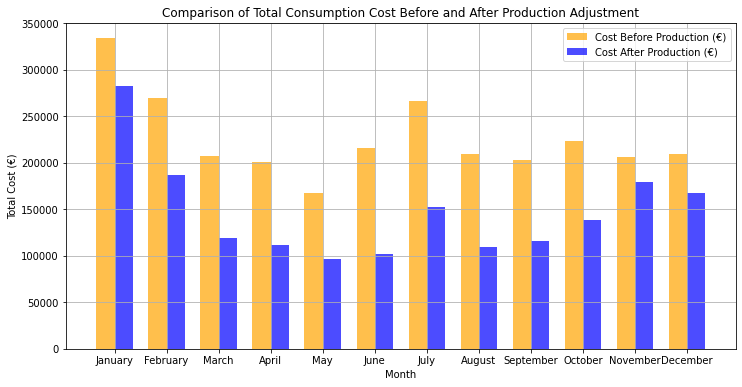

In [68]:
# Calculate total consumption cost before considering production energy (no production subtracted)
# This cost is calculated using only the consumption and PUN prices for each hour
total_cost_before_production = []
for t in yearlist:
    if t in mgp_prices_cleaned.index:
        mgp_price_for_hour = mgp_prices_cleaned.at[t]

        # Calculate costs based on consumption only, without subtracting production
        residential_cost = DF_Consumption.loc[t, 'Residential'] * Area_Res_Max * mgp_price_for_hour
        industrial_cost = DF_Consumption.loc[t, 'Industrial'] * Area_Ind_Max * mgp_price_for_hour
        commercial_cost = DF_Consumption.loc[t, 'Commercial'] * Area_Com_Max * mgp_price_for_hour

        total_cost_before_production.append(residential_cost + industrial_cost + commercial_cost)

# Resample the DataFrame to get monthly totals
results_df['Total Cost Before Production (€)'] = total_cost_before_production
monthly_total_cost_before = results_df['Total Cost Before Production (€)'].resample('M').sum()
monthly_total_net_cost = results_df['Total Net Cost (€)'].resample('M').sum()

# Plot the histogram for each month
months = monthly_total_cost_before.index.strftime('%B')  # Get month names for x-axis labels

plt.figure(figsize=(12, 6))
bar_width = 0.35
index = range(len(months))

# Plotting the bars
plt.bar(index, monthly_total_cost_before, width=bar_width, label='Cost Before Production (€)', color='orange', alpha=0.7)
plt.bar([i + bar_width for i in index], monthly_total_net_cost, width=bar_width, label='Cost After Production (€)', color='blue', alpha=0.7)

# Adding titles and labels
plt.xlabel('Month')
plt.ylabel('Total Cost (€)')
plt.title('Comparison of Total Consumption Cost Before and After Production Adjustment')
plt.xticks([i + bar_width / 2 for i in index], months)  # Set the month names as x-axis labels
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(economic_analysis_dir, 'Comparison of Total Consumption Cost Before and After Production Adjustment.pdf'))
# Display the plot
plt.show()


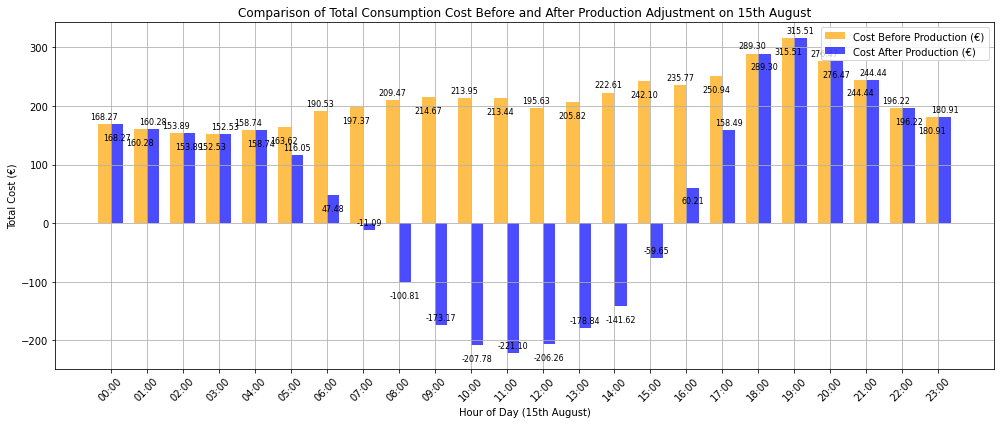

In [69]:
import matplotlib.pyplot as plt
import pandas as pd

# Filter the DataFrame for the specific day of August 15th, 2019
august_15_df = results_df.loc['2019-08-15']

# Calculate total consumption cost before considering production energy for each hour on August 15th
total_cost_before_production_aug_15 = []
for t in august_15_df.index:
    if t in mgp_prices_cleaned.index:
        mgp_price_for_hour = mgp_prices_cleaned.at[t]

        # Calculate costs based on consumption only, without subtracting production
        residential_cost = DF_Consumption.loc[t, 'Residential'] * Area_Res_Max * mgp_price_for_hour
        industrial_cost = DF_Consumption.loc[t, 'Industrial'] * Area_Ind_Max * mgp_price_for_hour
        commercial_cost = DF_Consumption.loc[t, 'Commercial'] * Area_Com_Max * mgp_price_for_hour

        total_cost_before_production_aug_15.append(residential_cost + industrial_cost + commercial_cost)

# Extract the total net cost for August 15th from the DataFrame
total_net_cost_aug_15 = august_15_df['Total Net Cost (€)']

# Plot the histogram for each hour of August 15th
hours = august_15_df.index.strftime('%H:%M')  # Get hour labels for x-axis

plt.figure(figsize=(14, 6))
bar_width = 0.35
index = range(len(hours))

# Plotting the bars
bars_before = plt.bar(index, total_cost_before_production_aug_15, width=bar_width, label='Cost Before Production (€)', color='orange', alpha=0.7)
bars_after = plt.bar([i + bar_width for i in index], total_net_cost_aug_15, width=bar_width, label='Cost After Production (€)', color='blue', alpha=0.7)

# Adding titles and labels
plt.xlabel('Hour of Day (15th August)')
plt.ylabel('Total Cost (€)')
plt.title('Comparison of Total Consumption Cost Before and After Production Adjustment on 15th August')
plt.xticks([i + bar_width / 2 for i in index], hours, rotation=45)  # Set the hour labels as x-axis labels
plt.legend()
plt.grid(True)

# Adding value labels on top of each bar, alternating positions
for i, bar in enumerate(bars_before):
    position = 'bottom' if i % 2 == 0 else 'top'
    offset = 5 if i % 2 == 0 else -15
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + offset, f'{bar.get_height():.2f}', ha='center', va=position, fontsize=8)

for i, bar in enumerate(bars_after):
    position = 'bottom' if i % 2 != 0 else 'top'
    offset = 5 if i % 2 != 0 else -15
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + offset, f'{bar.get_height():.2f}', ha='center', va=position, fontsize=8)

# Display the plot
plt.tight_layout()
plt.savefig(os.path.join(economic_analysis_dir, 'Comparison of Total Consumption Cost Before and After Production Adjustment on 15th August.pdf'))
plt.show()

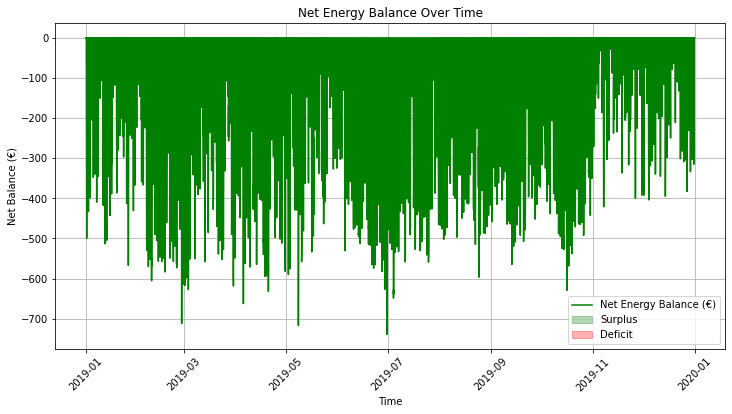

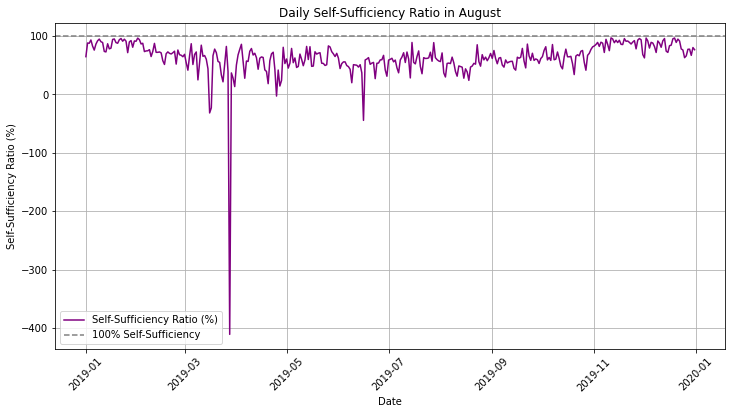

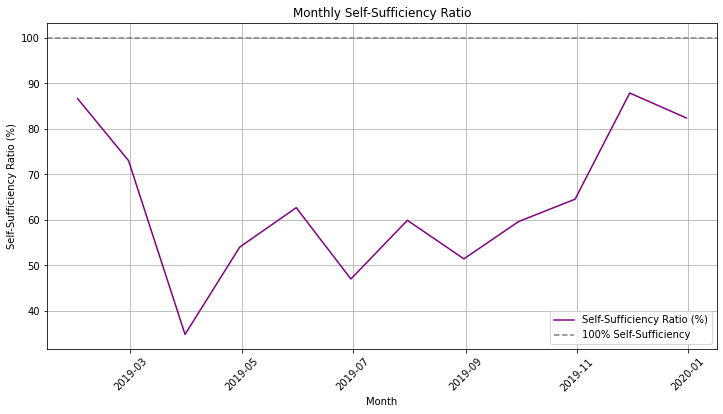

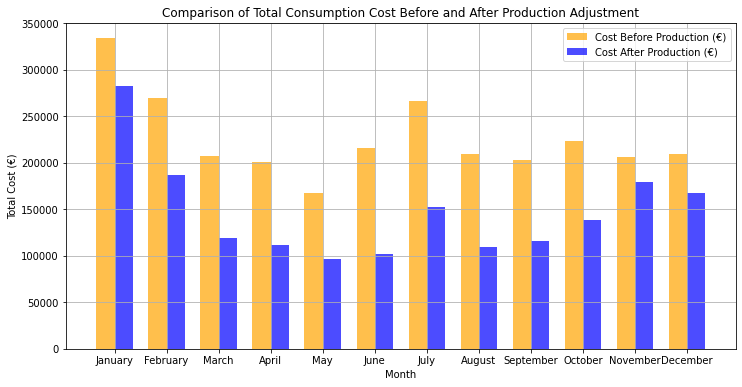

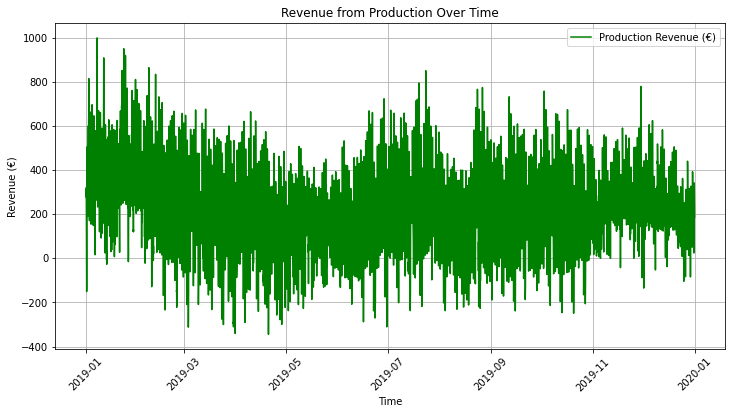

In [70]:
import matplotlib.pyplot as plt
import pandas as pd

# Calculate hourly production values if not already present
if 'Hourly Residential Production (€)' not in results_df.columns:
    results_df['Hourly Residential Production (€)'] = results_df['Hourly Residential Net Cost (€)']

if 'Hourly Industrial Production (€)' not in results_df.columns:
    results_df['Hourly Industrial Production (€)'] = results_df['Hourly Industrial Net Cost (€)']

if 'Hourly Commercial Production (€)' not in results_df.columns:
    results_df['Hourly Commercial Production (€)'] = results_df['Hourly Commercial Net Cost (€)']

# Derive necessary columns if missing
if 'Total Production (€)' not in results_df.columns:
    results_df['Total Production (€)'] = results_df[['Hourly Residential Production (€)', 'Hourly Industrial Production (€)', 'Hourly Commercial Production (€)']].sum(axis=1)

if 'Total Cost Before Production (€)' not in results_df.columns:
    results_df['Total Cost Before Production (€)'] = results_df[['Hourly Residential Cost (€)', 'Hourly Industrial Cost (€)', 'Hourly Commercial Cost (€)']].sum(axis=1)


#Net Energy Balance (Surplus vs. Deficit)
results_df['Net Energy Balance (€)'] = results_df['Total Production (€)'] - results_df['Total Cost Before Production (€)']
plt.figure(figsize=(12, 6))
plt.plot(results_df.index, results_df['Net Energy Balance (€)'], label='Net Energy Balance (€)', color='green')
plt.fill_between(results_df.index, results_df['Net Energy Balance (€)'], where=(results_df['Net Energy Balance (€)'] >= 0), color='green', alpha=0.3, label='Surplus')
plt.fill_between(results_df.index, results_df['Net Energy Balance (€)'], where=(results_df['Net Energy Balance (€)'] < 0), color='red', alpha=0.3, label='Deficit')
plt.title('Net Energy Balance Over Time')
plt.xlabel('Time')
plt.ylabel('Net Balance (€)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.savefig(os.path.join(economic_analysis_dir, 'Net Energy Balance Over Time.pdf'))
plt.show()

# 3. Self-Sufficiency Ratio Over Time
results_df['Self-Sufficiency Ratio'] = results_df['Total Production (€)'] / results_df['Total Cost Before Production (€)']
daily_self_sufficiency = results_df['Self-Sufficiency Ratio'].resample('D').mean()
plt.figure(figsize=(12, 6))
plt.plot(daily_self_sufficiency.index, daily_self_sufficiency * 100, label='Self-Sufficiency Ratio (%)', color='purple')
plt.axhline(100, color='grey', linestyle='--', label='100% Self-Sufficiency')
plt.title('Daily Self-Sufficiency Ratio in August')
plt.xlabel('Date')
plt.ylabel('Self-Sufficiency Ratio (%)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.savefig(os.path.join(economic_analysis_dir, 'Self-Sufficiency Ratio (%).pdf'))
plt.show()

results_df['Self-Sufficiency Ratio'] = results_df['Total Production (€)'] / results_df['Total Cost Before Production (€)']
monthly_self_sufficiency = results_df['Self-Sufficiency Ratio'].resample('M').mean()
plt.figure(figsize=(12, 6))
plt.plot(monthly_self_sufficiency.index, monthly_self_sufficiency * 100, label='Self-Sufficiency Ratio (%)', color='purple')
plt.axhline(100, color='grey', linestyle='--', label='100% Self-Sufficiency')
plt.title('Monthly Self-Sufficiency Ratio')
plt.xlabel('Month')
plt.ylabel('Self-Sufficiency Ratio (%)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.savefig(os.path.join(economic_analysis_dir, 'Monthly Self-Sufficiency Ratio (%).pdf'))
plt.show()


# 4. Cost Analysis: Before vs. After Production
monthly_total_cost_before = results_df['Total Cost Before Production (€)'].resample('M').sum()
monthly_total_net_cost = results_df['Total Net Cost (€)'].resample('M').sum()
months = monthly_total_cost_before.index.strftime('%B')

plt.figure(figsize=(12, 6))
bar_width = 0.35
index = range(len(months))

plt.bar(index, monthly_total_cost_before, width=bar_width, label='Cost Before Production (€)', color='orange', alpha=0.7)
plt.bar([i + bar_width for i in index], monthly_total_net_cost, width=bar_width, label='Cost After Production (€)', color='blue', alpha=0.7)

plt.xlabel('Month')
plt.ylabel('Total Cost (€)')
plt.title('Comparison of Total Consumption Cost Before and After Production Adjustment')
plt.xticks([i + bar_width / 2 for i in index], months)
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(economic_analysis_dir, 'Comparison of Total Consumption Cost Before and After Production Adjustment.pdf'))
plt.show()

# 5. Revenue from Production Over Time
plt.figure(figsize=(12, 6))
plt.plot(results_df.index, results_df['Total Production (€)'], label='Production Revenue (€)', color='green')
plt.title('Revenue from Production Over Time')
plt.xlabel('Time')
plt.ylabel('Revenue (€)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.savefig(os.path.join(economic_analysis_dir, 'Revenue from Production Over Time.pdf'))
plt.show()


## CER Incentives considered

In [71]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Define the file paths
PUN_MGP_path = r'C:\Users\Nik\Documents\GitHub\Thesis\CSV\PUN_MGP'

# Load the PUN.csv (hourly energy price in Eur/Wh) and MGP.csv (consumption price in Eur/Wh)
PUN_df = pd.read_csv(os.path.join(PUN_MGP_path, 'PUN_Cleaned.csv'), sep=",", parse_dates=[0], index_col=0)
MGP_df = pd.read_csv(os.path.join(PUN_MGP_path, 'MGP_Cleaned.csv'), sep=",", parse_dates=[0], index_col=0)

pun_prices = PUN_df["SUD [Eur/Wh]"]  # Column for production prices in €/Wh
mgp_prices = MGP_df["SUD [Eur/Wh]"]  # Column for consumption prices in €/Wh

# Convert all values to strings, then replace commas with dots, and finally convert to floats
pun_prices_cleaned = pun_prices.astype(str).str.replace(',', '.').astype(float)
mgp_prices_cleaned = mgp_prices.astype(str).str.replace(',', '.').astype(float)

# Define the yearlist based on the number of hours
yearlist = Residential_user_production_df.index

# Select the users that were chosen for production
chosen_residential = DF_m2_Residential[DF_m2_Residential['Chosen'] == 1]
chosen_industrial = DF_m2_Industrial[DF_m2_Industrial['Chosen'] == 1]
chosen_commercial = DF_m2_Commercial[DF_m2_Commercial['Chosen'] == 1]

# Create lists to store the hourly revenue data for each category
hourly_production_residential = []
hourly_production_industrial = []
hourly_production_commercial = []
hourly_CER = []
hourly_TIP = []
hourly_E_shared = []
hourly_total_production_Wh = []
hourly_total_consumption_Wh = []
hourly_net_cost_with_CER = []
hourly_net_cost_without_production = []
hourly_net_cost_with_production = []

# Iterate over each hour to compute production revenue for Residential, Industrial, and Commercial
for t in yearlist:
    # Initialize production values to zero in case there's no production for the hour
    residential_production_euro = 0.0
    industrial_production_euro = 0.0
    commercial_production_euro = 0.0
    cer_value = 0.0
    tip_value = 0.0
    e_shared_value = 0.0
    total_production_Wh = 0.0
    total_consumption_Wh = 0.0
    net_cost_with_CER = 0.0
    net_cost_without_production = 0.0
    net_cost_with_production = 0.0

    if t in mgp_prices_cleaned.index and t in pun_prices_cleaned.index:
        # Price for the hour
        price_for_hour = mgp_prices_cleaned.at[t]
        pun_for_hour = pun_prices_cleaned.at[t]

        # Check if the timestamp exists in the production data and calculate the revenue
        if t in Residential_user_production_df.index:
            residential_production_euro = Residential_user_production_df.loc[t, chosen_residential['full_id']].sum() * pun_for_hour
        if t in Industrial_user_production_df.index:
            industrial_production_euro = Industrial_user_production_df.loc[t, chosen_industrial['full_id']].sum() * pun_for_hour
        if t in Commercial_user_production_df.index:
            commercial_production_euro = Commercial_user_production_df.loc[t, chosen_commercial['full_id']].sum() * pun_for_hour

        # Calculate TIP with conditional check
        tip_check = 0.000084 + max(0, (0.000180 - pun_for_hour))
        if tip_check > 0.000120:
            tip_check = 0.000120
        tip_value = tip_check


        # Calculate E_shared as the minimum value between total production and total consumption
        total_production = Residential_user_production_df.loc[t, chosen_residential['full_id']].sum() + \
                           Industrial_user_production_df.loc[t, chosen_industrial['full_id']].sum() + \
                           Commercial_user_production_df.loc[t, chosen_commercial['full_id']].sum()
        total_consumption = DF_Consumption.loc[t, 'Residential'] * Area_Res_Max + \
                            DF_Consumption.loc[t, 'Industrial'] * Area_Ind_Max + \
                            DF_Consumption.loc[t, 'Commercial'] * Area_Com_Max
        E_shared = min(total_production, total_consumption)
        e_shared_value = E_shared

        # Calculate CER
        cer_value = tip_value * E_shared

        # Total production and consumption (Wh)
        total_production_Wh = total_production
        total_consumption_Wh = total_consumption

        # Calculate net costs for plotting
        #CAMBIA MGP!!
        net_cost_without_production = total_consumption * price_for_hour
        net_cost_with_production = (total_consumption - total_production) * (price_for_hour if total_consumption > total_production else pun_prices_cleaned.at[t])
        net_cost_with_CER = net_cost_with_production - cer_value

    # Append results to the lists
    hourly_production_residential.append(residential_production_euro)
    hourly_production_industrial.append(industrial_production_euro)
    hourly_production_commercial.append(commercial_production_euro)
    hourly_CER.append(cer_value)
    hourly_TIP.append(tip_value)
    hourly_E_shared.append(e_shared_value)
    hourly_total_production_Wh.append(total_production_Wh)
    hourly_total_consumption_Wh.append(total_consumption_Wh)
    hourly_net_cost_with_CER.append(net_cost_with_CER)
    hourly_net_cost_without_production.append(net_cost_without_production)
    hourly_net_cost_with_production.append(net_cost_with_production)

# Calculate total production for each hour
total_production_euro = [res + ind + com for res, ind, com in zip(hourly_production_residential, hourly_production_industrial, hourly_production_commercial)]

# Create a DataFrame with the results
results_df = pd.DataFrame({
    'Time': yearlist,
    'Hourly Residential Production (€)': hourly_production_residential,
    'Hourly Industrial Production (€)': hourly_production_industrial,
    'Hourly Commercial Production (€)': hourly_production_commercial,
    'Total Production (€)': total_production_euro,
    'CER (€)': hourly_CER,
    'TIP': hourly_TIP,
    'E_shared': hourly_E_shared,
    'Total Production (Wh)': hourly_total_production_Wh,
    'Total Consumption (Wh)': hourly_total_consumption_Wh,
    'Net Cost Without Production (€)': hourly_net_cost_without_production,
    'Net Cost With Production (€)': hourly_net_cost_with_production,
    'Net Cost With CER (€)': hourly_net_cost_with_CER
})

# Set Time as the index and ensure format
results_df['Time'] = pd.to_datetime(results_df['Time'])  # Convert 'Time' back to datetime if needed
results_df.set_index('Time', inplace=True)

results_file_path_excel = os.path.join(results_dir, 'Total_Economic_Analysis.xlsx')
results_file_path_csv = os.path.join(results_dir, 'Total_Economic_Analysis.csv')

# Save the DataFrame to Excel and CSV
results_df.to_excel(results_file_path_excel)
results_df.to_csv(results_file_path_csv)


In [72]:
results_df.head(20)

Hourly Residential Production (€)  \
Time                                                     
2019-01-01 00:00:00                           0.000000   
2019-01-01 01:00:00                           0.000000   
2019-01-01 02:00:00                           0.000000   
2019-01-01 03:00:00                           0.000000   
2019-01-01 04:00:00                           0.000000   
2019-01-01 05:00:00                           0.000000   
2019-01-01 06:00:00                           0.000000   
2019-01-01 07:00:00                         117.139193   
2019-01-01 08:00:00                         261.636983   
2019-01-01 09:00:00                         355.527294   
2019-01-01 10:00:00                         445.832823   
2019-01-01 11:00:00                         475.788023   
2019-01-01 12:00:00                         479.415730   
2019-01-01 13:00:00                         395.802312   
2019-01-01 14:00:00                         323.032190   
2019-01-01 15:00:00                          16.906880   
2019-01-01 16:00:00                           0.000000   
2019-01-01 17:00:00                           0.000000   
2019-01-01 18:00:00                           0.000000   
2019-01-01 19:00:00                           0.000000   

                     Hourly Industrial Production (€)  \
Time                                                    
2019-01-01 00:00:00                          0.000000   
2019-01-01 01:00:00                          0.000000   
2019-01-01 02:00:00                          0.000000   
2019-01-01 03:00:00                          0.000000   
2019-01-01 04:00:00                          0.000000   
2019-01-01 05:00:00                          0.000000   
2019-01-01 06:00:00                          0.000000   
2019-01-01 07:00:00                          0.877347   
2019-01-01 08:00:00                          1.961164   
2019-01-01 09:00:00                          2.669284   
2019-01-01 10:00:00                          3.358581   
2019-01-01 11:00:00                          3.592360   
2019-01-01 12:00:00                          3.626315   
2019-01-01 13:00:00                          2.998834   
2019-01-01 14:00:00                          2.452045   
2019-01-01 15:00:00                          0.128429   
2019-01-01 16:00:00                          0.000000   
2019-01-01 17:00:00                          0.000000   
2019-01-01 18:00:00                          0.000000   
2019-01-01 19:00:00                          0.000000   

                     Hourly Commercial Production (€)  Total Production (€)  \
Time                                                                          
2019-01-01 00:00:00                          0.000000              0.000000   
2019-01-01 01:00:00                          0.000000              0.000000   
2019-01-01 02:00:00                          0.000000              0.000000   
2019-01-01 03:00:00                          0.000000              0.000000   
2019-01-01 04:00:00                          0.000000              0.000000   
2019-01-01 05:00:00                          0.000000              0.000000   
2019-01-01 06:00:00                          0.000000              0.000000   
2019-01-01 07:00:00                          3.940930            121.957470   
2019-01-01 08:00:00                          8.788221            272.386368   
2019-01-01 09:00:00                         11.956716            370.153294   
2019-01-01 10:00:00                         15.060467            464.251871   
2019-01-01 11:00:00                         16.125642            495.506025   
2019-01-01 12:00:00                         16.297276            499.339321   
2019-01-01 13:00:00                         13.498957            412.300103   
2019-01-01 14:00:00                         11.069961            336.554197   
2019-01-01 15:00:00                          0.572131             17.607440   
2019-01-01 16:00:00                          0.000000              

In [73]:
# Calculate total savings from CER incentives
total_savings_CER = results_df['CER (€)'].sum()

print(f'Total Savings from CER Incentives: €{total_savings_CER:.2f}')


Total Savings from CER Incentives: €885517.23


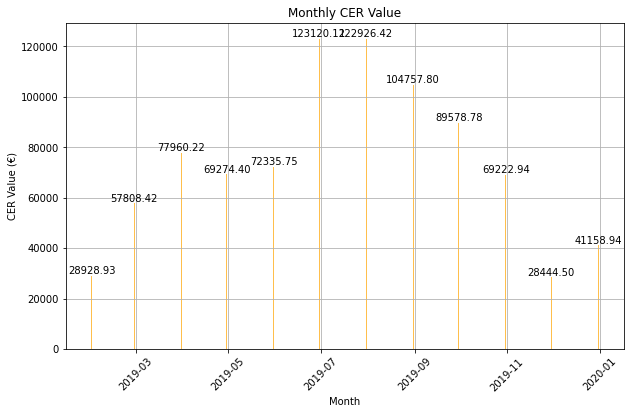

C:\Users\Nik\AppData\Local\Temp/ipykernel_10848/2960888260.py:23: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  august_df = results_df['2019-08']


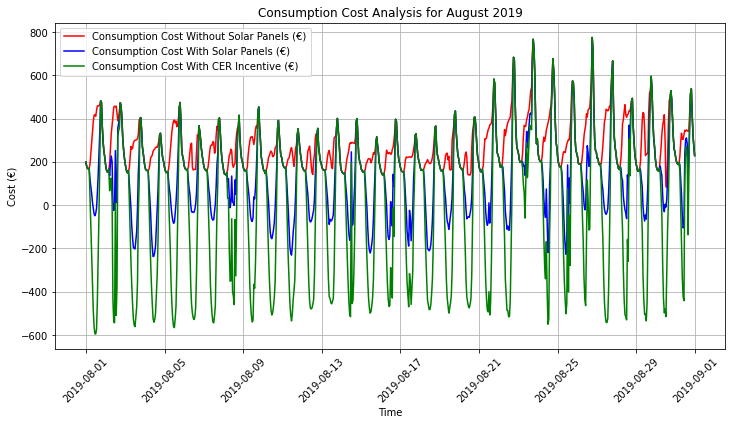

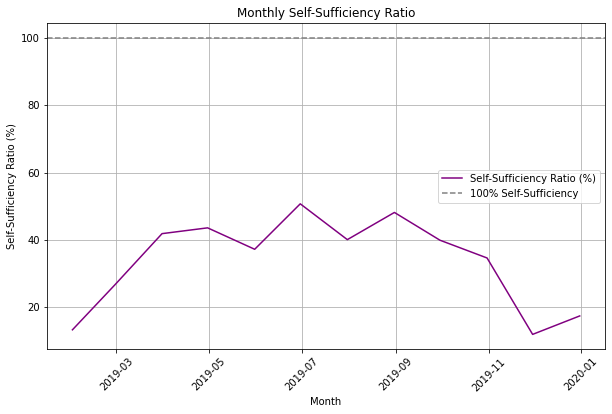

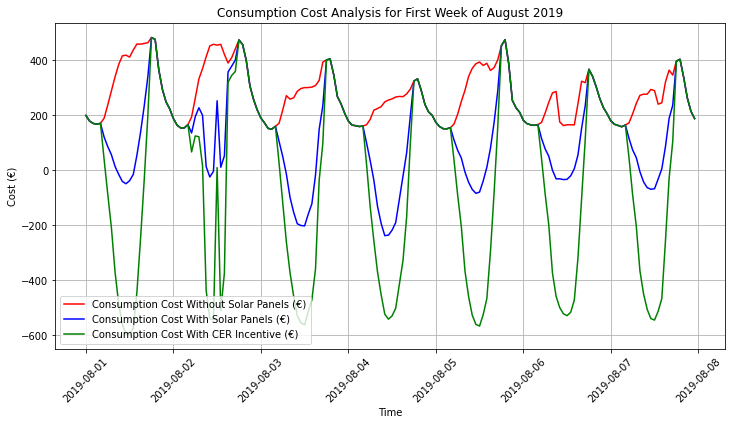

C:\Users\Nik\AppData\Local\Temp/ipykernel_10848/2960888260.py:68: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  first_day_df = results_df['2019-08-01']


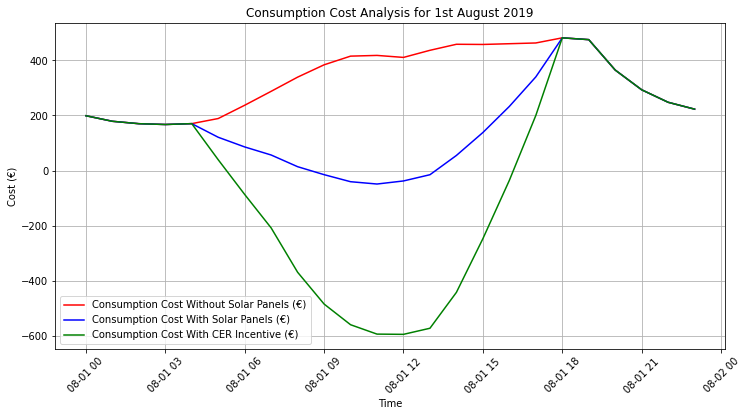

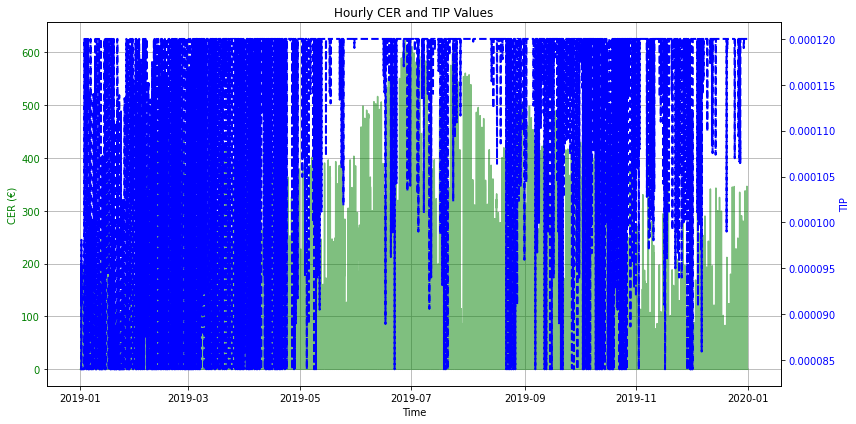

In [74]:
import matplotlib.pyplot as plt

#Monthly CER Value Histogram
monthly_CER = results_df['CER (€)'].resample('M').sum()
plt.figure(figsize=(10, 6))
bar_width = 0.6
bars = plt.bar(monthly_CER.index, monthly_CER, width=bar_width, color='orange', alpha=0.7)
plt.title('Monthly CER Value')
plt.xlabel('Month')
plt.ylabel('CER Value (€)')
plt.xticks(rotation=45)
plt.savefig(os.path.join(economic_analysis_dir, 'Monthly CER Value.pdf'))
plt.grid(True)

# Add value labels on top of bars
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{bar.get_height():.2f}', 
             ha='center', va='bottom', fontsize=10, color='black')

plt.show()

#Cost Analysis for August (Without Production vs. With Production vs. With CER Incentive)
august_df = results_df['2019-08']
plt.figure(figsize=(12, 6))
plt.plot(august_df.index, august_df['Net Cost Without Production (€)'], label='Consumption Cost Without Solar Panels (€)', color='red')
plt.plot(august_df.index, august_df['Net Cost With Production (€)'], label='Consumption Cost With Solar Panels (€)', color='blue')
plt.plot(august_df.index, august_df['Net Cost With CER (€)'], label='Consumption Cost With CER Incentive (€)', color='green')
plt.title('Consumption Cost Analysis for August 2019')
plt.xlabel('Time')
plt.ylabel('Cost (€)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(economic_analysis_dir, 'Consumption Cost Analysis for August 2019.pdf'))
plt.show()

#Monthly Self-Sufficiency Ratio
results_df['Self-Sufficiency Ratio'] = results_df['Total Production (Wh)'] / results_df['Total Consumption (Wh)']
monthly_self_sufficiency = results_df['Self-Sufficiency Ratio'].resample('M').mean() * 100
plt.figure(figsize=(10, 6))
plt.plot(monthly_self_sufficiency.index, monthly_self_sufficiency, label='Self-Sufficiency Ratio (%)', color='purple')
plt.axhline(100, color='grey', linestyle='--', label='100% Self-Sufficiency')
plt.title('Monthly Self-Sufficiency Ratio')
plt.xlabel('Month')
plt.ylabel('Self-Sufficiency Ratio (%)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(economic_analysis_dir, 'Monthly Self-Sufficiency Ratio.pdf'))
plt.show()

#First Week Cost Analysis (Without Production vs. With Production vs. With CER Incentive)
first_week_df = results_df['2019-08-01':'2019-08-07']
plt.figure(figsize=(12, 6))
plt.plot(first_week_df.index, first_week_df['Net Cost Without Production (€)'], label='Consumption Cost Without Solar Panels (€)', color='red')
plt.plot(first_week_df.index, first_week_df['Net Cost With Production (€)'], label='Consumption Cost With Solar Panels (€)', color='blue')
plt.plot(first_week_df.index, first_week_df['Net Cost With CER (€)'], label='Consumption Cost With CER Incentive (€)', color='green')
plt.title('Consumption Cost Analysis for First Week of August 2019')
plt.xlabel('Time')
plt.ylabel('Cost (€)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(economic_analysis_dir, 'Consumption Cost Analysis for First Week of August 2019.pdf'))
plt.show()

#First Day of August Cost Analysis (Without Production vs. With Production vs. With CER Incentive)
first_day_df = results_df['2019-08-01']
plt.figure(figsize=(12, 6))
plt.plot(first_day_df.index, first_day_df['Net Cost Without Production (€)'], label='Consumption Cost Without Solar Panels (€)', color='red')
plt.plot(first_day_df.index, first_day_df['Net Cost With Production (€)'], label='Consumption Cost With Solar Panels (€)', color='blue')
plt.plot(first_day_df.index, first_day_df['Net Cost With CER (€)'], label='Consumption Cost With CER Incentive (€)', color='green')
plt.title('Consumption Cost Analysis for 1st August 2019')
plt.xlabel('Time')
plt.ylabel('Cost (€)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(economic_analysis_dir, 'Consumption Cost Analysis for 1st August 2019.pdf'))
plt.show()

#Plot Hourly CER and TIP Values
import matplotlib.pyplot as plt

# Create a figure and axis objects
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot CER on the primary y-axis
ax1.plot(results_df.index, results_df['CER (€)'], label='Hourly CER (€)', color='green', alpha=0.5, linewidth=1.5)
ax1.set_xlabel('Time')
ax1.set_ylabel('CER (€)', color='green')
ax1.tick_params(axis='y', labelcolor='green')
ax1.set_title('Hourly CER and TIP Values')
ax1.grid(True)

# Create a second y-axis for TIP
ax2 = ax1.twinx()
ax2.plot(results_df.index, results_df['TIP'], label='Hourly TIP', color='blue', linewidth=2, linestyle='--')
ax2.set_ylabel('TIP', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Show the plot with legends
fig.tight_layout()
plt.xticks(rotation=45)
plt.savefig(os.path.join(economic_analysis_dir, 'Hourly CER and TIP Values.pdf'))
plt.show()


In [75]:
results_df['2019-08'].head(20)

C:\Users\Nik\AppData\Local\Temp/ipykernel_10848/600618086.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  results_df['2019-08'].head(20)


Hourly Residential Production (€)  \
Time                                                     
2019-08-01 00:00:00                           0.000000   
2019-08-01 01:00:00                           0.000000   
2019-08-01 02:00:00                           0.000000   
2019-08-01 03:00:00                           0.000000   
2019-08-01 04:00:00                           0.000000   
2019-08-01 05:00:00                          65.389052   
2019-08-01 06:00:00                         145.477114   
2019-08-01 07:00:00                         222.264055   
2019-08-01 08:00:00                         312.455897   
2019-08-01 09:00:00                         383.250738   
2019-08-01 10:00:00                         438.075938   
2019-08-01 11:00:00                         448.638625   
2019-08-01 12:00:00                         430.912396   
2019-08-01 13:00:00                         433.941881   
2019-08-01 14:00:00                         387.728297   
2019-08-01 15:00:00                         307.101738   
2019-08-01 16:00:00                         218.673679   
2019-08-01 17:00:00                         118.269495   
2019-08-01 18:00:00                           0.000000   
2019-08-01 19:00:00                           0.000000   

                     Hourly Industrial Production (€)  \
Time                                                    
2019-08-01 00:00:00                          0.000000   
2019-08-01 01:00:00                          0.000000   
2019-08-01 02:00:00                          0.000000   
2019-08-01 03:00:00                          0.000000   
2019-08-01 04:00:00                          0.000000   
2019-08-01 05:00:00                          0.495112   
2019-08-01 06:00:00                          1.098175   
2019-08-01 07:00:00                          1.676432   
2019-08-01 08:00:00                          2.361565   
2019-08-01 09:00:00                          2.900470   
2019-08-01 10:00:00                          3.319020   
2019-08-01 11:00:00                          3.402631   
2019-08-01 12:00:00                          3.271635   
2019-08-01 13:00:00                          3.298492   
2019-08-01 14:00:00                          2.951284   
2019-08-01 15:00:00                          2.341720   
2019-08-01 16:00:00                          1.672469   
2019-08-01 17:00:00                          0.907043   
2019-08-01 18:00:00                          0.000000   
2019-08-01 19:00:00                          0.000000   

                     Hourly Commercial Production (€)  Total Production (€)  \
Time                                                                          
2019-08-01 00:00:00                          0.000000              0.000000   
2019-08-01 01:00:00                          0.000000              0.000000   
2019-08-01 02:00:00                          0.000000              0.000000   
2019-08-01 03:00:00                          0.000000              0.000000   
2019-08-01 04:00:00                          0.000000              0.000000   
2019-08-01 05:00:00                          2.178805             68.062969   
2019-08-01 06:00:00                          4.851866            151.427156   
2019-08-01 07:00:00                          7.424691            231.365178   
2019-08-01 08:00:00                         10.494367            325.311830   
2019-08-01 09:00:00                         12.913434            399.064642   
2019-08-01 10:00:00                         14.796084            456.191043   
2019-08-01 11:00:00                         15.184223            467.225479   
2019-08-01 12:00:00                         14.611732            448.795763   
2019-08-01 13:00:00                         14.742629            451.983002   
2019-08-01 14:00:00                         13.199706            403.879287   
2019-08-01 15:00:00                         10.480119            319.923576   
2019-08-01 16:00:00                          7.491715            22

In [76]:
import matplotlib.pyplot as plt
import numpy as np

# Filter the DataFrame for the month of August and the time range from 08:00 to 20:00
august_df = results_df.loc['2019-08-01':'2019-08-31']
august_daytime_df = august_df.between_time('08:00', '20:00')
august_daytime_df

Hourly Residential Production (€)  \
Time                                                     
2019-08-01 08:00:00                         312.455897   
2019-08-01 09:00:00                         383.250738   
2019-08-01 10:00:00                         438.075938   
2019-08-01 11:00:00                         448.638625   
2019-08-01 12:00:00                         430.912396   
...                                                ...   
2019-08-31 16:00:00                          91.834925   
2019-08-31 17:00:00                          21.785618   
2019-08-31 18:00:00                           0.000000   
2019-08-31 19:00:00                           0.000000   
2019-08-31 20:00:00                           0.000000   

                     Hourly Industrial Production (€)  \
Time                                                    
2019-08-01 08:00:00                          2.361565   
2019-08-01 09:00:00                          2.900470   
2019-08-01 10:00:00                          3.319020   
2019-08-01 11:00:00                          3.402631   
2019-08-01 12:00:00                          3.271635   
...                                               ...   
2019-08-31 16:00:00                          0.699288   
2019-08-31 17:00:00                          0.165489   
2019-08-31 18:00:00                          0.000000   
2019-08-31 19:00:00                          0.000000   
2019-08-31 20:00:00                          0.000000   

                     Hourly Commercial Production (€)  Total Production (€)  \
Time                                                                          
2019-08-01 08:00:00                         10.494367            325.311830   
2019-08-01 09:00:00                         12.913434            399.064642   
2019-08-01 10:00:00                         14.796084            456.191043   
2019-08-01 11:00:00                         15.184223            467.225479   
2019-08-01 12:00:00                         14.611732            448.795763   
...                                               ...                   ...   
2019-08-31 16:00:00                          3.125192             95.659405   
2019-08-31 17:00:00                          0.737229             22.688336   
2019-08-31 18:00:00                          0.000000              0.000000   
2019-08-31 19:00:00                          0.000000              0.000000   
2019-08-31 20:00:00                          0.000000              0.000000   

                        CER (€)       TIP      E_shared  \
Time                                                      
2019-08-01 08:00:00  383.509378  0.000120  3.195911e+06   
2019-08-01 09:00:00  470.000880  0.000120  3.916674e+06   
2019-08-01 10:00:00  519.551160  0.000120  4.329593e+06   
2019-08-01 11:00:00  545.271000  0.000120  4.543925e+06   
2019-08-01 12:00:00  557.280960  0.000120  4.644008e+06   
...                         ...       ...           ...   
2019-08-31 16:00:00   96.390365  0.000120  8.032530e+05   
2019-08-31 17:00:00   18.925347  0.000120  1.577112e+05   
2019-08-31 18:00:00    0.000000  0.000102  0.000000e+00   
2019-08-31 19:00:00    0.000000  0.000096  0.000000e+00   
2019-08-31 20:00:00    0.000000  0.000117  0.000000e+00   

                     Total Production (Wh)  Total Consumption (Wh)  \
Time                                                                 
2019-08-01 08:00:00           3.195911e+06               3333623.0   
2019-08-01 09:00:00           4.069182e+06               3916674.0   
2019-08-01 10:00:00           4.751990e+06               4329593.0   
2019-08-01 11:00:00           5.075779e+06               4543925.0   
2019-08-01 12:00:00           5.071139e+06               4644008.0   
...                                    ...                     ...   
2019-08-31 16:00:00           8.032530e+05               2895135.0   
2019-08-31 17:00:00           1.577112e+05               2754456.0   
2019-08-31 18:00:00         

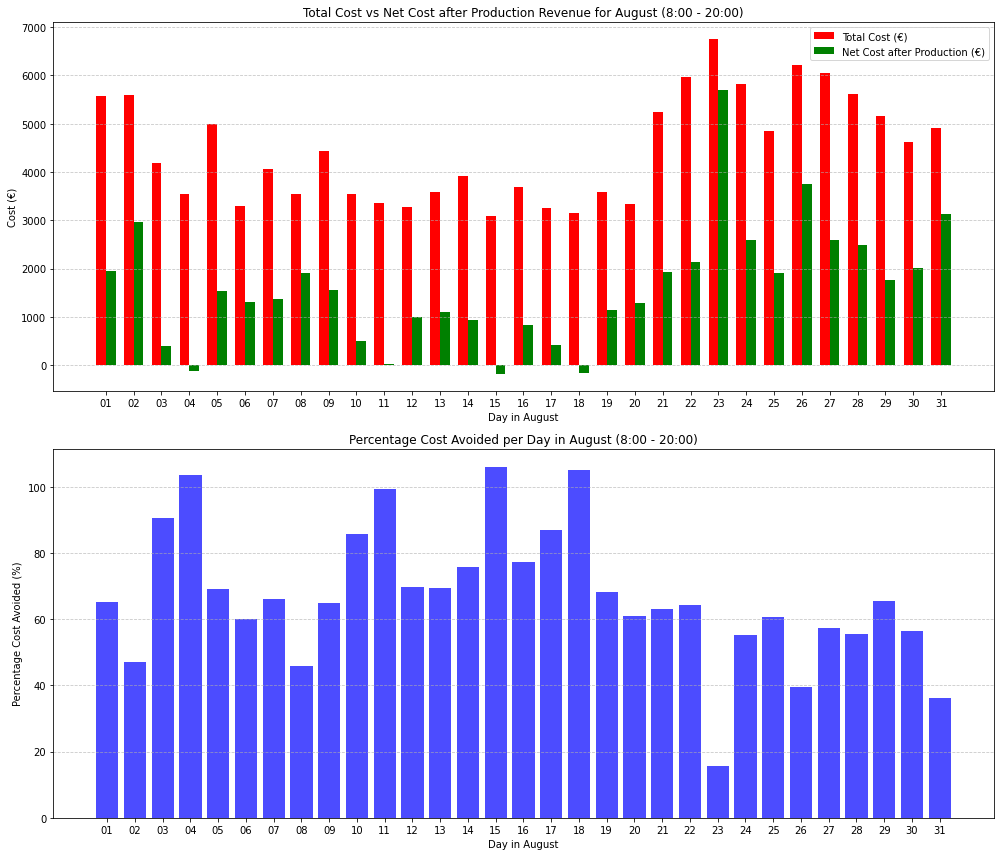

Total cost for August (8:00 - 20:00) without production revenue: 138231.13 €
Total net cost for August (8:00 - 20:00) after subtracting production revenue: 49819.56 €
Average percentage of cost avoided in August (8:00 - 20:00): 67.33%


In [77]:
import matplotlib.pyplot as plt
import numpy as np

# Filter the DataFrame for the month of August and the time range from 08:00 to 20:00
august_df = results_df.loc['2019-08-01':'2019-08-31']
august_daytime_df = august_df.between_time('08:00', '20:00')

# Group by day and sum the costs for each day
daily_total_cost = august_daytime_df['Net Cost Without Production (€)'].resample('D').sum()
daily_net_cost = (august_daytime_df['Net Cost Without Production (€)'] - august_daytime_df['Total Production (€)']).resample('D').sum()

# Calculate percentage cost avoided for each day
percentage_cost_avoided = ((daily_total_cost - daily_net_cost) / daily_total_cost) * 100

# Calculate total cost for the month before and after solar panel revenue
total_cost_month = daily_total_cost.sum()
net_cost_month = daily_net_cost.sum()

# Plotting the histogram for each day in August
fig, axs = plt.subplots(2, 1, figsize=(14, 12))

# Setting the position for each bar
days = np.arange(len(daily_total_cost))
width = 0.35  # width of the bars

# Plot total cost vs net cost
axs[0].bar(days - width/2, daily_total_cost, width, label='Total Cost (€)', color='red')
axs[0].bar(days + width/2, daily_net_cost, width, label='Net Cost after Production (€)', color='green')

# Adding labels, title, and grid
axs[0].set_xlabel('Day in August')
axs[0].set_ylabel('Cost (€)')
axs[0].set_title('Total Cost vs Net Cost after Production Revenue for August (8:00 - 20:00)')
axs[0].set_xticks(days)
axs[0].set_xticklabels(daily_total_cost.index.strftime('%d'))  # Set x-axis labels as the day of the month
axs[0].grid(axis='y', linestyle='--', alpha=0.7)
axs[0].legend()

# Plot percentage cost avoided
axs[1].bar(days, percentage_cost_avoided, color='blue', alpha=0.7)
axs[1].set_xlabel('Day in August')
axs[1].set_ylabel('Percentage Cost Avoided (%)')
axs[1].set_title('Percentage Cost Avoided per Day in August (8:00 - 20:00)')
axs[1].set_xticks(days)
axs[1].set_xticklabels(daily_total_cost.index.strftime('%d'))
axs[1].grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout and show the plot
plt.tight_layout()
plt.savefig(os.path.join(economic_analysis_dir,'Total Cost vs Net Cost after Production Revenue for August 800 - 2000.pdf'))
plt.show()

# Print the total cost before and after the addition of solar panel revenue
print(f'Total cost for August (8:00 - 20:00) without production revenue: {total_cost_month:.2f} €')
print(f'Total net cost for August (8:00 - 20:00) after subtracting production revenue: {net_cost_month:.2f} €')

# Print the average percentage cost avoided for August
average_percentage_cost_avoided = percentage_cost_avoided.mean()
print(f'Average percentage of cost avoided in August (8:00 - 20:00): {average_percentage_cost_avoided:.2f}%')


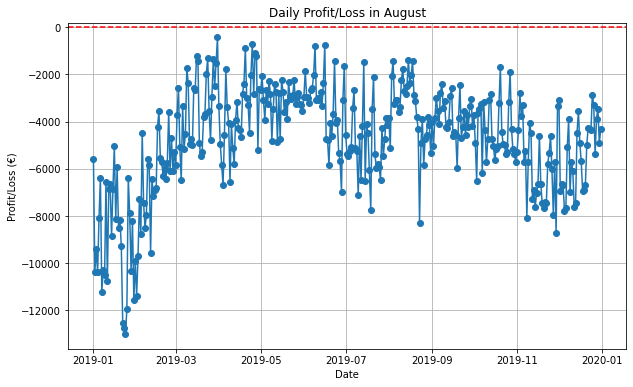

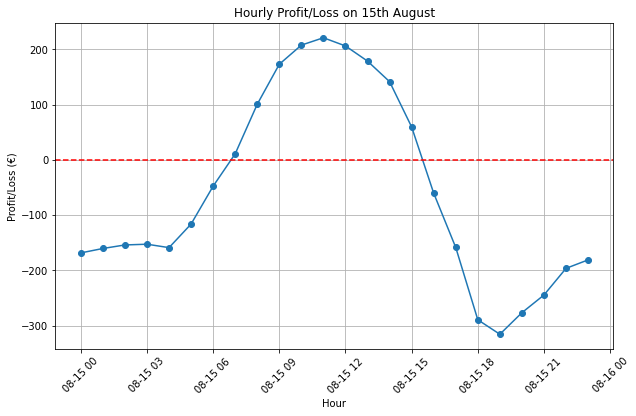

In [78]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure daily_profit_loss contains only numeric values
results_df['Daily Profit/Loss (€)'] = results_df['Total Production (€)'] - results_df['Net Cost Without Production (€)']
daily_profit_loss = results_df['Daily Profit/Loss (€)'].resample('D').sum()

# Drop any non-numeric values or convert them to NaN
daily_profit_loss = pd.to_numeric(daily_profit_loss, errors='coerce').dropna()

# Plot daily profit/loss for the entire month of August
plt.figure(figsize=(10, 6))
plt.plot(daily_profit_loss, marker='o')
plt.axhline(0, color='red', linestyle='--')
plt.title('Daily Profit/Loss in August')
plt.xlabel('Date')
plt.ylabel('Profit/Loss (€)')
plt.grid(True)
plt.savefig(os.path.join(economic_analysis_dir, 'Daily Profit_Loss in August.pdf'))
plt.show()

# Filter for the 15th of August
profit_loss_aug_15 = results_df.loc['2019-08-15']

# Plot the profit/loss for each hour of the 15th of August
plt.figure(figsize=(10, 6))
plt.plot(profit_loss_aug_15.index, profit_loss_aug_15['Daily Profit/Loss (€)'], marker='o')
plt.axhline(0, color='red', linestyle='--')
plt.title('Hourly Profit/Loss on 15th August')
plt.xlabel('Hour')
plt.ylabel('Profit/Loss (€)')
plt.grid(True)
plt.xticks(rotation=45)
plt.savefig(os.path.join(economic_analysis_dir,'Hourly Profit_Loss on 15th August.pdf'))
plt.show()


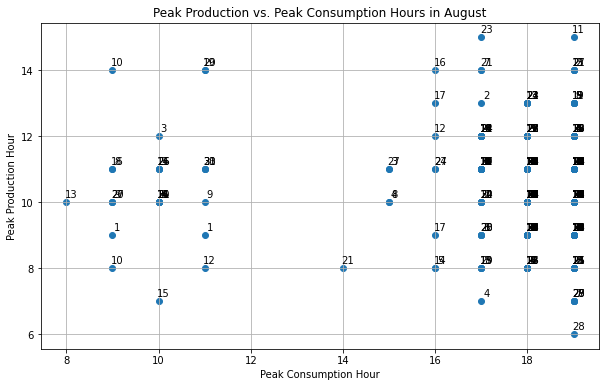

In [79]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert the columns to numeric if they are not already
results_df['Total Production (€)'] = pd.to_numeric(results_df['Total Production (€)'], errors='coerce')
results_df['Net Cost Without Production (€)'] = pd.to_numeric(results_df['Net Cost Without Production (€)'], errors='coerce')

# Calculate the timestamp for peak production and peak consumption for each day
peak_production = results_df['Total Production (€)'].resample('D').apply(lambda x: x.idxmax())
peak_consumption = results_df['Net Cost Without Production (€)'].resample('D').apply(lambda x: x.idxmax())

# Extract the hour for each peak value
peak_production_hours = peak_production.dt.hour
peak_consumption_hours = peak_consumption.dt.hour

# Plot peak production vs peak consumption
plt.figure(figsize=(10, 6))
plt.scatter(peak_consumption_hours, peak_production_hours)

# Annotate each point with the day of the month
for i, (consumption_time, production_time) in enumerate(zip(peak_consumption, peak_production)):
    day_of_month = consumption_time.day
    plt.annotate(day_of_month, (consumption_time.hour, production_time.hour), textcoords="offset points", xytext=(5,5), ha='center')

plt.title('Peak Production vs. Peak Consumption Hours in August')
plt.xlabel('Peak Consumption Hour')
plt.ylabel('Peak Production Hour')
plt.grid(True)
plt.savefig(os.path.join(economic_analysis_dir, 'Peak Production vs. Peak Consumption Hours in August.pdf'))
plt.show()


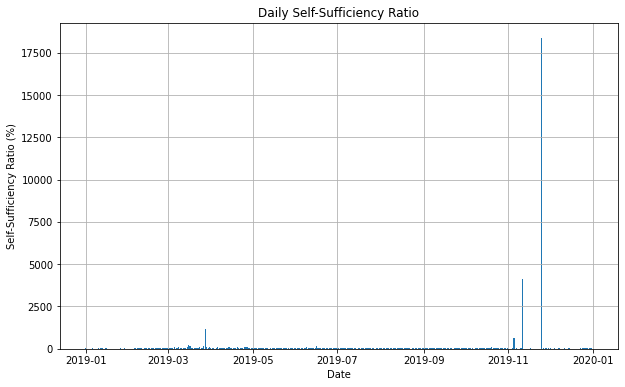

In [80]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Calculate the self-sufficiency ratio safely
results_df['Self-Sufficiency Ratio'] = results_df.apply(
    lambda row: row['Total Production (€)'] / row['Net Cost Without Production (€)'] 
    if row['Net Cost Without Production (€)'] != 0 else np.nan, 
    axis=1
)

# Calculate the daily average self-sufficiency ratio
daily_self_sufficiency = results_df['Self-Sufficiency Ratio'].resample('D').mean()

# Drop NaN values if needed (optional)
daily_self_sufficiency = daily_self_sufficiency.dropna()

# Plot self-sufficiency ratio
plt.figure(figsize=(10, 6))
plt.bar(daily_self_sufficiency.index, daily_self_sufficiency * 100)
plt.title('Daily Self-Sufficiency Ratio')
plt.xlabel('Date')
plt.ylabel('Self-Sufficiency Ratio (%)')
plt.grid(True)
plt.savefig(os.path.join(economic_analysis_dir, 'Daily Self-Sufficiency Ratio.pdf'))
plt.show()


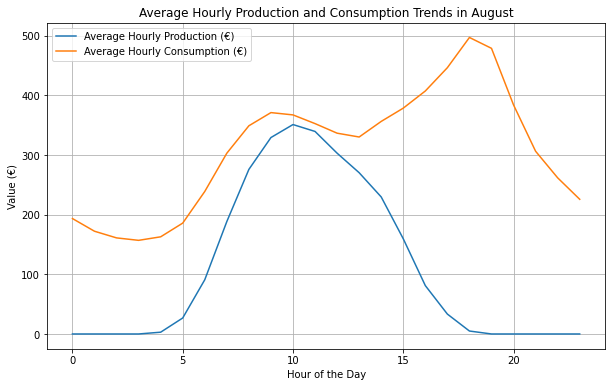

In [81]:
# Calculate average hourly values across the month
average_hourly_production = results_df['Total Production (€)'].groupby(results_df.index.hour).mean()
average_hourly_consumption = results_df['Net Cost Without Production (€)'].groupby(results_df.index.hour).mean()

# Plot average hourly trends
plt.figure(figsize=(10, 6))
plt.plot(average_hourly_production, label='Average Hourly Production (€)')
plt.plot(average_hourly_consumption, label='Average Hourly Consumption (€)')
plt.title('Average Hourly Production and Consumption Trends in August')
plt.xlabel('Hour of the Day')
plt.ylabel('Value (€)')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(economic_analysis_dir, 'Average Hourly Production and Consumption Trends in August.pdf'))
plt.show()


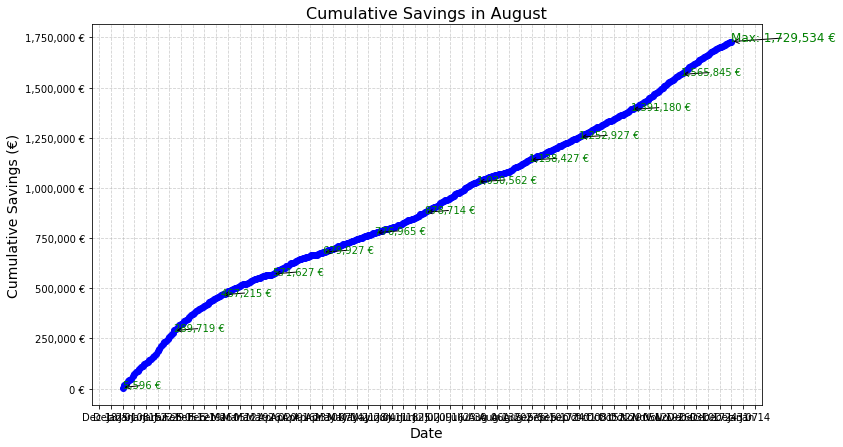

In [82]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Calculate cumulative savings (production cost avoided)
results_df['Daily Savings (€)'] = results_df['Net Cost Without Production (€)'] - results_df['Total Production (€)']
cumulative_savings = results_df['Daily Savings (€)'].resample('D').sum().cumsum()
plt.figure(figsize=(12, 7))
plt.plot(cumulative_savings, marker='o', linestyle='-', color='blue')

# Enhancements
plt.title('Cumulative Savings in August', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Cumulative Savings (€)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)

# Format the x-axis to show dates clearly
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

# Adding y-axis tick formatting for better clarity (€, separated by thousands)
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: f'{x:,.0f} €'))

# Highlighting max cumulative savings with a text annotation
max_savings_date = cumulative_savings.idxmax()
max_savings_value = cumulative_savings.max()
plt.annotate(f'Max: {max_savings_value:,.0f} €', xy=(max_savings_date, max_savings_value), 
             xytext=(max_savings_date, max_savings_value + 500), 
             arrowprops=dict(facecolor='green', arrowstyle='->'),
             fontsize=12, color='green')

# Add annotation for the start of each month
start_of_months = cumulative_savings.resample('MS').first()
for date, value in start_of_months.items():
    plt.annotate(f'{value:,.0f} €', xy=(date, value), 
                 xytext=(date, value - 5000),  # Adjust text position
                 fontsize=10, color='green', arrowprops=dict(facecolor='green', arrowstyle='->'))
    
plt.savefig(os.path.join(economic_analysis_dir, 'Cumulative Savings in August.pdf'))

plt.show()


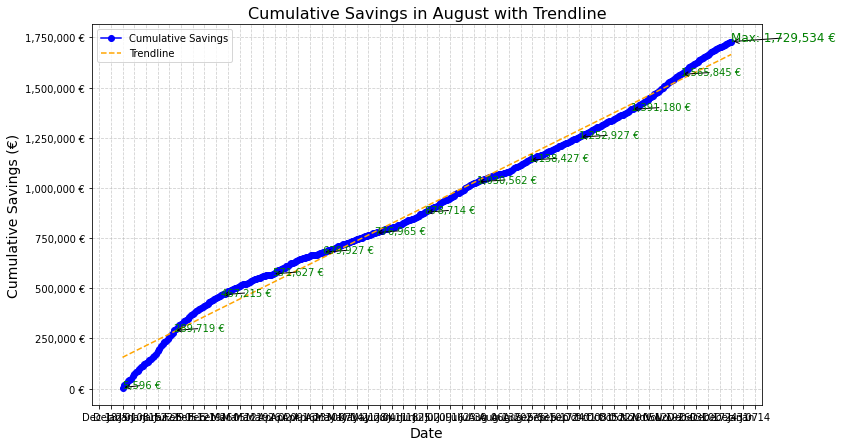

In [83]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from scipy.stats import linregress

# Prepare the data for trendline calculation
x = np.arange(len(cumulative_savings))  # Numeric x-values for each point (date index)
y = cumulative_savings.values           # Cumulative savings values

# Calculate the trendline using linear regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)
trendline = intercept + slope * x

# Plot the cumulative savings with the trendline
plt.figure(figsize=(12, 7))
plt.plot(cumulative_savings, marker='o', linestyle='-', color='blue', label='Cumulative Savings')
plt.plot(cumulative_savings.index, trendline, linestyle='--', color='orange', label='Trendline')

# Enhancements
plt.title('Cumulative Savings in August with Trendline', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Cumulative Savings (€)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)

# Format the x-axis to show dates clearly
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

# Adding y-axis tick formatting for better clarity (€, separated by thousands)
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: f'{x:,.0f} €'))

# Highlighting max cumulative savings with a text annotation
max_savings_date = cumulative_savings.idxmax()
max_savings_value = cumulative_savings.max()
plt.annotate(f'Max: {max_savings_value:,.0f} €', xy=(max_savings_date, max_savings_value), 
             xytext=(max_savings_date, max_savings_value + 500), 
             arrowprops=dict(facecolor='green', arrowstyle='->'),
             fontsize=12, color='green')

# Add annotation for the start of each month
start_of_months = cumulative_savings.resample('MS').first()
for date, value in start_of_months.items():
    plt.annotate(f'{value:,.0f} €', xy=(date, value), 
                 xytext=(date, value - 5000),  # Adjust text position
                 fontsize=10, color='green', arrowprops=dict(facecolor='green', arrowstyle='->'))

# Add a legend to differentiate between cumulative savings and the trendline
plt.legend()
plt.savefig(os.path.join(economic_analysis_dir, 'Cumulative Savings in August with Trendline.pdf'))
plt.show()


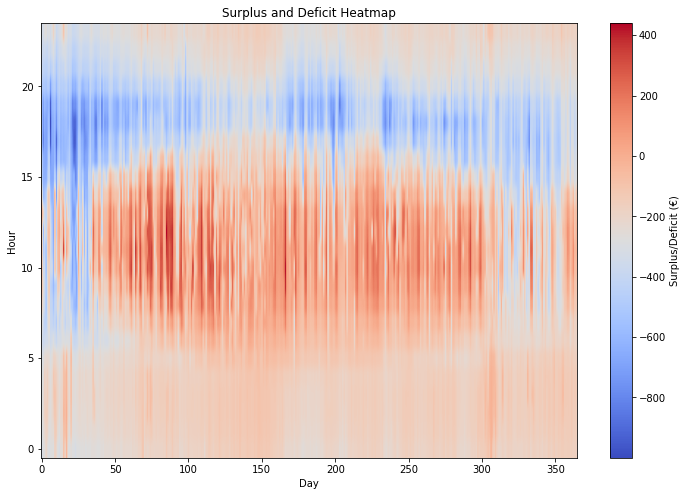

In [84]:
# Calculate energy surplus and deficit
results_df['Surplus/Deficit (€)'] = results_df['Total Production (€)'] - results_df['Net Cost Without Production (€)']
surplus_deficit = results_df.pivot_table(index=results_df.index.date, columns=results_df.index.hour, values='Surplus/Deficit (€)')

# Plot heatmap for energy surplus/deficit
plt.figure(figsize=(12, 8))
plt.imshow(surplus_deficit.T, aspect='auto', cmap='coolwarm', origin='lower')
plt.colorbar(label='Surplus/Deficit (€)')
plt.title('Surplus and Deficit Heatmap')
plt.xlabel('Day')
plt.ylabel('Hour')
plt.savefig(os.path.join(economic_analysis_dir, 'Surplus and Deficit Heatmap.pdf'))
plt.show()


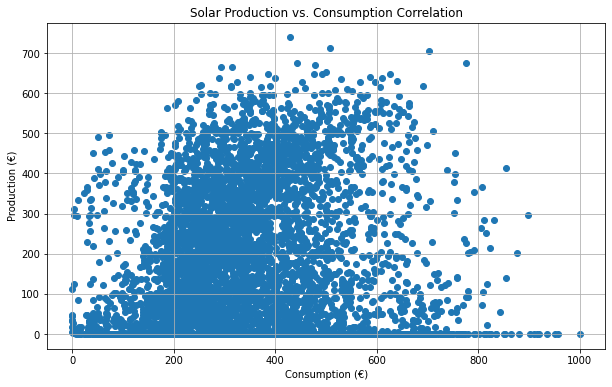

In [85]:
# Scatter plot for production vs. consumption
plt.figure(figsize=(10, 6))
plt.scatter(results_df['Net Cost Without Production (€)'], results_df['Total Production (€)'])
plt.title('Solar Production vs. Consumption Correlation')
plt.xlabel('Consumption (€)')
plt.ylabel('Production (€)')
plt.grid(True)
plt.savefig(os.path.join(economic_analysis_dir, 'Scatter Plot: Solar Production vs. Consumption Correlation.pdf'))
plt.show()


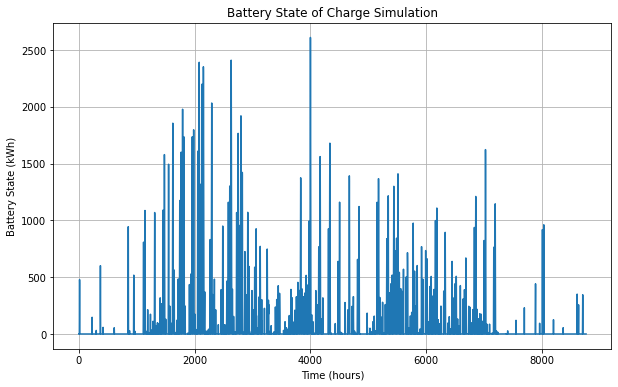

In [86]:
battery_capacity = 5000  # Example: 5 kWh capacity
battery_state = 0
battery_savings = []

# Simulate battery usage for each hour
for production, consumption in zip(results_df['Total Production (€)'], results_df['Net Cost Without Production (€)']):
    net_energy = production - consumption
    if net_energy > 0:
        battery_state = min(battery_capacity, battery_state + net_energy)
    else:
        battery_state = max(0, battery_state + net_energy)
    battery_savings.append(battery_state)

# Plot battery state of charge
plt.figure(figsize=(10, 6))
plt.plot(battery_savings)
plt.title('Battery State of Charge Simulation')
plt.xlabel('Time (hours)')
plt.ylabel('Battery State (kWh)')
plt.grid(True)
plt.savefig(os.path.join(economic_analysis_dir, 'Battery State of Charge Simulation.pdf'))
plt.show()


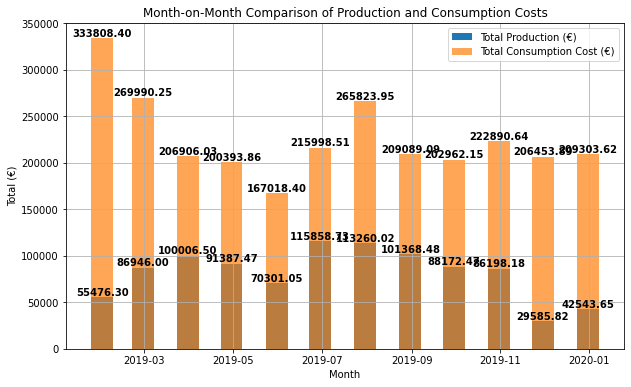

In [87]:
import matplotlib.pyplot as plt

# Group data by month
monthly_production = results_df['Total Production (€)'].resample('M').sum()
monthly_cost = results_df['Net Cost Without Production (€)'].resample('M').sum()

# Set bar width
bar_width = 15  # Adjust the width as needed

# Create the bar plot
plt.figure(figsize=(10, 6))
bars1 = plt.bar(monthly_production.index, monthly_production, width=bar_width, label='Total Production (€)')
bars2 = plt.bar(monthly_cost.index, monthly_cost, width=bar_width, label='Total Consumption Cost (€)', alpha=0.7)

# Add numerical labels on bars
for bar in bars1:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{bar.get_height():.2f}', 
             ha='center', va='bottom', fontsize=10, fontweight='bold')

for bar in bars2:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{bar.get_height():.2f}', 
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# Customize plot
plt.title('Month-on-Month Comparison of Production and Consumption Costs')
plt.xlabel('Month')
plt.ylabel('Total (€)')
plt.legend()
plt.grid(True)

# Save and show the plot
plt.savefig(os.path.join(economic_analysis_dir, 'Month-on-Month Comparison of Production and Consumption Costs.pdf'))
plt.show()


# Plots

### Yearly Plots

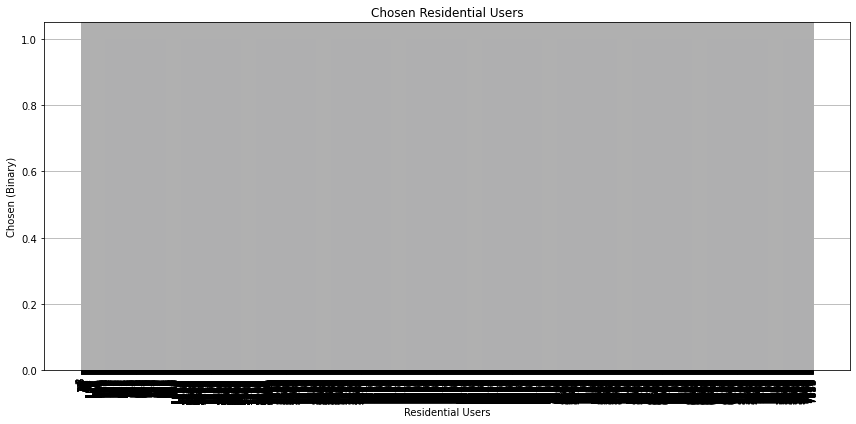

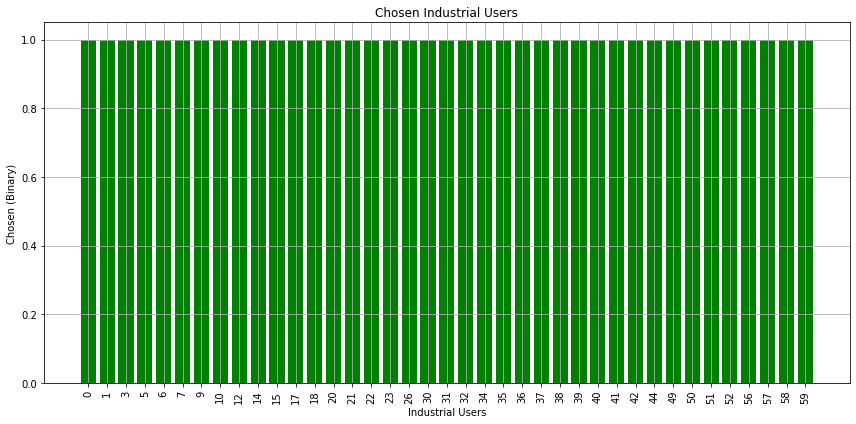

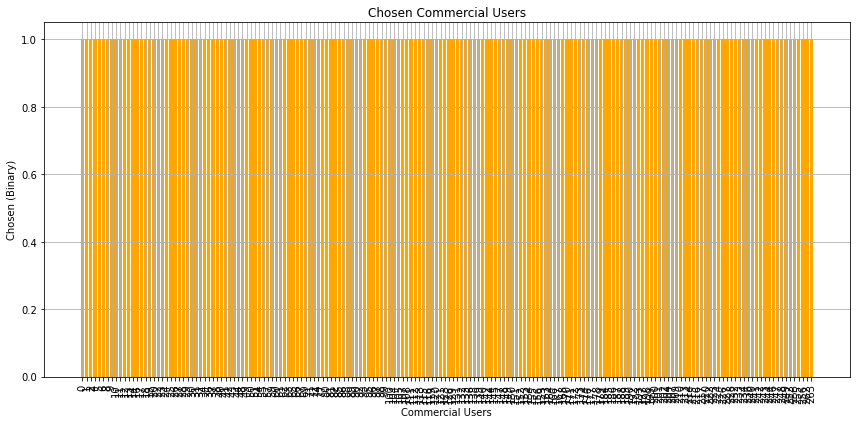

In [88]:
import matplotlib.pyplot as plt

# Convert indices to strings for better readability in plots
chosen_residential.index = chosen_residential.index.astype(str)
chosen_industrial.index = chosen_industrial.index.astype(str)
chosen_commercial.index = chosen_commercial.index.astype(str)

# Plot Chosen Residential Users
plt.figure(figsize=(12, 6))
plt.bar(chosen_residential.index, chosen_residential['Chosen'], color='blue')
plt.xlabel('Residential Users')
plt.ylabel('Chosen (Binary)')
plt.title('Chosen Residential Users')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.tight_layout()  # Adjust layout for better spacing
plt.savefig(os.path.join(results_dir, 'Chosen_Residential_Users.pdf'))
plt.show()

# Plot Chosen Industrial Users
plt.figure(figsize=(12, 6))
plt.bar(chosen_industrial.index, chosen_industrial['Chosen'], color='green')
plt.xlabel('Industrial Users')
plt.ylabel('Chosen (Binary)')
plt.title('Chosen Industrial Users')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.tight_layout()  # Adjust layout for better spacing
plt.savefig(os.path.join(results_dir, 'Chosen_Industrial_Users.pdf'))
plt.show()

# Plot Chosen Commercial Users
plt.figure(figsize=(12, 6))
plt.bar(chosen_commercial.index, chosen_commercial['Chosen'], color='orange')
plt.xlabel('Commercial Users')
plt.ylabel('Chosen (Binary)')
plt.title('Chosen Commercial Users')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.tight_layout()  # Adjust layout for better spacing
plt.savefig(os.path.join(results_dir, 'Chosen_Commercial_Users.pdf'))
plt.show()


### Weekly Plots

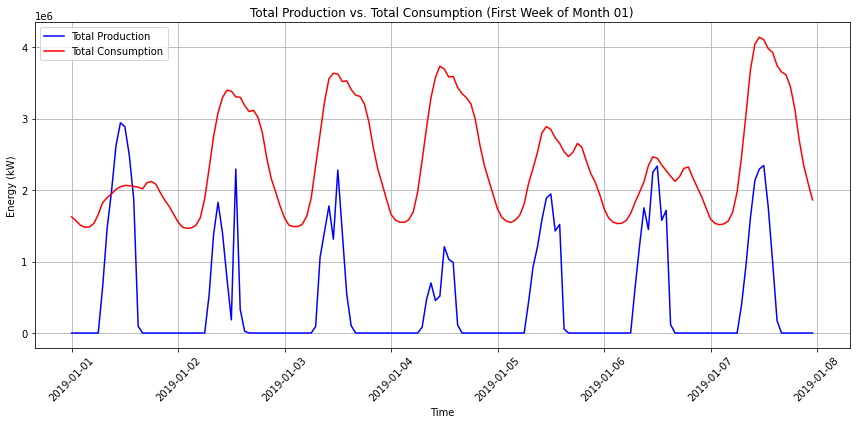

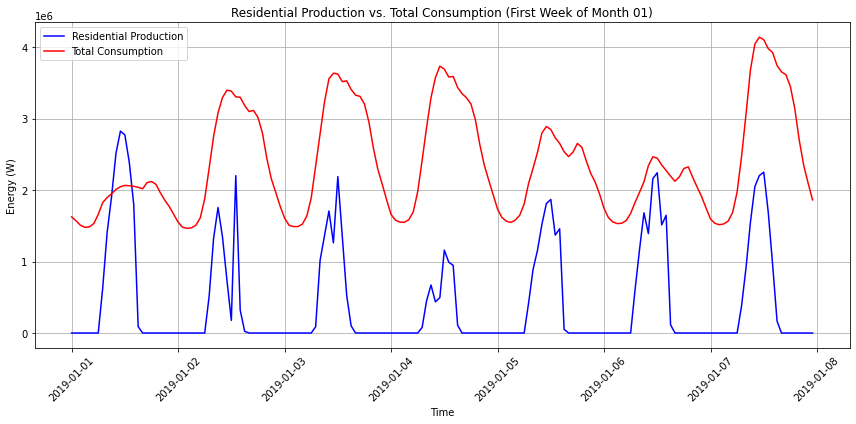

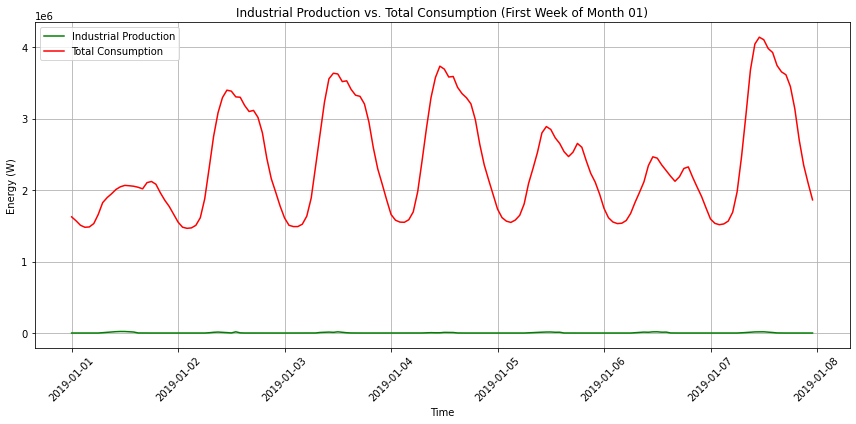

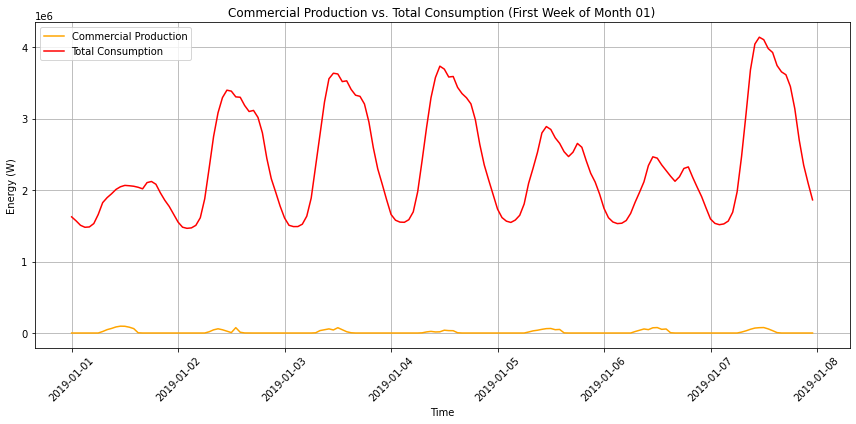

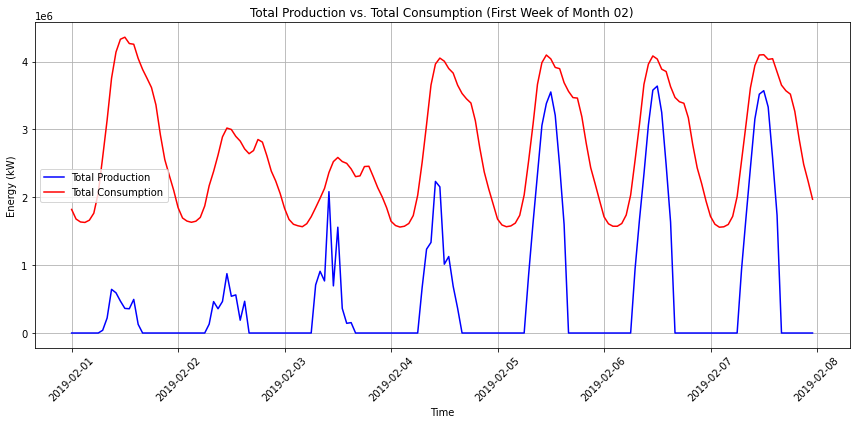

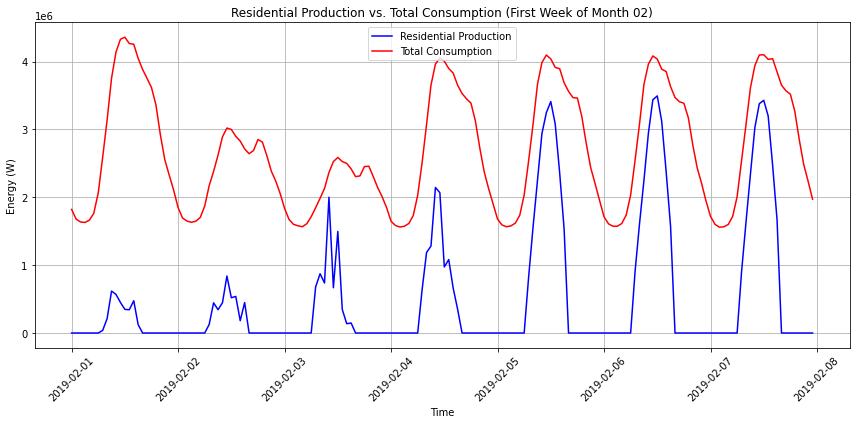

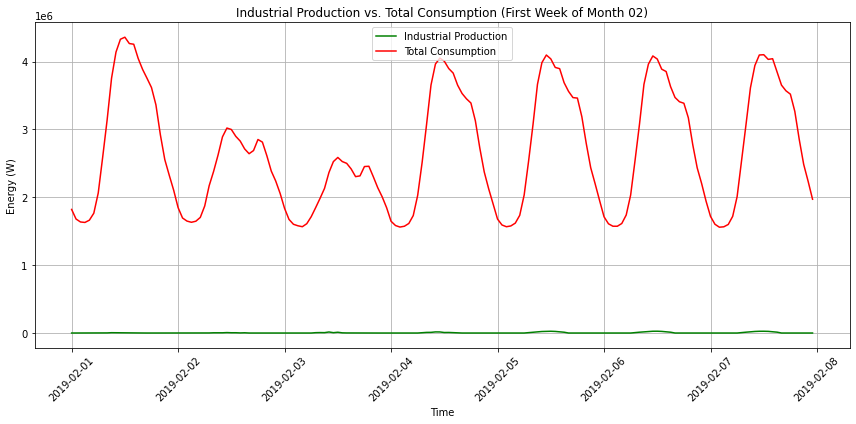

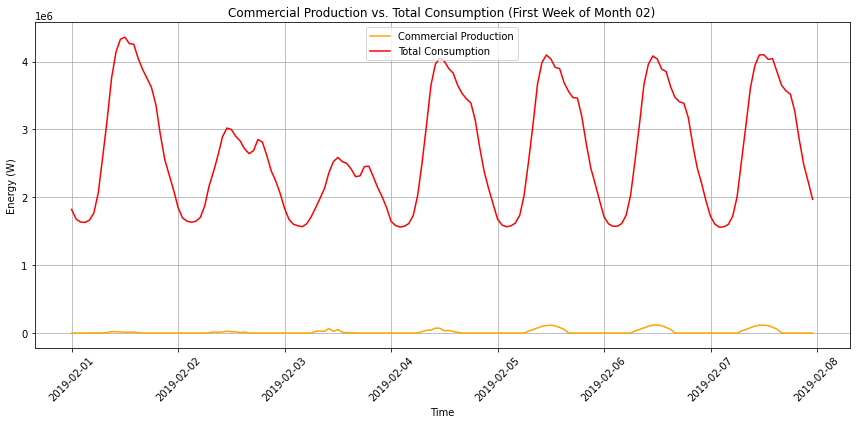

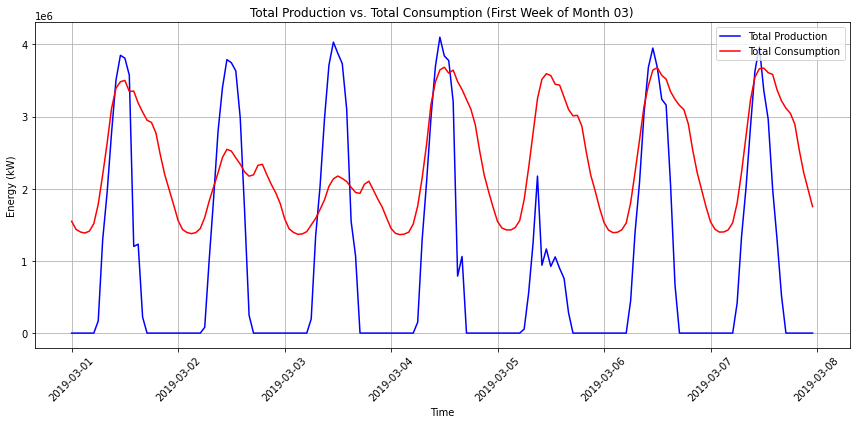

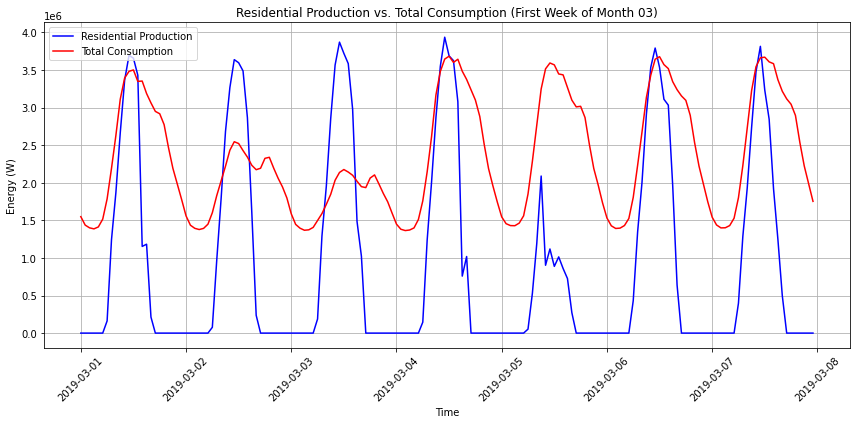

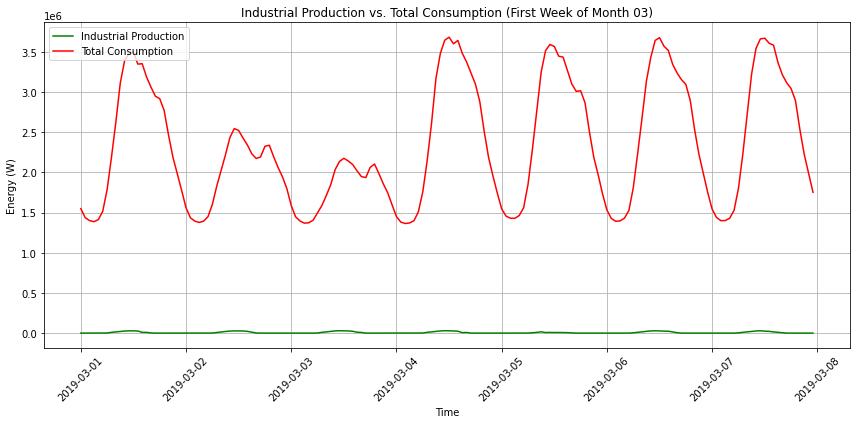

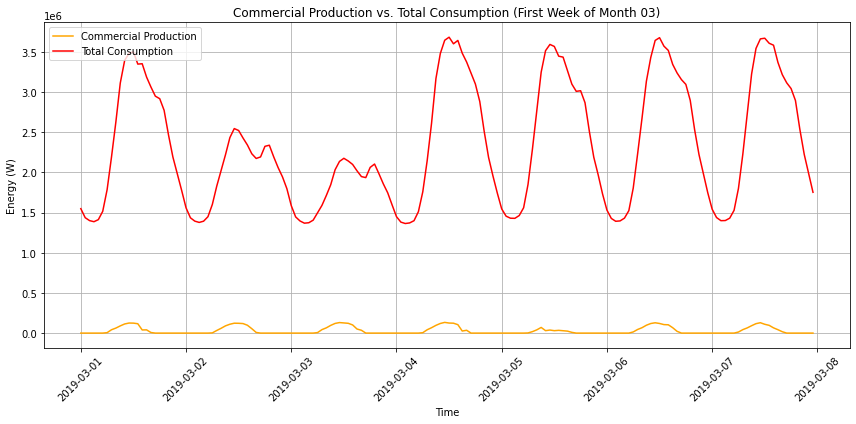

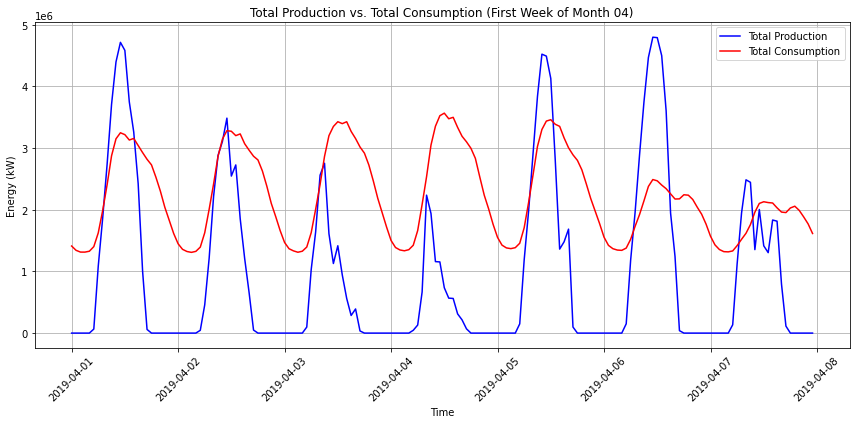

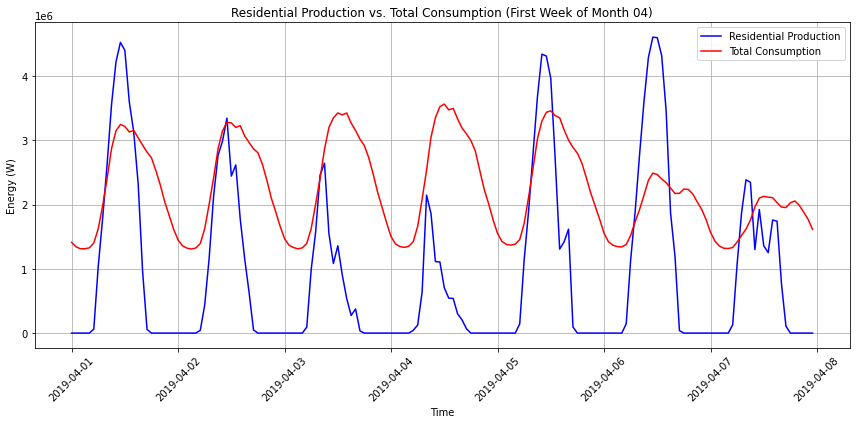

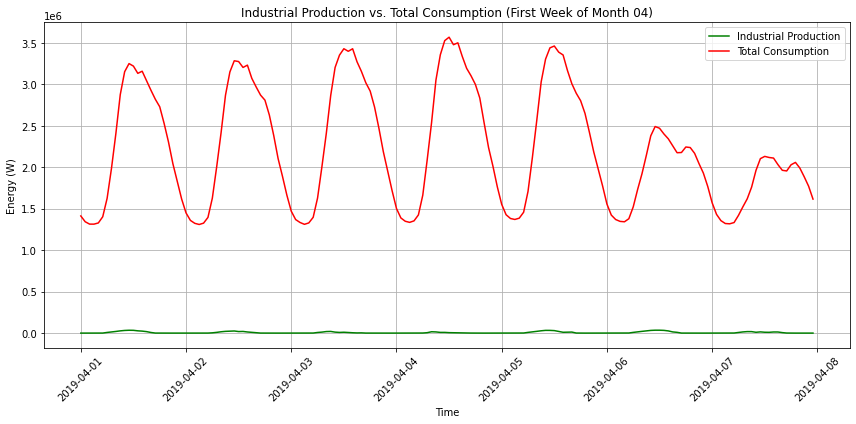

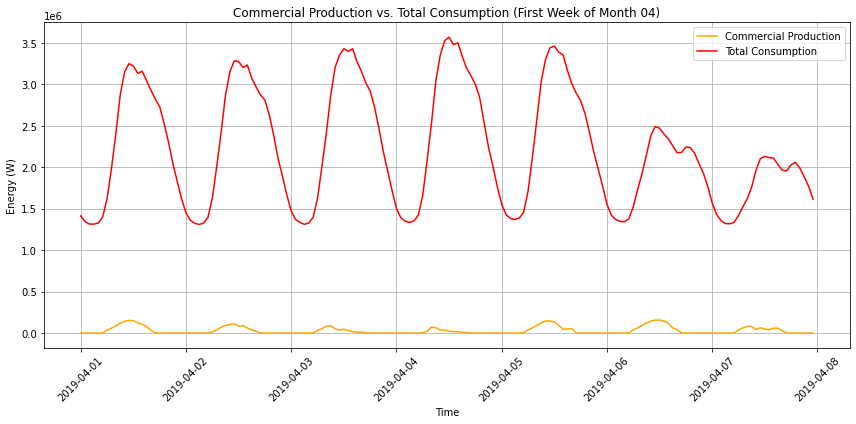

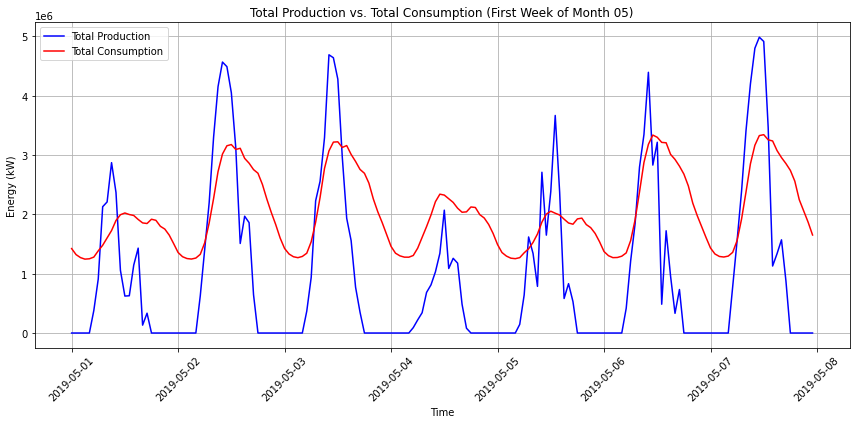

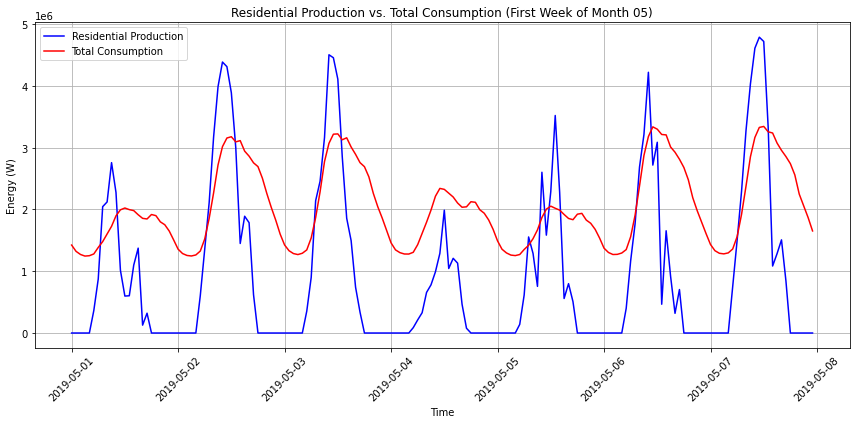

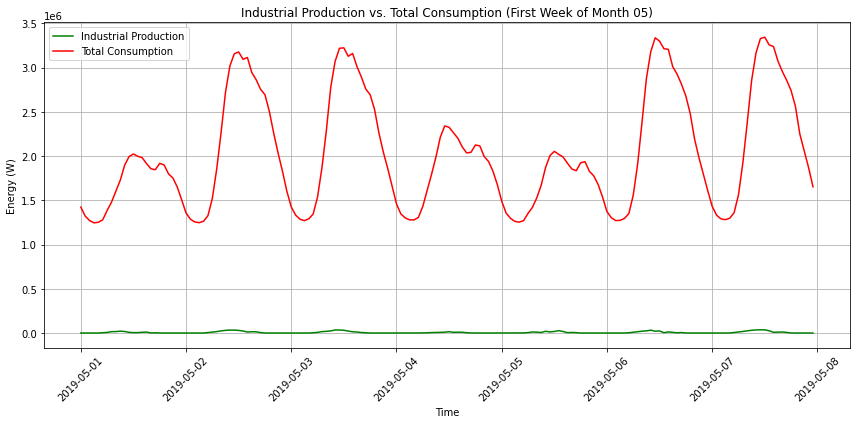

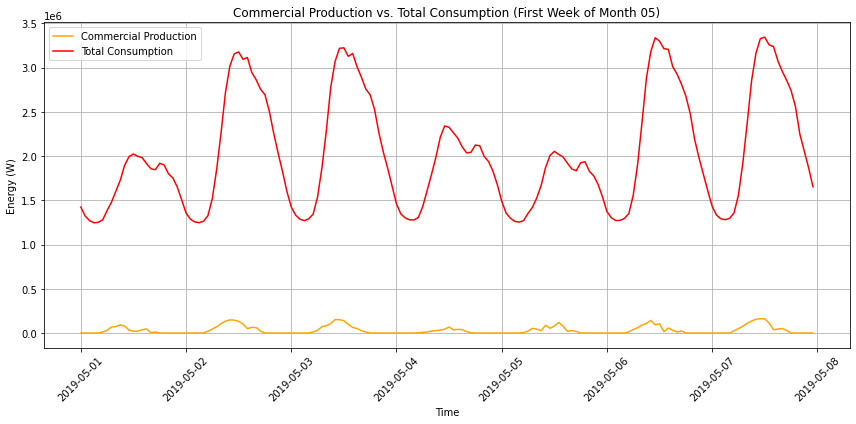

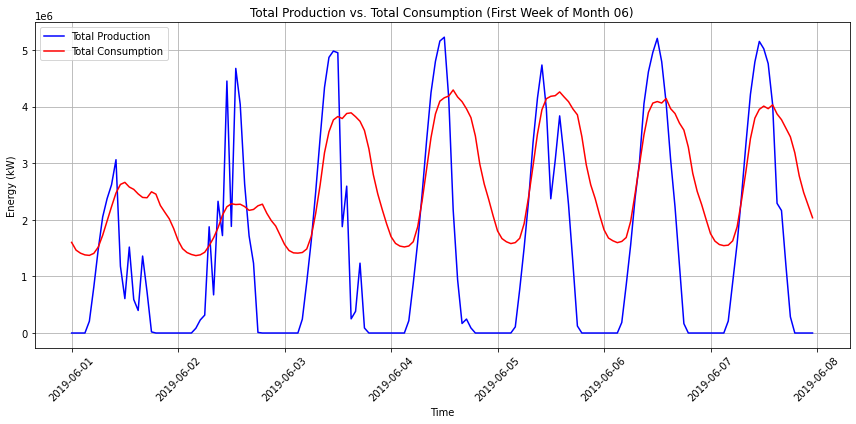

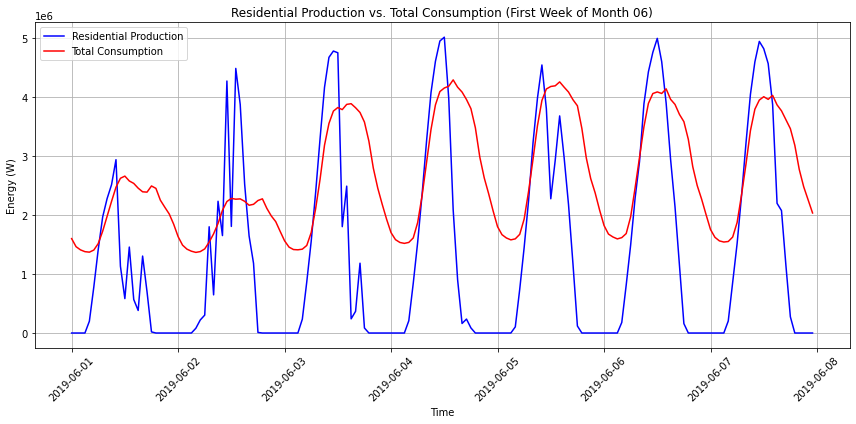

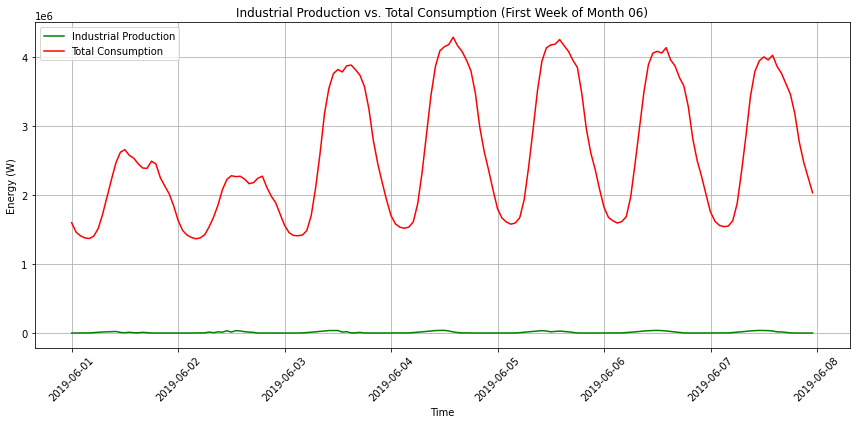

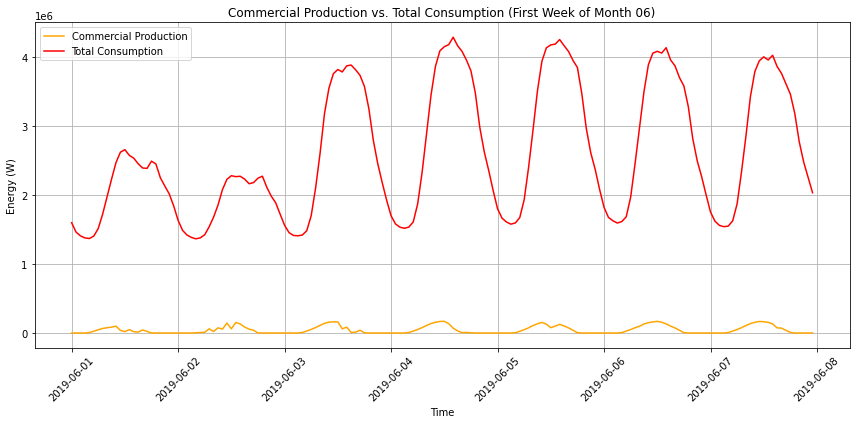

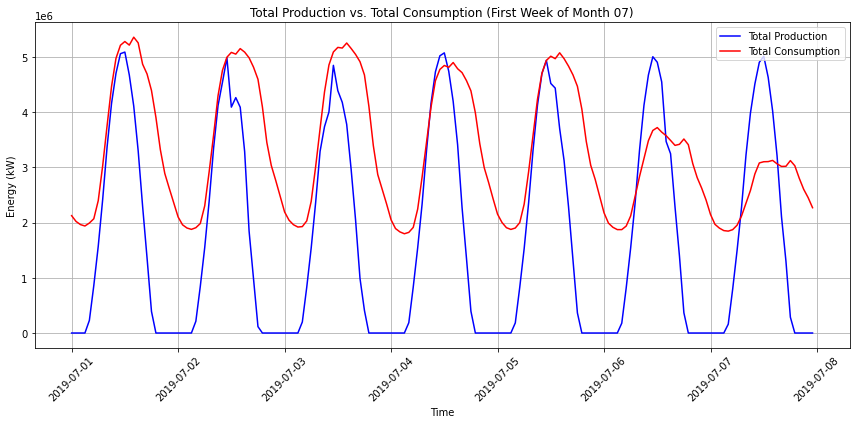

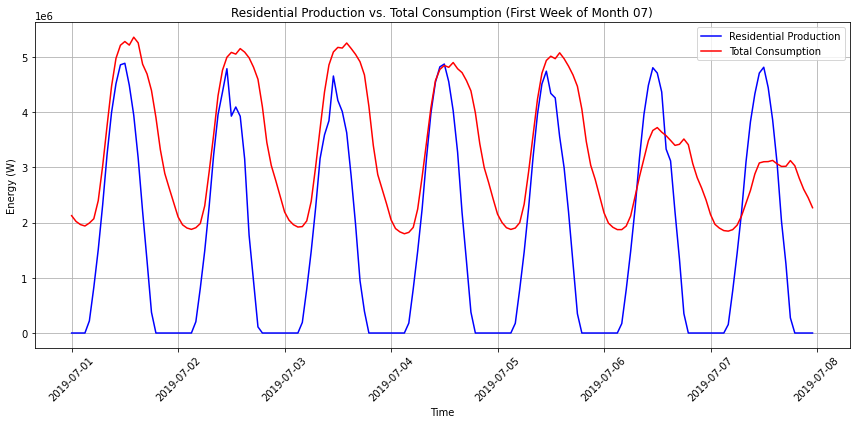

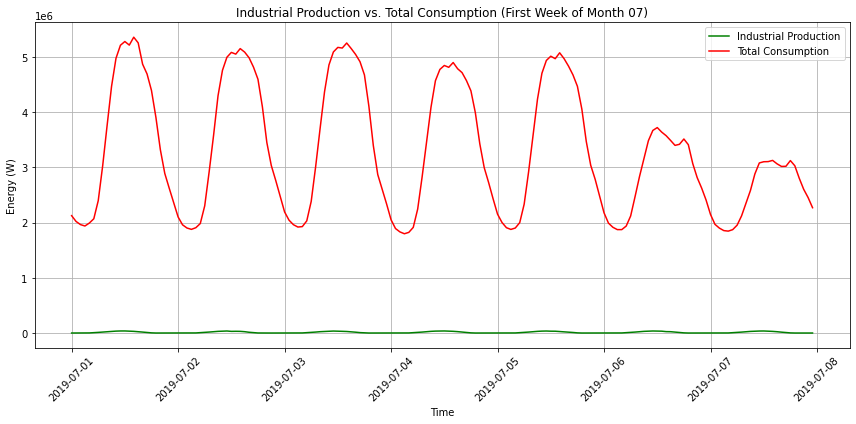

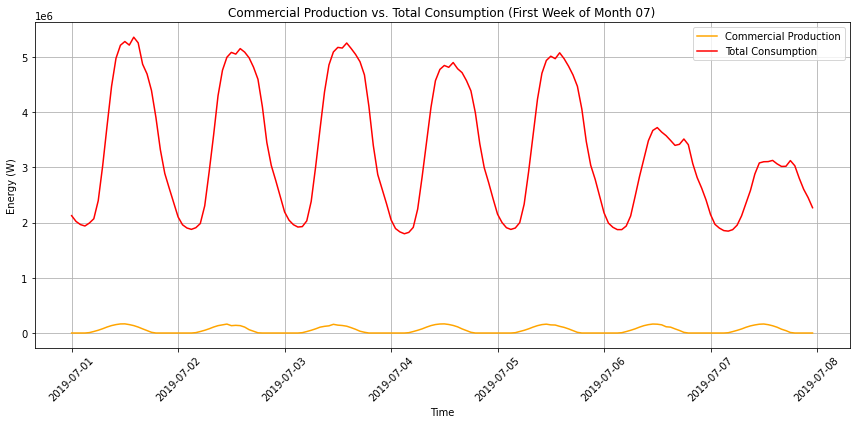

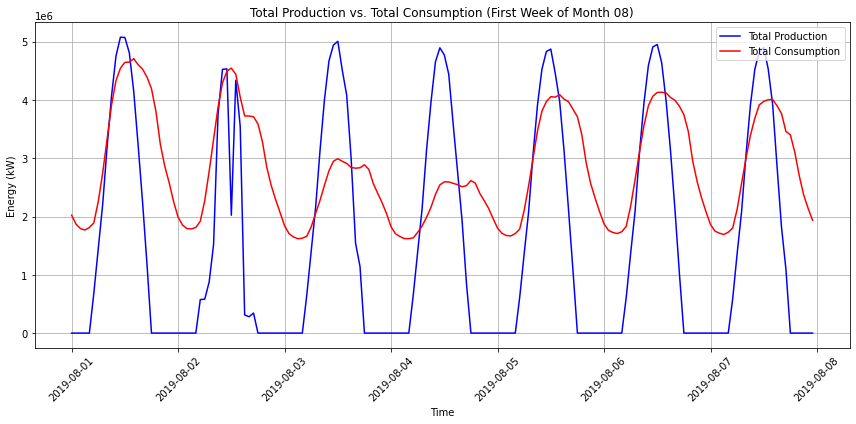

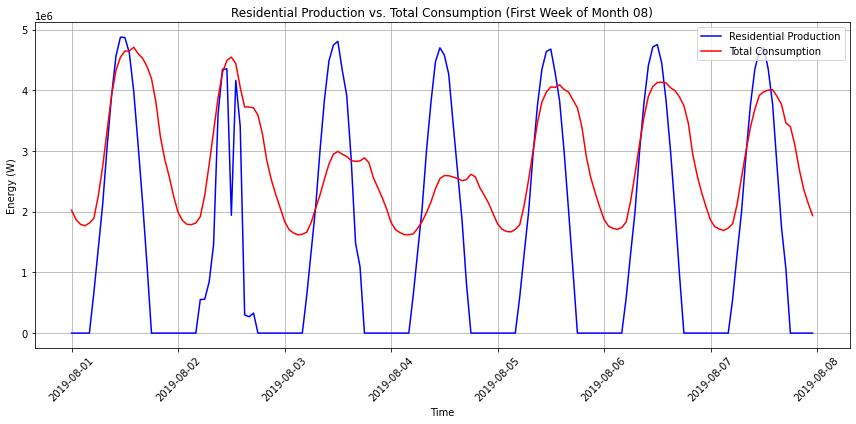

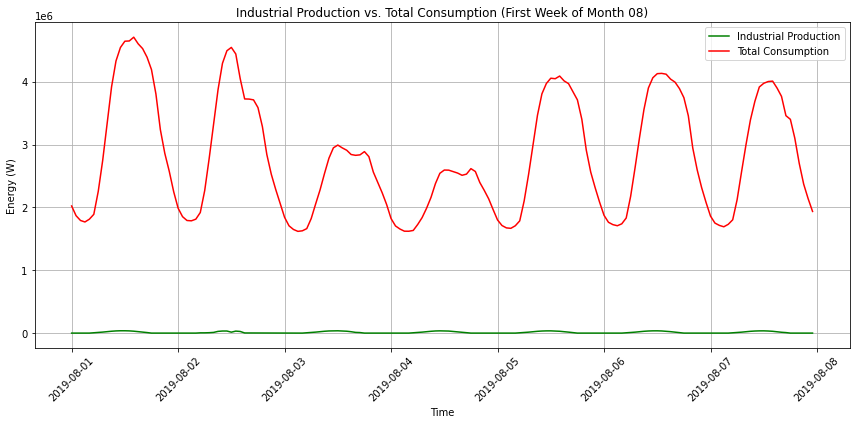

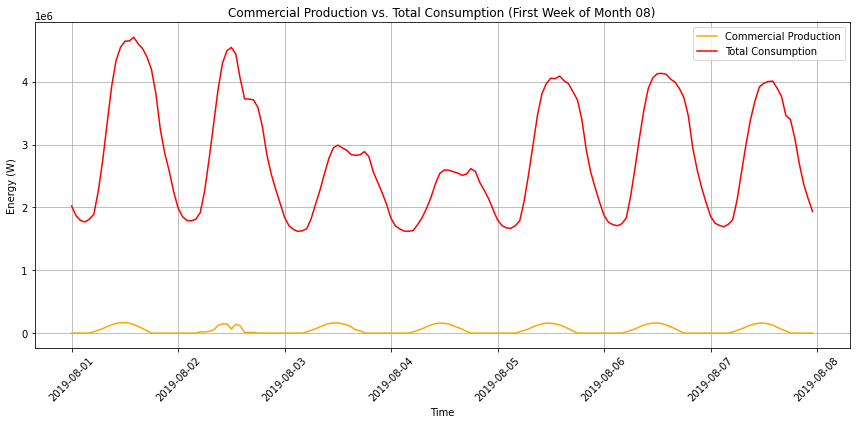

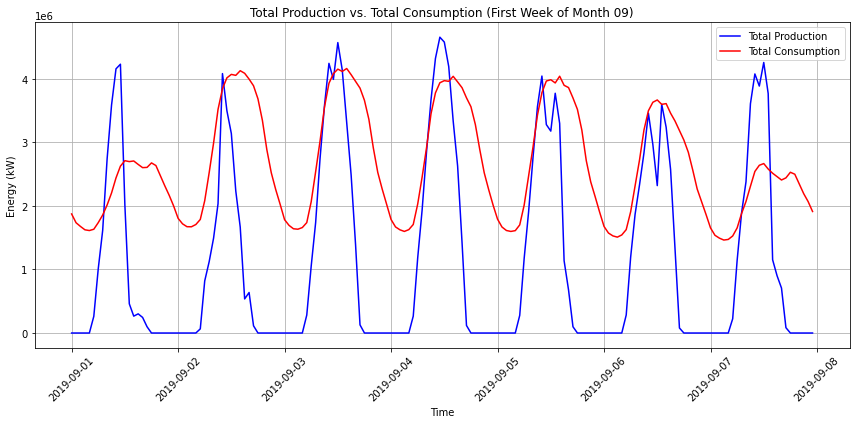

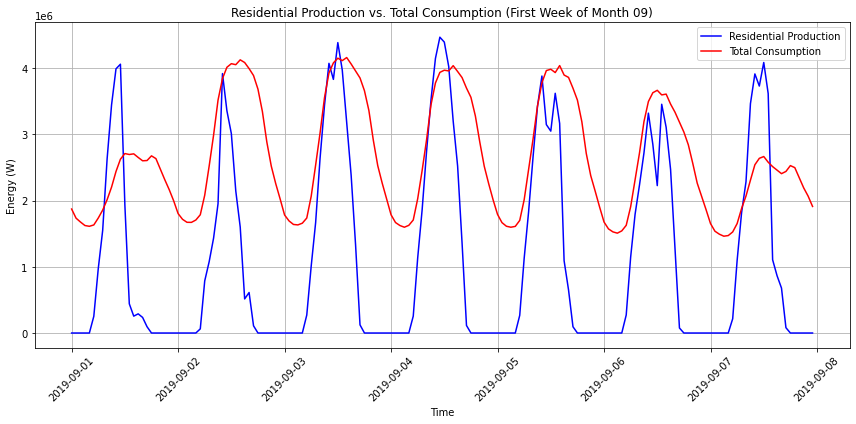

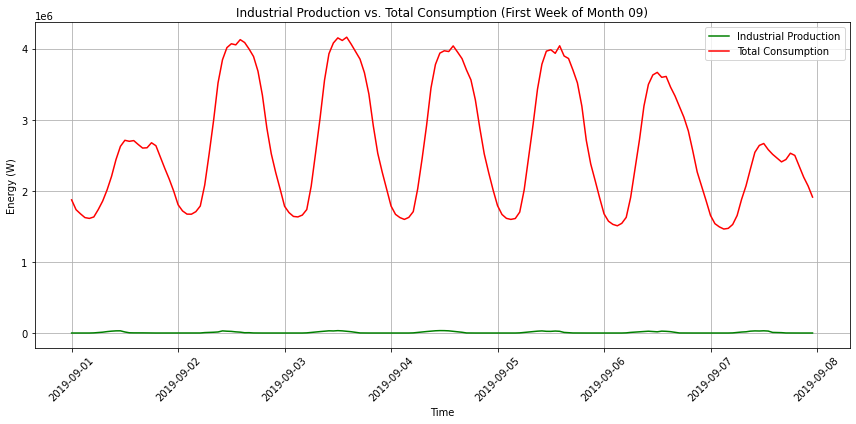

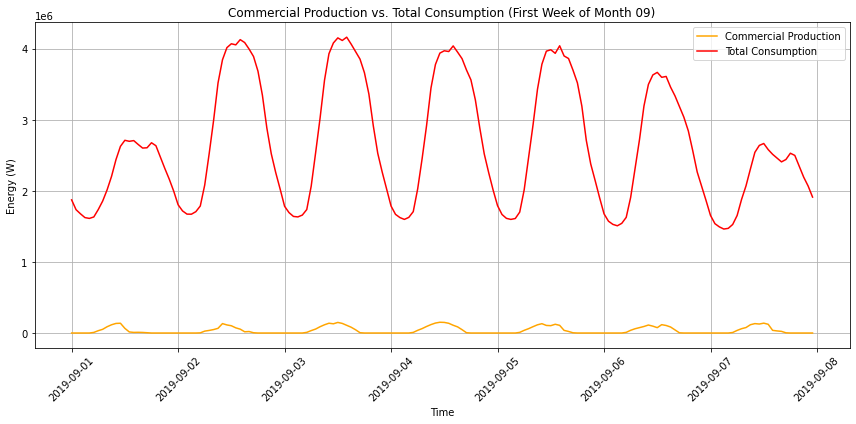

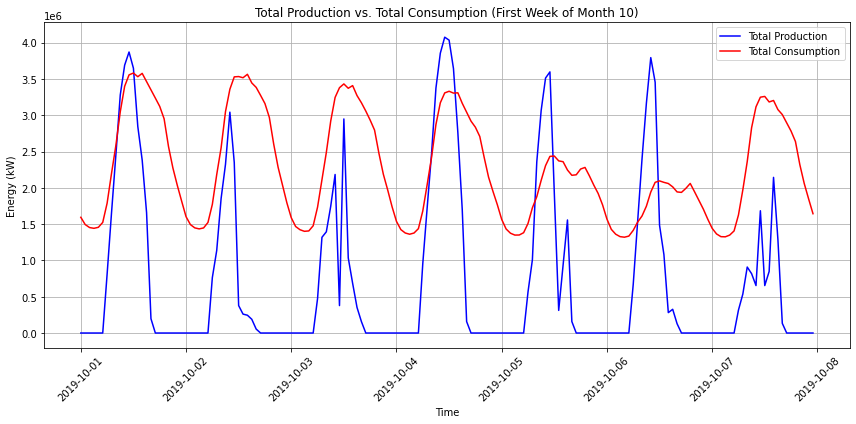

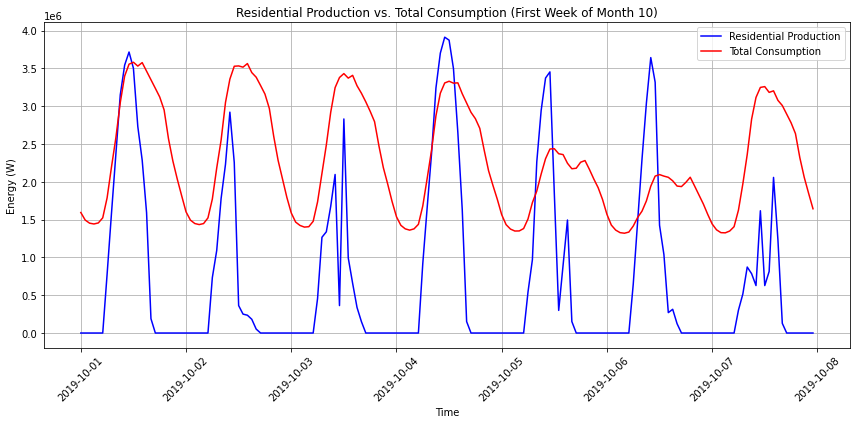

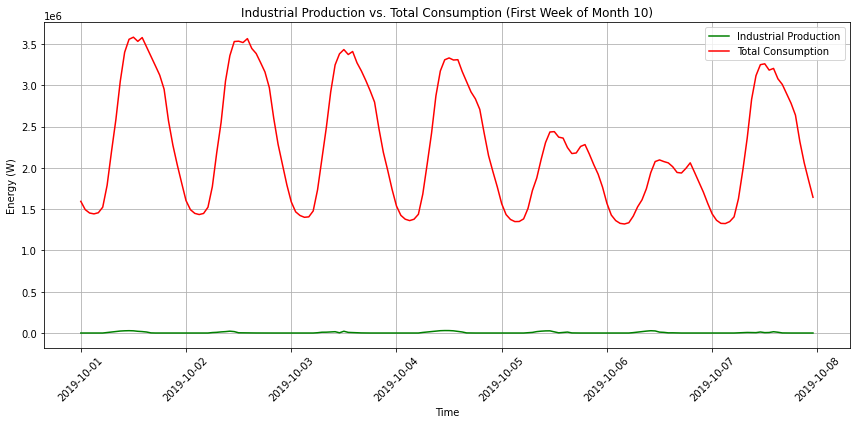

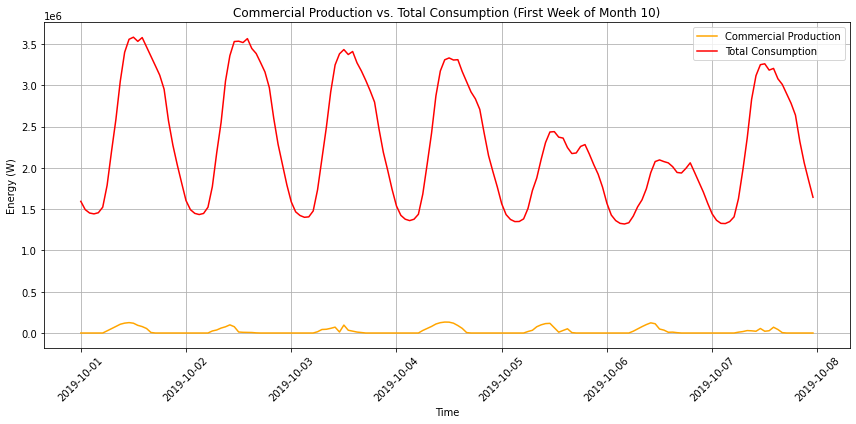

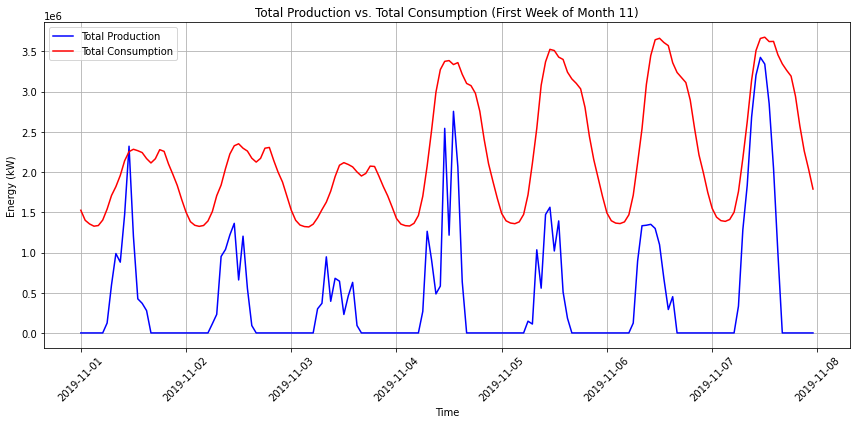

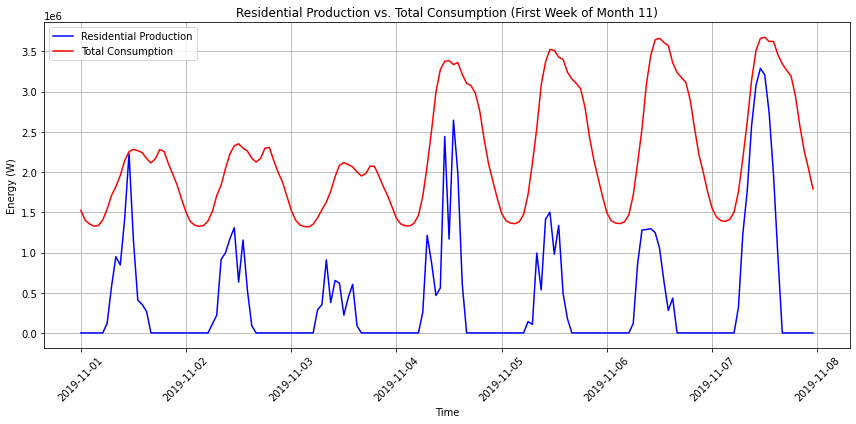

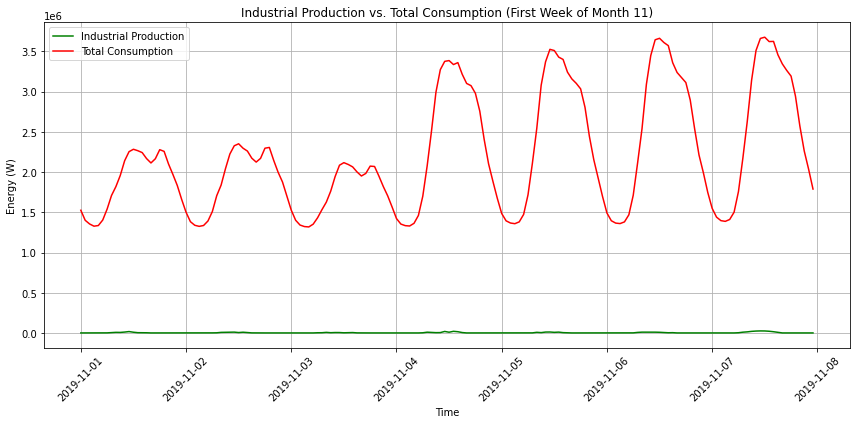

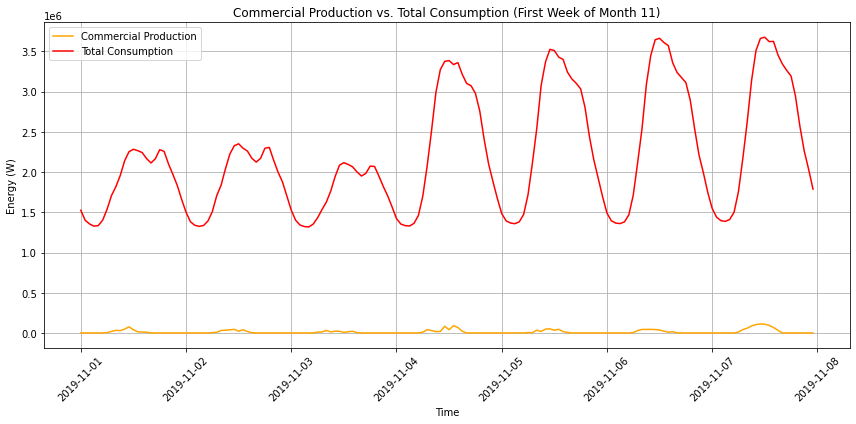

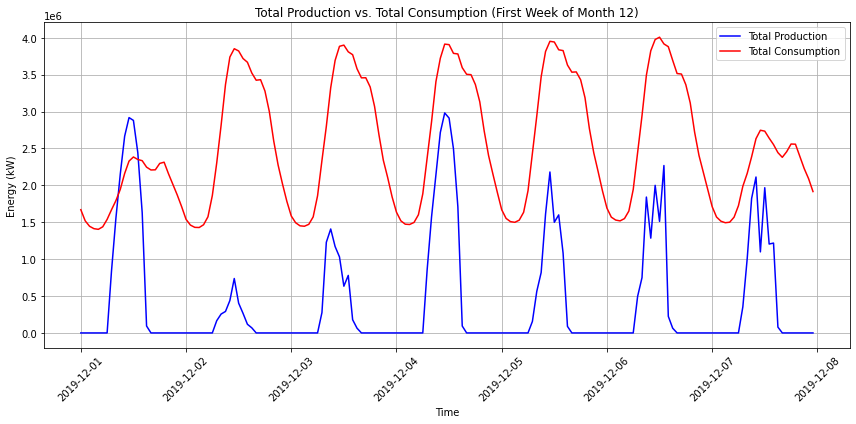

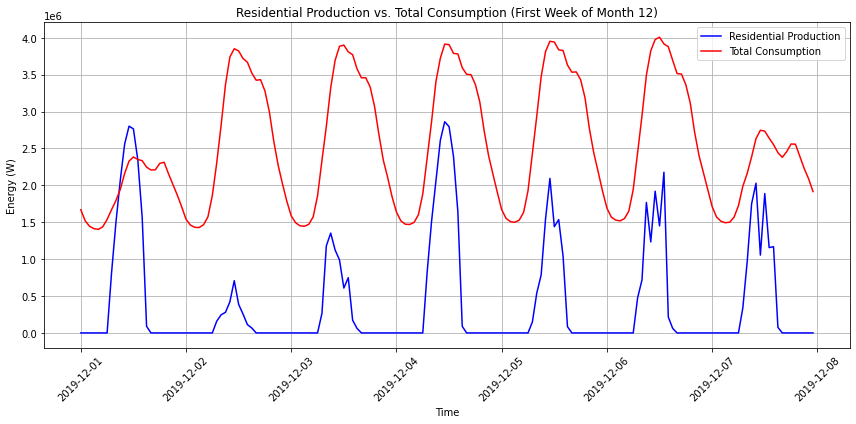

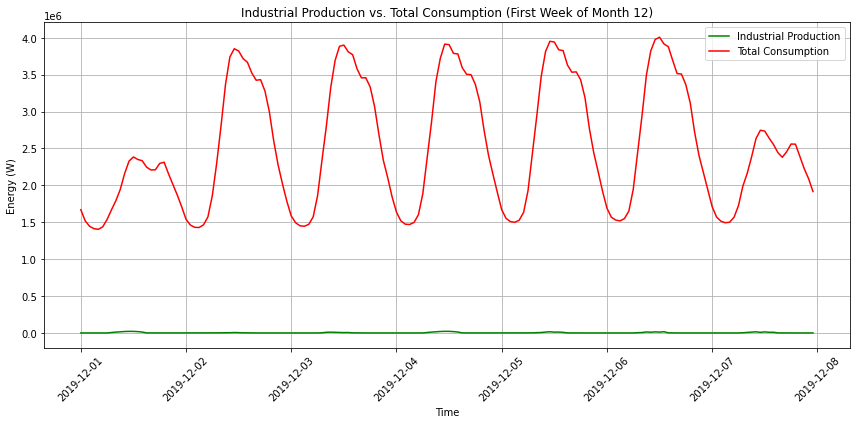

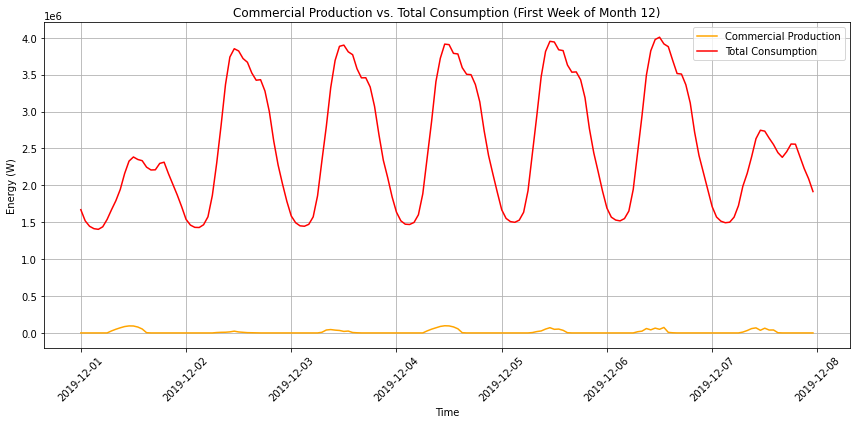

Results saved to C:/Users/Nik/Documents/GitHub/Thesis/Results/Results_Binary/Final Results\2025-02-04_12-50-56_BinaryProduction\Plot\Weekly_Plot\Weekly_Percentage_Results.xlsx and C:/Users/Nik/Documents/GitHub/Thesis/Results/Results_Binary/Final Results\2025-02-04_12-50-56_BinaryProduction\Plot\Weekly_Plot\Weekly_Percentage_Results.csv


In [89]:
# Initialize a dictionary to store the results
weekly_results = {
    'Month': [],
    'F1_Percentage': [],
    'F2_Percentage': [],
    'F3_Percentage': [],
    '10am_to_4pm_Percentage': []
}

# Ensure plot directories exist
os.makedirs(weekly_plot_dir, exist_ok=True)

# Loop through each month to calculate percentages for each period and plot the first week of each month
for month in range(1, 13):
    start_date = f'2019-{month:02d}-01'
    end_date = f'2019-{month:02d}-07'

    # Filter data for the first week of the month
    week_data = DF_Consumption.loc[start_date:end_date]

    # Calculate production for each user type
    week_production_residential = [
        sum(RP_values[user] * Residential_user_production_df.loc[date, user] for user in DF_m2_Residential['full_id']) 
        for date in week_data.index
    ]
    week_production_industrial = [
        sum(IP_values[user] * Industrial_user_production_df.loc[date, user] for user in DF_m2_Industrial['full_id']) 
        for date in week_data.index
    ]
    week_production_commercial = [
        sum(CP_values[user] * Commercial_user_production_df.loc[date, user] for user in DF_m2_Commercial['full_id']) 
        for date in week_data.index
    ]
    week_production_total = [
        week_production_residential[i] + week_production_industrial[i] + week_production_commercial[i] for i in range(len(week_data.index))
    ]

    # Total consumption for the week
    week_consumption_total = week_data['Residential'] * Area_Res_Max + week_data['Industrial'] * Area_Ind_Max + week_data['Commercial'] * Area_Com_Max

    # Convert index to datetime if not already
    week_data.index = pd.to_datetime(week_data.index)

    # Define F1, F2, F3 periods and 10am to 4pm
    F1_mask = (week_data.index.weekday < 5) & (week_data.index.hour >= 8) & (week_data.index.hour < 19)
    F2_mask = ((week_data.index.weekday < 5) & ((week_data.index.hour >= 7) & (week_data.index.hour < 8) | (week_data.index.hour >= 19) & (week_data.index.hour < 23))) | \
              ((week_data.index.weekday == 5) & (week_data.index.hour >= 7) & (week_data.index.hour < 23))
    F3_mask = ((week_data.index.weekday < 6) & (week_data.index.hour >= 23)) | (week_data.index.hour < 7) | (week_data.index.weekday == 6)
    time_10am_4pm_mask = (week_data.index.hour >= 10) & (week_data.index.hour < 16)

    # Calculate total production and consumption for each period
    total_production_F1 = sum([week_production_total[i] for i in range(len(week_data)) if F1_mask[i]])
    total_consumption_F1 = sum([week_consumption_total[i] for i in range(len(week_data)) if F1_mask[i]])
    F1_percentage = (total_production_F1 / total_consumption_F1) * 100 if total_consumption_F1 > 0 else 0

    total_production_F2 = sum([week_production_total[i] for i in range(len(week_data)) if F2_mask[i]])
    total_consumption_F2 = sum([week_consumption_total[i] for i in range(len(week_data)) if F2_mask[i]])
    F2_percentage = (total_production_F2 / total_consumption_F2) * 100 if total_consumption_F2 > 0 else 0

    total_production_F3 = sum([week_production_total[i] for i in range(len(week_data)) if F3_mask[i]])
    total_consumption_F3 = sum([week_consumption_total[i] for i in range(len(week_data)) if F3_mask[i]])
    F3_percentage = (total_production_F3 / total_consumption_F3) * 100 if total_consumption_F3 > 0 else 0

    total_production_10am_4pm = sum([week_production_total[i] for i in range(len(week_data)) if time_10am_4pm_mask[i]])
    total_consumption_10am_4pm = sum([week_consumption_total[i] for i in range(len(week_data)) if time_10am_4pm_mask[i]])
    percentage_10am_4pm = (total_production_10am_4pm / total_consumption_10am_4pm) * 100 if total_consumption_10am_4pm > 0 else 0

    # Append results for each month
    weekly_results['Month'].append(month)
    weekly_results['F1_Percentage'].append(F1_percentage)
    weekly_results['F2_Percentage'].append(F2_percentage)
    weekly_results['F3_Percentage'].append(F3_percentage)
    weekly_results['10am_to_4pm_Percentage'].append(percentage_10am_4pm)

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(week_data.index, week_production_total, label='Total Production', color='blue')
    plt.plot(week_data.index, week_consumption_total, label='Total Consumption', color='red')
    plt.xlabel('Time')
    plt.ylabel('Energy (kW)')
    plt.title(f'Total Production vs. Total Consumption (First Week of Month {month:02d})')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(os.path.join(weekly_plot_dir, f'Total_Production_vs_Total_Consumption_Week_{month:02d}.pdf'))
    plt.show()

    # Plot for each user type
    for label, production, color in zip(
        ['Residential', 'Industrial', 'Commercial'], 
        [week_production_residential, week_production_industrial, week_production_commercial], 
        ['blue', 'green', 'orange']
    ):
        plt.figure(figsize=(12, 6))
        plt.plot(week_data.index, production, label=f'{label} Production', color=color)
        plt.plot(week_data.index, week_consumption_total, label='Total Consumption', color='red')
        plt.xlabel('Time')
        plt.ylabel('Energy (W)')
        plt.title(f'{label} Production vs. Total Consumption (First Week of Month {month:02d})')
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig(os.path.join(weekly_plot_dir, f'{label}_Production_vs_Total_Consumption_Week_{month:02d}.pdf'))
        plt.show()

# Convert results to DataFrame
weekly_results_df = pd.DataFrame(weekly_results)

# Save the results to Excel and CSV
output_file_path_excel = os.path.join(weekly_plot_dir, 'Weekly_Percentage_Results.xlsx')
output_file_path_csv = os.path.join(weekly_plot_dir, 'Weekly_Percentage_Results.csv')

weekly_results_df.to_excel(output_file_path_excel, index=False)
weekly_results_df.to_csv(output_file_path_csv, index=False)

print(f'Results saved to {output_file_path_excel} and {output_file_path_csv}')


### Daily Plots

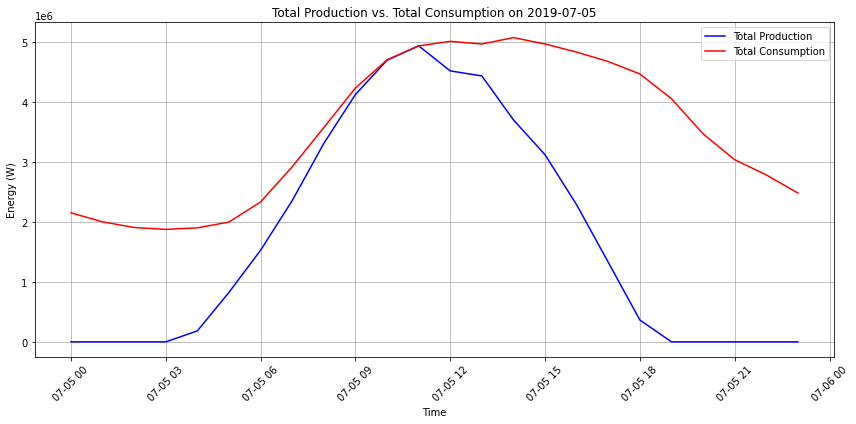

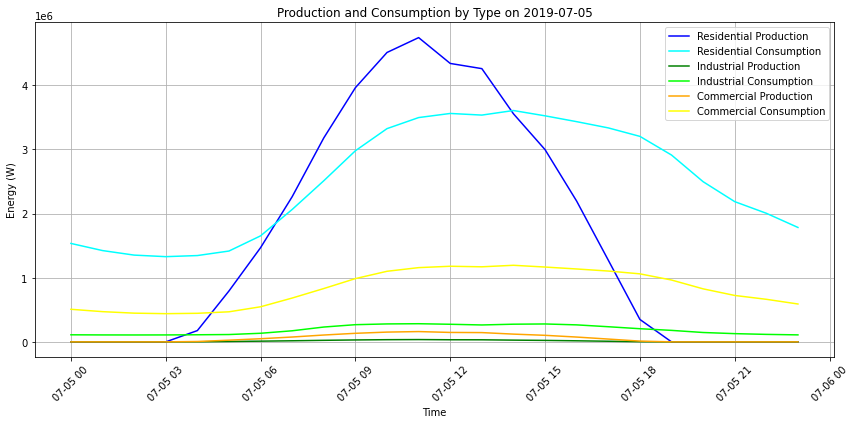

In [90]:
# Define the specific day for the detailed plot
specific_day_str = '2019-07-05'

# Filter data for the specific day
specific_day_data_residential = Residential_user_production_df.loc[Residential_user_production_df.index.strftime('%Y-%m-%d') == specific_day_str]
specific_day_data_industrial = Industrial_user_production_df.loc[Industrial_user_production_df.index.strftime('%Y-%m-%d') == specific_day_str]
specific_day_data_commercial = Commercial_user_production_df.loc[Commercial_user_production_df.index.strftime('%Y-%m-%d') == specific_day_str]

# Filter consumption data for the specific day
specific_day_consumption = DF_Consumption.loc[DF_Consumption.index.strftime('%Y-%m-%d') == specific_day_str]

# Calculate production data for the specific day
specific_day_production_residential = specific_day_data_residential.apply(
    lambda col: sum(RP_values[user] * col[user] for user in DF_m2_Residential['full_id']), axis=1)
specific_day_production_industrial = specific_day_data_industrial.apply(
    lambda col: sum(IP_values[user] * col[user] for user in DF_m2_Industrial['full_id']), axis=1)
specific_day_production_commercial = specific_day_data_commercial.apply(
    lambda col: sum(CP_values[user] * col[user] for user in DF_m2_Commercial['full_id']), axis=1)

# Calculate total production for the specific day
total_specific_day_production = specific_day_production_residential + specific_day_production_industrial + specific_day_production_commercial

# Calculate total consumption for the specific day
total_specific_day_consumption = (
    specific_day_consumption['Residential'] * Area_Res_Max + 
    specific_day_consumption['Industrial'] * Area_Ind_Max + 
    specific_day_consumption['Commercial'] * Area_Com_Max
)

# Plot total production vs total consumption for the specific day
plt.figure(figsize=(12, 6))
plt.plot(specific_day_data_residential.index, total_specific_day_production, label='Total Production', color='blue')
plt.plot(specific_day_consumption.index, total_specific_day_consumption, label='Total Consumption', color='red')
plt.xlabel('Time')
plt.ylabel('Energy (W)')
plt.title(f'Total Production vs. Total Consumption on {specific_day_str}')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(yearly_plot_dir, f'Total_Production_vs_Consumption_{specific_day_str}.pdf'))
plt.show()

# Plot production vs consumption for each type for the specific day
plt.figure(figsize=(12, 6))
plt.plot(specific_day_data_residential.index, specific_day_production_residential, label='Residential Production', color='blue')
plt.plot(specific_day_consumption.index, specific_day_consumption['Residential'] * Area_Res_Max, label='Residential Consumption', color='cyan')
plt.plot(specific_day_data_industrial.index, specific_day_production_industrial, label='Industrial Production', color='green')
plt.plot(specific_day_consumption.index, specific_day_consumption['Industrial'] * Area_Ind_Max, label='Industrial Consumption', color='lime')
plt.plot(specific_day_data_commercial.index, specific_day_production_commercial, label='Commercial Production', color='orange')
plt.plot(specific_day_consumption.index, specific_day_consumption['Commercial'] * Area_Com_Max, label='Commercial Consumption', color='yellow')
plt.xlabel('Time')
plt.ylabel('Energy (W)')
plt.title(f'Production and Consumption by Type on {specific_day_str}')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(yearly_plot_dir, f'Production_vs_Consumption_By_Type_{specific_day_str}.pdf'))
plt.show()



Peak Analysis for Total Production and Consumption:
Peak Production: 8148443.46 W at 2019-06-30 11:00:00
Peak Consumption: 5550884.00 W at 2019-06-28 12:00:00


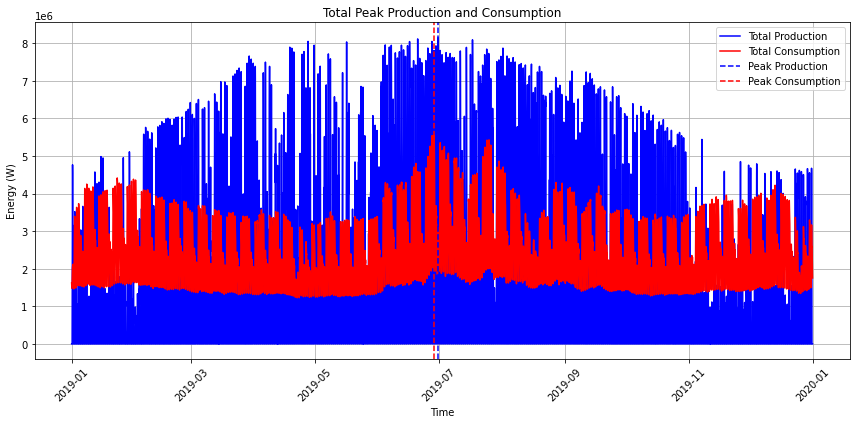

C:\Users\Nik\AppData\Local\Temp/ipykernel_10848/4040539468.py:64: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = daily_surplus_deficit.pivot('Date', 'Hour', 0)


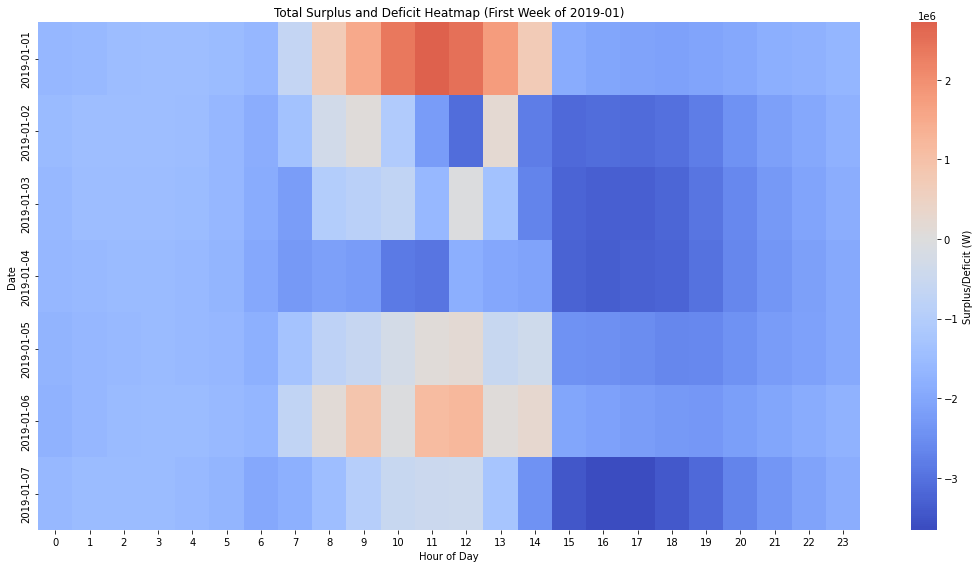

C:\Users\Nik\AppData\Local\Temp/ipykernel_10848/4040539468.py:64: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = daily_surplus_deficit.pivot('Date', 'Hour', 0)


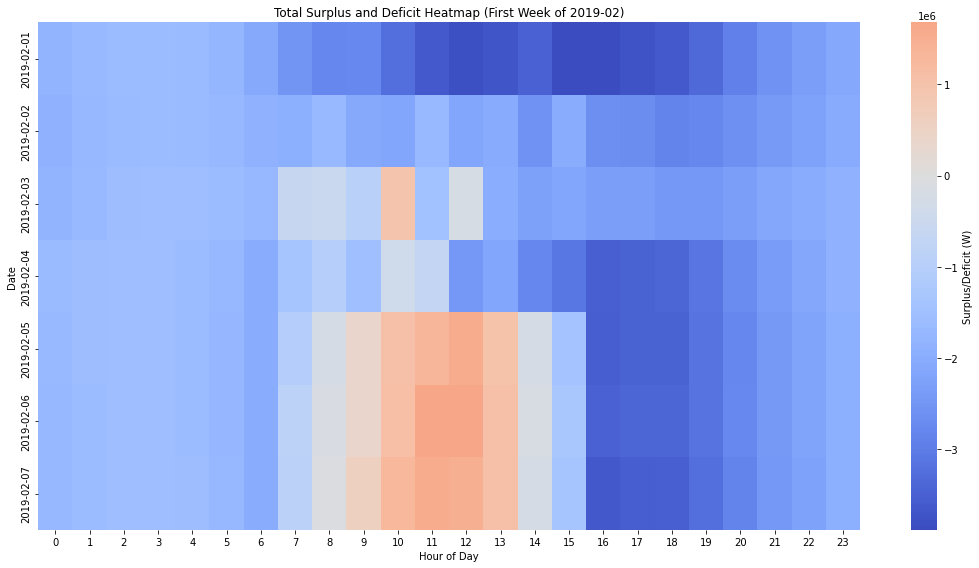

C:\Users\Nik\AppData\Local\Temp/ipykernel_10848/4040539468.py:64: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = daily_surplus_deficit.pivot('Date', 'Hour', 0)


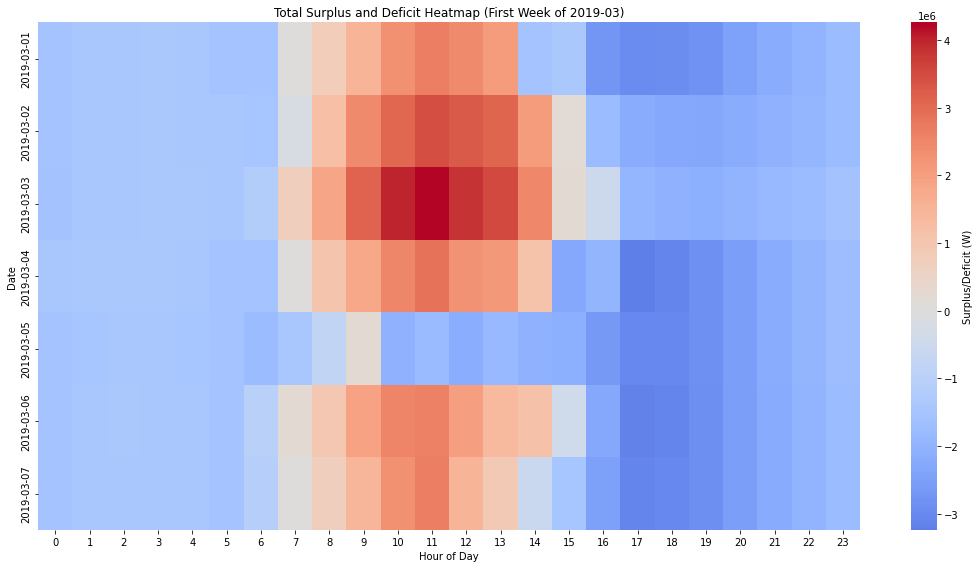

C:\Users\Nik\AppData\Local\Temp/ipykernel_10848/4040539468.py:64: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = daily_surplus_deficit.pivot('Date', 'Hour', 0)


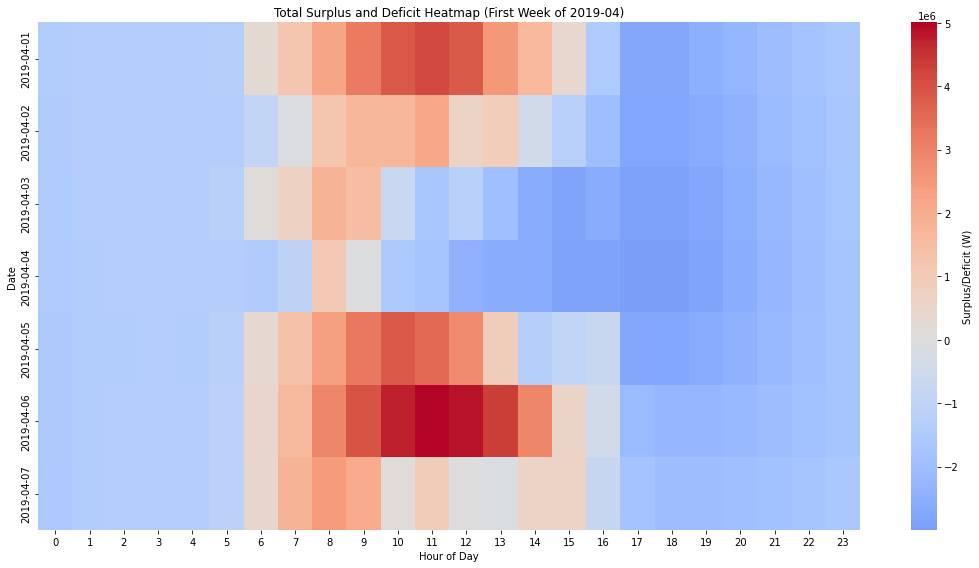

C:\Users\Nik\AppData\Local\Temp/ipykernel_10848/4040539468.py:64: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = daily_surplus_deficit.pivot('Date', 'Hour', 0)


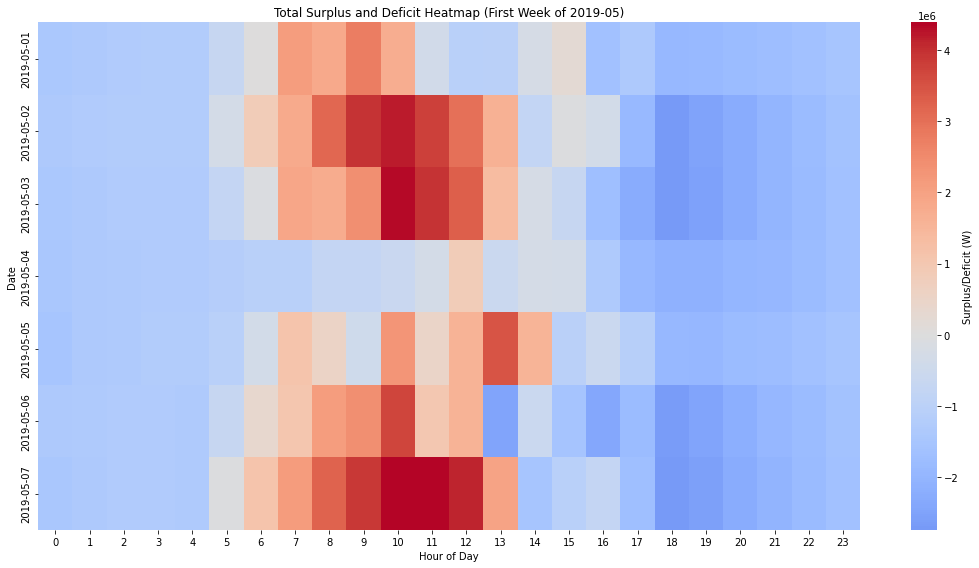

C:\Users\Nik\AppData\Local\Temp/ipykernel_10848/4040539468.py:64: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = daily_surplus_deficit.pivot('Date', 'Hour', 0)


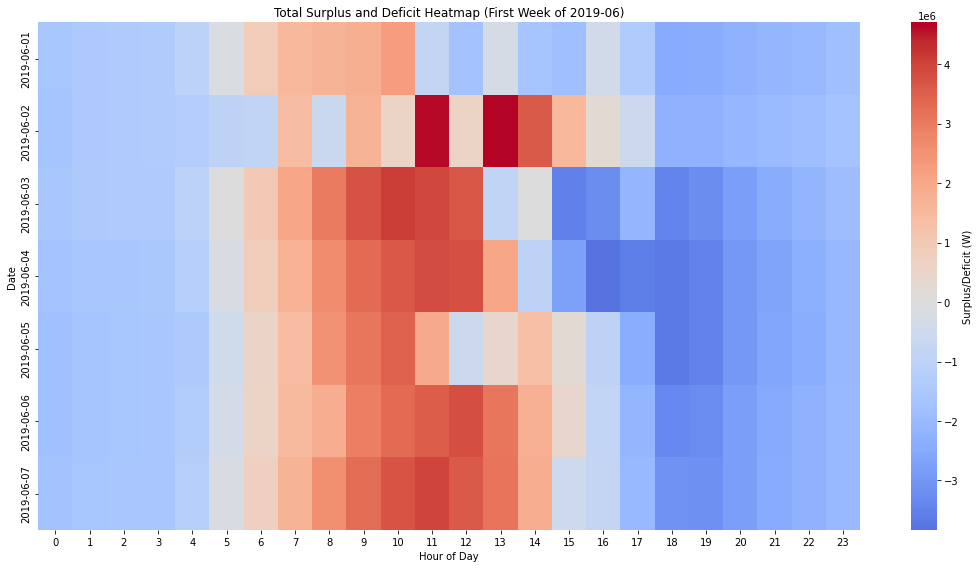

C:\Users\Nik\AppData\Local\Temp/ipykernel_10848/4040539468.py:64: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = daily_surplus_deficit.pivot('Date', 'Hour', 0)


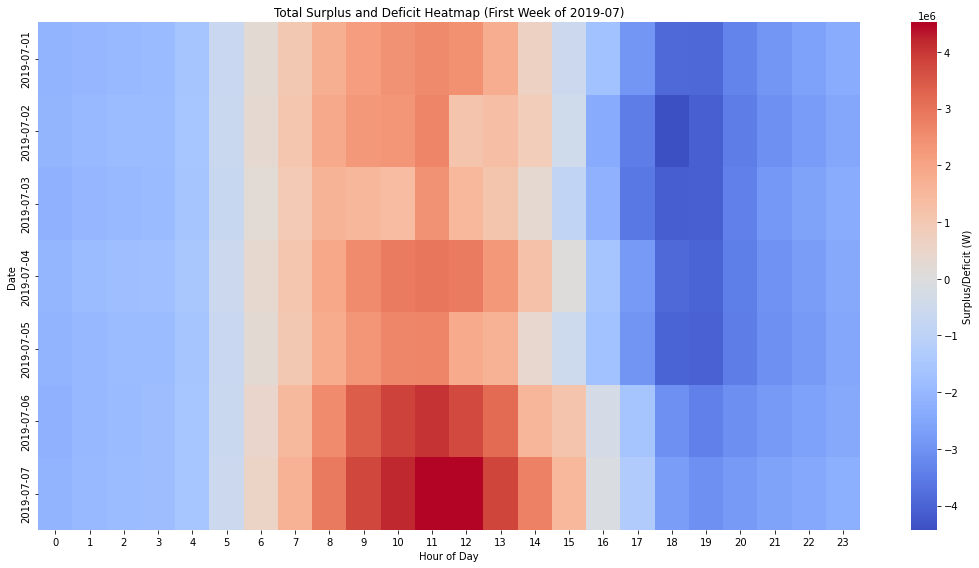

C:\Users\Nik\AppData\Local\Temp/ipykernel_10848/4040539468.py:64: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = daily_surplus_deficit.pivot('Date', 'Hour', 0)


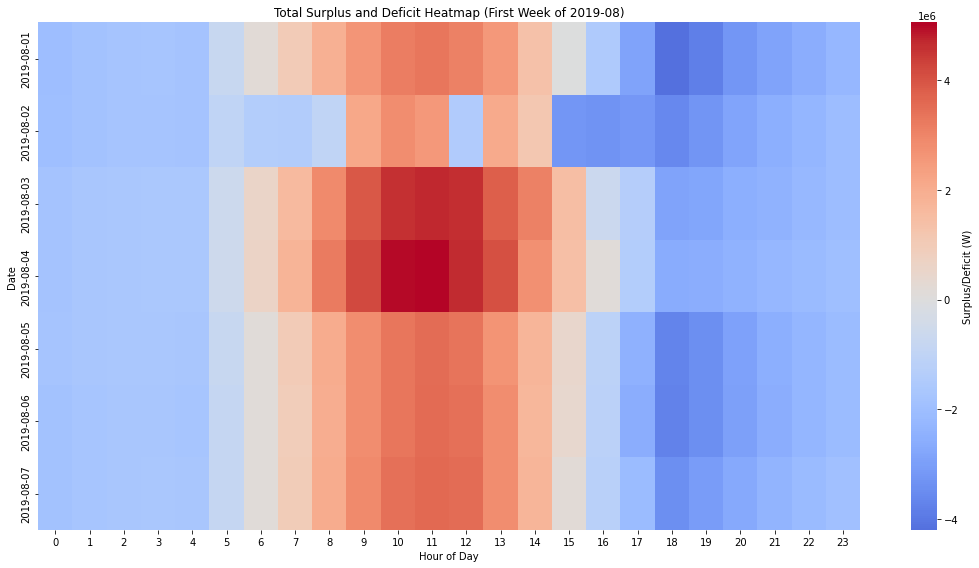

C:\Users\Nik\AppData\Local\Temp/ipykernel_10848/4040539468.py:64: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = daily_surplus_deficit.pivot('Date', 'Hour', 0)


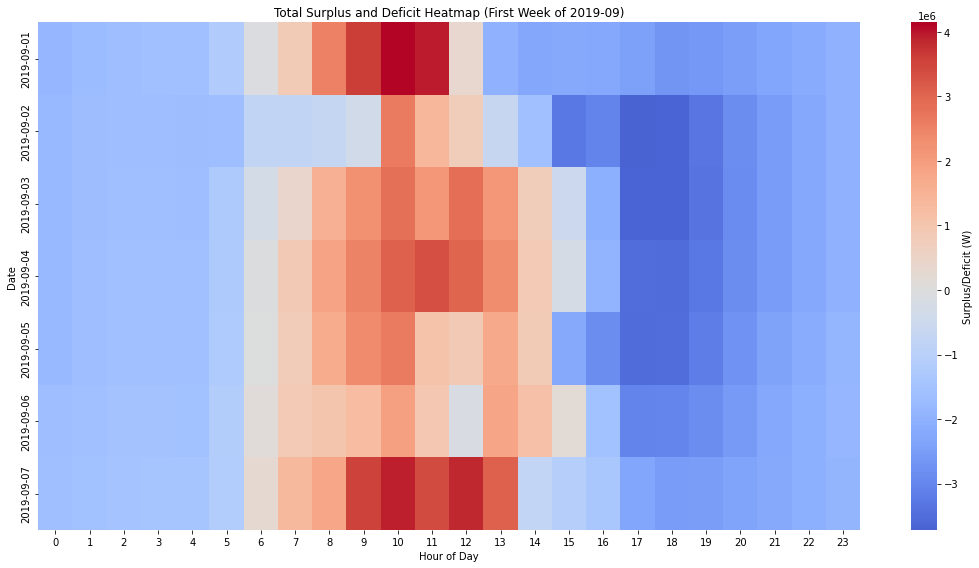

C:\Users\Nik\AppData\Local\Temp/ipykernel_10848/4040539468.py:64: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = daily_surplus_deficit.pivot('Date', 'Hour', 0)


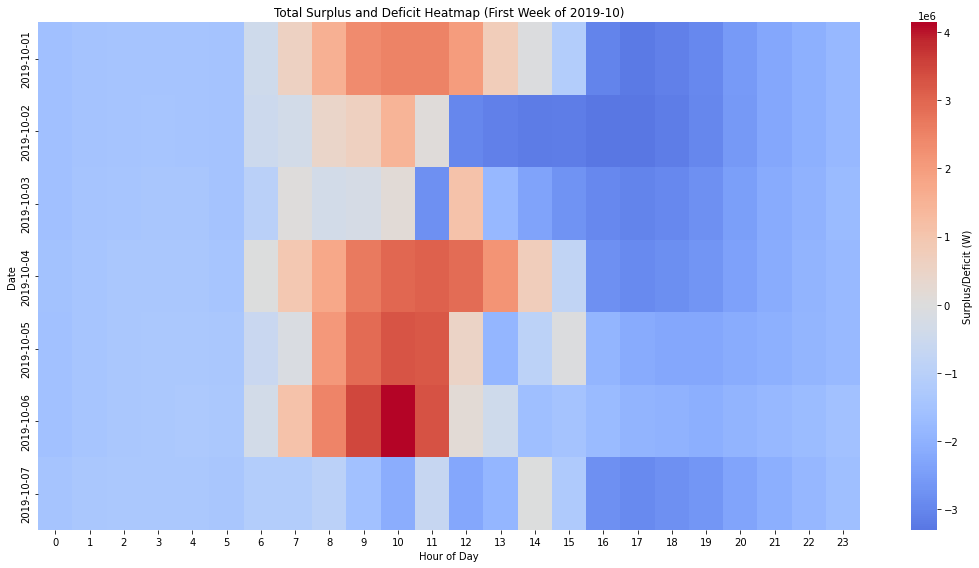

C:\Users\Nik\AppData\Local\Temp/ipykernel_10848/4040539468.py:64: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = daily_surplus_deficit.pivot('Date', 'Hour', 0)


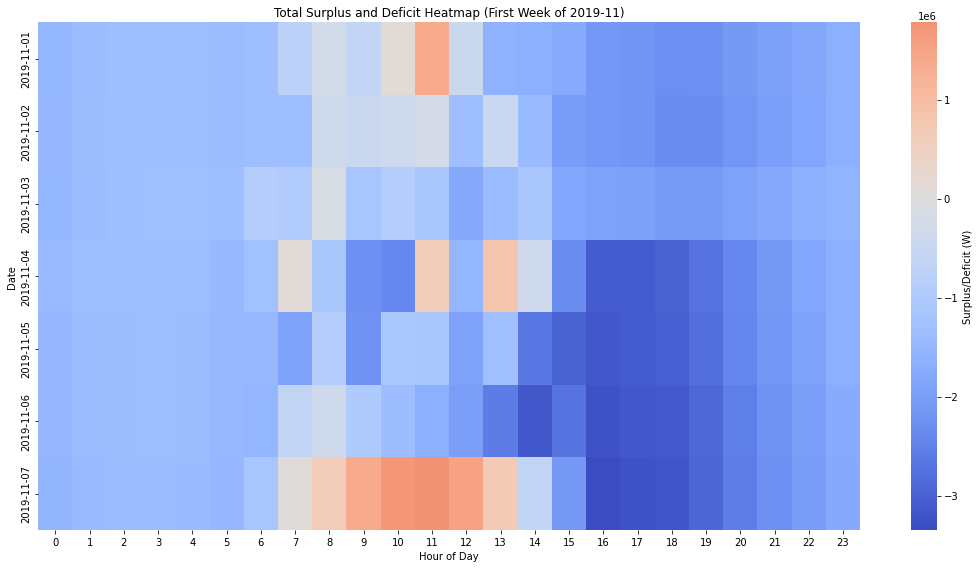

C:\Users\Nik\AppData\Local\Temp/ipykernel_10848/4040539468.py:64: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = daily_surplus_deficit.pivot('Date', 'Hour', 0)


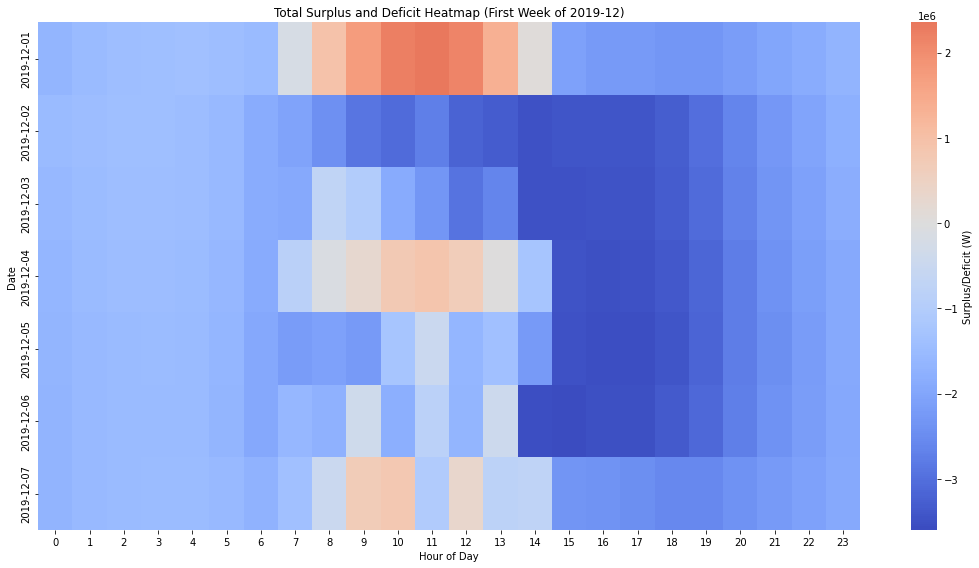

In [91]:
# 1. Peak Production and Consumption Analysis
def peak_analysis(production_dfs, consumption_df, area_maxes, category_names):
    # Combine production DataFrames for total production
    total_production = sum(df.sum(axis=1) for df in production_dfs)
    total_consumption = sum(consumption_df[category] * area_max for category, area_max in zip(category_names, area_maxes))
    
    # Find peak production and consumption hours
    peak_production_hour = total_production.idxmax()
    peak_production_value = total_production.max()
    
    peak_consumption_hour = total_consumption.idxmax()
    peak_consumption_value = total_consumption.max()
    
    print(f"\nPeak Analysis for Total Production and Consumption:")
    print(f"Peak Production: {peak_production_value:.2f} W at {peak_production_hour}")
    print(f"Peak Consumption: {peak_consumption_value:.2f} W at {peak_consumption_hour}")
    
    # Plot peak production and consumption
    plt.figure(figsize=(12, 6))
    plt.plot(total_production.index, total_production, label='Total Production', color='blue')
    plt.plot(total_consumption.index, total_consumption, label='Total Consumption', color='red')
    plt.axvline(peak_production_hour, color='blue', linestyle='--', label='Peak Production')
    plt.axvline(peak_consumption_hour, color='red', linestyle='--', label='Peak Consumption')
    plt.xlabel('Time')
    plt.ylabel('Energy (W)')
    plt.title('Total Peak Production and Consumption')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(os.path.join(yearly_plot_dir, 'Total_Peak_Production_Consumption.pdf'))
    plt.show()

# Run peak analysis for total production and consumption
peak_analysis(
    [Residential_user_production_df, Industrial_user_production_df, Commercial_user_production_df],
    DF_Consumption, 
    [Area_Res_Max, Area_Ind_Max, Area_Com_Max], 
    ['Residential', 'Industrial', 'Commercial']
)

# 2. Energy Surplus and Deficit Analysis with Heatmap for Each First Week of the Month (Total)
def surplus_deficit_heatmap_first_week(production_dfs, consumption_df, area_maxes, category_names):
    for month in range(1, 13):
        start_date = f'2019-{month:02d}-01'
        end_date = f'2019-{month:02d}-07'

        # Filter data for the first week of the month
        week_production_dfs = [df.loc[start_date:end_date] for df in production_dfs]
        week_consumption_df = consumption_df.loc[start_date:end_date]

        # Calculate total production and consumption for each hour
        total_production = sum(df.sum(axis=1) for df in week_production_dfs)
        total_consumption = sum(week_consumption_df[category] * area_max for category, area_max in zip(category_names, area_maxes))

        # Calculate surplus and deficit
        surplus_deficit = total_production - total_consumption

        # Prepare data for heatmap by pivoting the daily data into a matrix of days vs. hours
        daily_surplus_deficit = surplus_deficit.reset_index()
        daily_surplus_deficit.rename(columns={daily_surplus_deficit.columns[0]: 'Datetime'}, inplace=True)
        daily_surplus_deficit['Date'] = daily_surplus_deficit['Datetime'].dt.date
        daily_surplus_deficit['Hour'] = daily_surplus_deficit['Datetime'].dt.hour
        heatmap_data = daily_surplus_deficit.pivot('Date', 'Hour', 0)

        # Plot the heatmap
        plt.figure(figsize=(15, 8))
        sns.heatmap(heatmap_data, cmap='coolwarm', center=0, cbar_kws={'label': 'Surplus/Deficit (W)'})
        plt.title(f'Total Surplus and Deficit Heatmap (First Week of {start_date[:7]})')
        plt.xlabel('Hour of Day')
        plt.ylabel('Date')
        plt.tight_layout()
        plt.savefig(os.path.join(weekly_plot_dir, f'Total_Surplus_Deficit_Heatmap_Week_{month:02d}.pdf'))
        plt.show()

# Run surplus and deficit heatmap analysis for total production and consumption
surplus_deficit_heatmap_first_week(
    [Residential_user_production_df, Industrial_user_production_df, Commercial_user_production_df],
    DF_Consumption, 
    [Area_Res_Max, Area_Ind_Max, Area_Com_Max], 
    ['Residential', 'Industrial', 'Commercial']
)


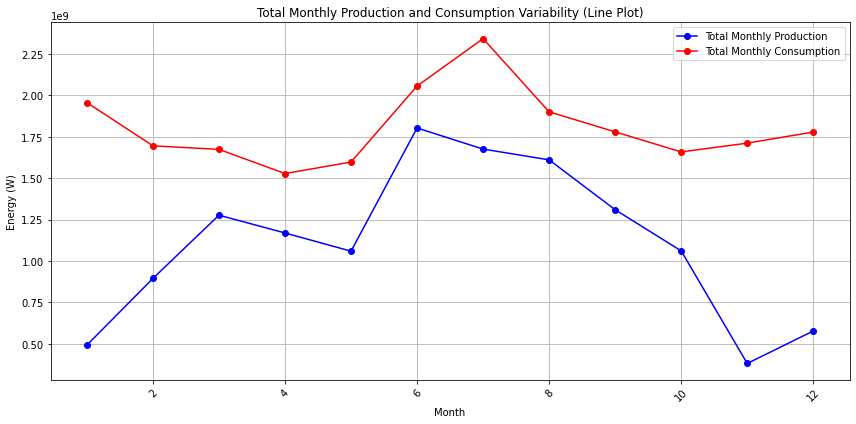

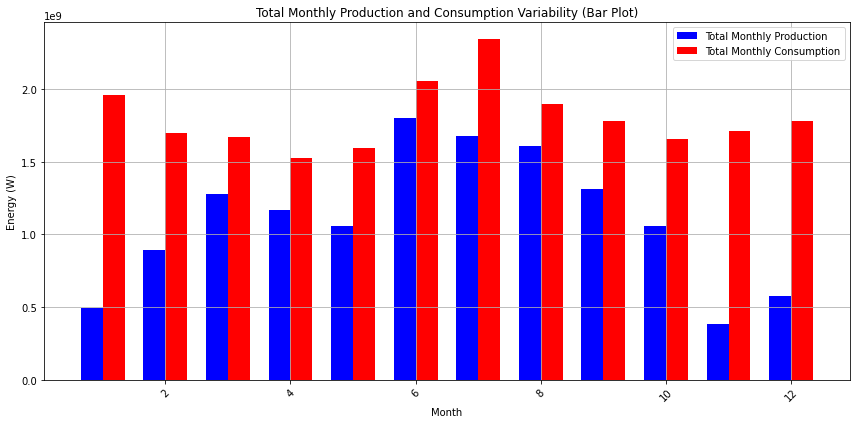

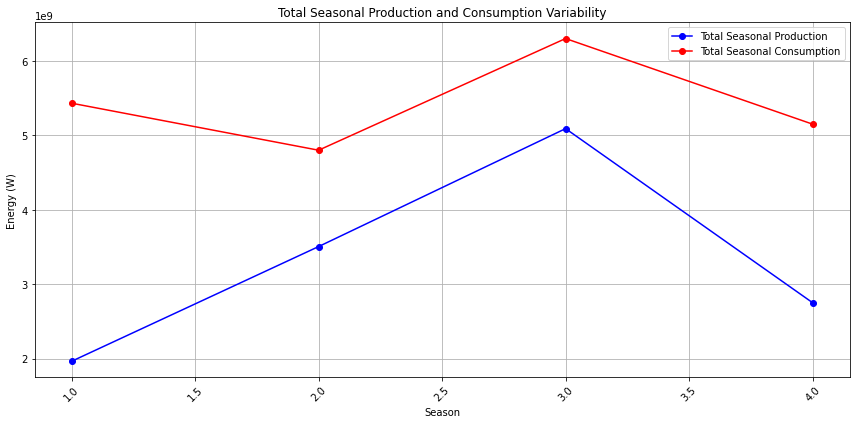

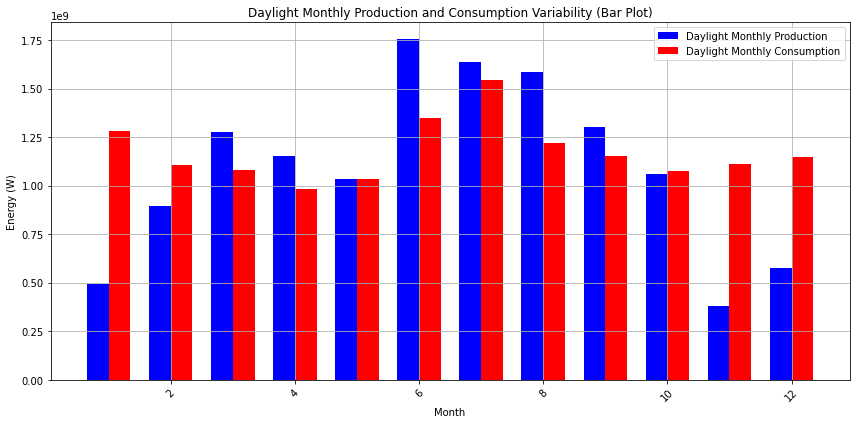

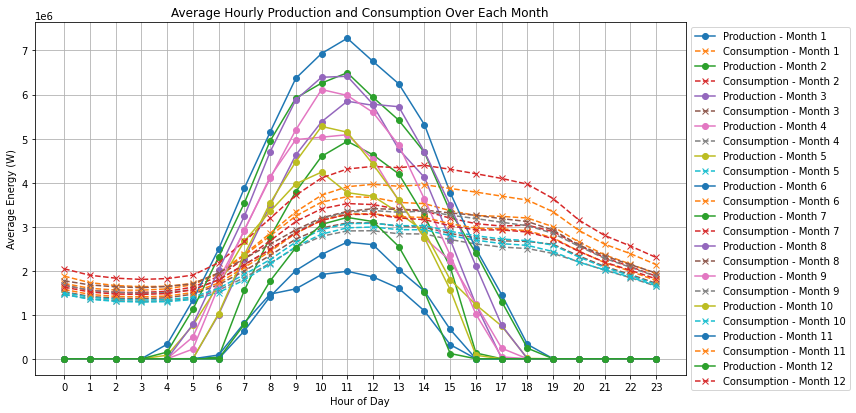

In [92]:
# 4. Seasonal and Monthly Variability Analysis (Total)
def seasonal_monthly_variability(production_dfs, consumption_df, area_maxes, category_names):
    # Ensure all production DataFrames have the same index
    total_production_df = pd.concat(production_dfs, axis=1).sum(axis=1)  # Sum across all production DataFrames
    total_production_df = total_production_df.to_frame(name='Total Production')  # Convert to DataFrame

    # Add 'Month', 'Season', and 'Hour' columns
    total_production_df['Month'] = total_production_df.index.month
    total_production_df['Season'] = total_production_df.index.to_series().dt.month % 12 // 3 + 1
    total_production_df['Hour'] = total_production_df.index.hour

    # Ensure consumption DataFrame is indexed properly
    consumption_df['Month'] = consumption_df.index.month
    consumption_df['Season'] = consumption_df.index.to_series().dt.month % 12 // 3 + 1
    consumption_df['Hour'] = consumption_df.index.hour

    # Calculate monthly total production and consumption
    monthly_production = total_production_df.groupby('Month')['Total Production'].sum()

    # Correct calculation of monthly consumption
    monthly_consumption = consumption_df.groupby('Month').apply(
        lambda x: sum((x[category] * area_max).sum() for category, area_max in zip(category_names, area_maxes))
    )

    # Calculate seasonal total production and consumption
    seasonal_production = total_production_df.groupby('Season')['Total Production'].sum()

    # Correct calculation of seasonal consumption
    seasonal_consumption = consumption_df.groupby('Season').apply(
        lambda x: sum((x[category] * area_max).sum() for category, area_max in zip(category_names, area_maxes))
    )

    # Plot monthly variability line plot
    plt.figure(figsize=(12, 6))
    plt.plot(monthly_production.index, monthly_production, label='Total Monthly Production', marker='o', color='blue')
    plt.plot(monthly_consumption.index, monthly_consumption, label='Total Monthly Consumption', marker='o', color='red')
    plt.xlabel('Month')
    plt.ylabel('Energy (W)')
    plt.title('Total Monthly Production and Consumption Variability (Line Plot)')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(os.path.join(yearly_plot_dir, 'Total_Monthly_Variability_Line.pdf'))
    plt.show()
    
    # Plot monthly variability as bar plot
    plt.figure(figsize=(12, 6))
    bar_width = 0.35
    plt.bar(monthly_production.index - bar_width / 2, monthly_production, width=bar_width, label='Total Monthly Production', color='blue')
    plt.bar(monthly_consumption.index + bar_width / 2, monthly_consumption, width=bar_width, label='Total Monthly Consumption', color='red')
    plt.xlabel('Month')
    plt.ylabel('Energy (W)')
    plt.title('Total Monthly Production and Consumption Variability (Bar Plot)')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(os.path.join(yearly_plot_dir, 'Total_Monthly_Variability_Bar.pdf'))
    plt.show()

    # Plot seasonal variability line plot
    plt.figure(figsize=(12, 6))
    plt.plot(seasonal_production.index, seasonal_production, label='Total Seasonal Production', marker='o', color='blue')
    plt.plot(seasonal_consumption.index, seasonal_consumption, label='Total Seasonal Consumption', marker='o', color='red')
    plt.xlabel('Season')
    plt.ylabel('Energy (W)')
    plt.title('Total Seasonal Production and Consumption Variability')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(os.path.join(yearly_plot_dir, 'Total_Seasonal_Variability.pdf'))
    plt.show()

    # Filter for daylight hours (e.g., 6:00 to 18:00) where production is typically non-zero
    daylight_hours = total_production_df[(total_production_df['Hour'] >= 6) & (total_production_df['Hour'] <= 18)]
    daylight_production = daylight_hours.groupby('Month')['Total Production'].sum()

    daylight_consumption = consumption_df[(consumption_df['Hour'] >= 6) & (consumption_df['Hour'] <= 18)].groupby('Month').apply(
        lambda x: sum((x[category] * area_max).sum() for category, area_max in zip(category_names, area_maxes))
    )

    # Plot daylight variability as bar plot
    plt.figure(figsize=(12, 6))
    bar_width = 0.35
    plt.bar(daylight_production.index - bar_width / 2, daylight_production, width=bar_width, label='Daylight Monthly Production', color='blue')
    plt.bar(daylight_consumption.index + bar_width / 2, daylight_consumption, width=bar_width, label='Daylight Monthly Consumption', color='red')
    plt.xlabel('Month')
    plt.ylabel('Energy (W)')
    plt.title('Daylight Monthly Production and Consumption Variability (Bar Plot)')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(os.path.join(yearly_plot_dir, 'Daylight_Monthly_Variability_Bar.pdf'))
    plt.show()

    # Calculate average hourly production and consumption for each month
    avg_hourly_production = total_production_df.groupby(['Month', 'Hour'])['Total Production'].mean().reset_index()
    avg_hourly_consumption = consumption_df.groupby(['Month', 'Hour']).apply(
        lambda x: sum((x[category] * area_max).mean() for category, area_max in zip(category_names, area_maxes))
    ).reset_index(name='Total Consumption')

    # Plot average hourly production and consumption for each month
    plt.figure(figsize=(12, 6))
    for month in range(1, 13):
        plt.plot(avg_hourly_production[avg_hourly_production['Month'] == month]['Hour'],
                 avg_hourly_production[avg_hourly_production['Month'] == month]['Total Production'],
                 label=f'Production - Month {month}', linestyle='-', marker='o')
        plt.plot(avg_hourly_consumption[avg_hourly_consumption['Month'] == month]['Hour'],
                 avg_hourly_consumption[avg_hourly_consumption['Month'] == month]['Total Consumption'],
                 label=f'Consumption - Month {month}', linestyle='--', marker='x')
    
    plt.xlabel('Hour of Day')
    plt.ylabel('Average Energy (W)')
    plt.title('Average Hourly Production and Consumption Over Each Month')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.grid(True)
    plt.xticks(range(0, 24))
    plt.tight_layout()
    plt.savefig(os.path.join(yearly_plot_dir, 'Average_Hourly_Production_Consumption_Per_Month.pdf'))
    plt.show()

# Run seasonal and monthly variability analysis for total production and consumption
seasonal_monthly_variability(
    [Residential_user_production_df, Industrial_user_production_df, Commercial_user_production_df],
    DF_Consumption, 
    [Area_Res_Max, Area_Ind_Max, Area_Com_Max], 
    ['Residential', 'Industrial', 'Commercial']
)



Peak Analysis for Residential:
Peak Production: 7824193.91 W at 2019-06-30 11:00:00
Peak Consumption: 3951200.00 W at 2019-06-28 12:00:00


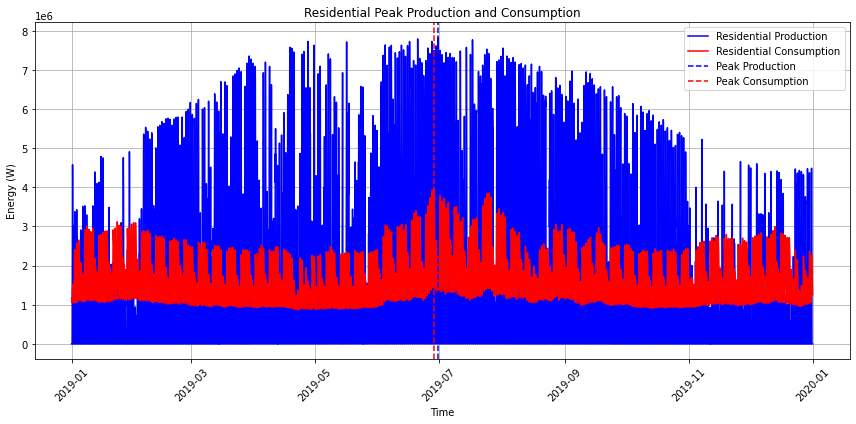


Peak Analysis for Industrial:
Peak Production: 59910.89 W at 2019-06-30 11:00:00
Peak Consumption: 314112.00 W at 2019-06-27 11:00:00


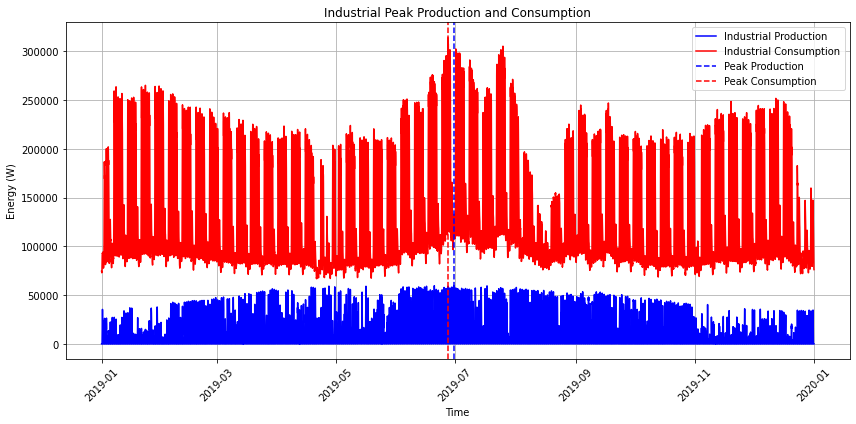


Peak Analysis for Commercial:
Peak Production: 264338.67 W at 2019-06-30 11:00:00
Peak Consumption: 1307980.00 W at 2019-06-28 12:00:00


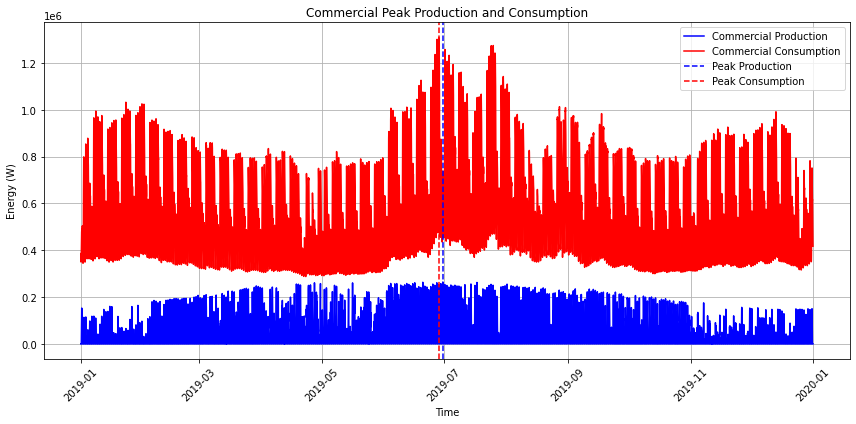

C:\Users\Nik\AppData\Local\Temp/ipykernel_10848/389416298.py:62: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = daily_surplus_deficit.pivot('Date', 'Hour', 0)


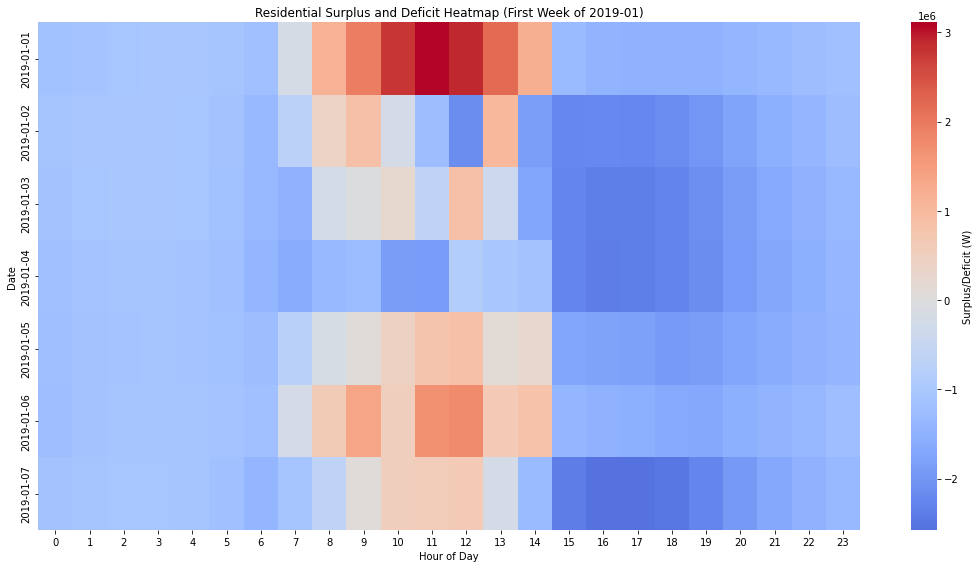

C:\Users\Nik\AppData\Local\Temp/ipykernel_10848/389416298.py:62: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = daily_surplus_deficit.pivot('Date', 'Hour', 0)


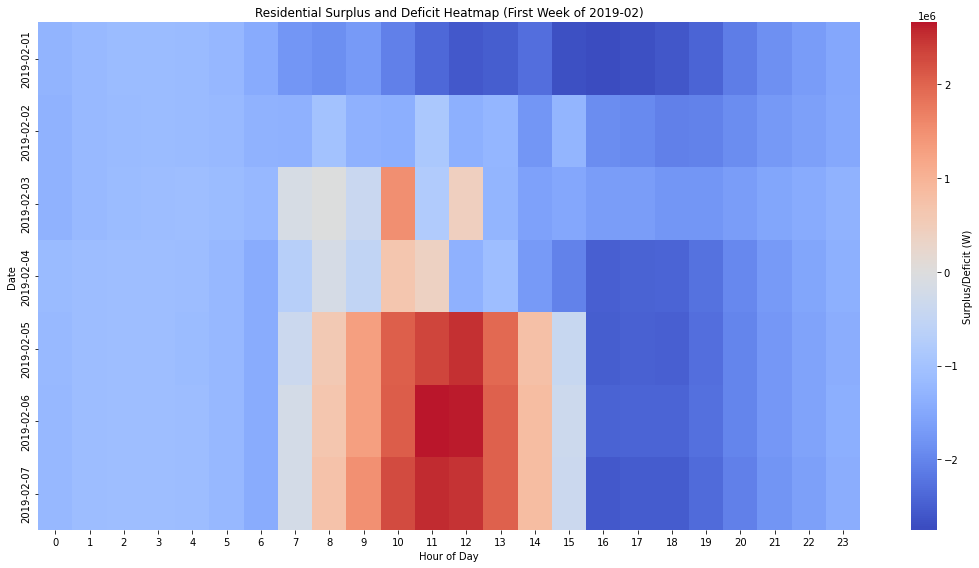

C:\Users\Nik\AppData\Local\Temp/ipykernel_10848/389416298.py:62: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = daily_surplus_deficit.pivot('Date', 'Hour', 0)


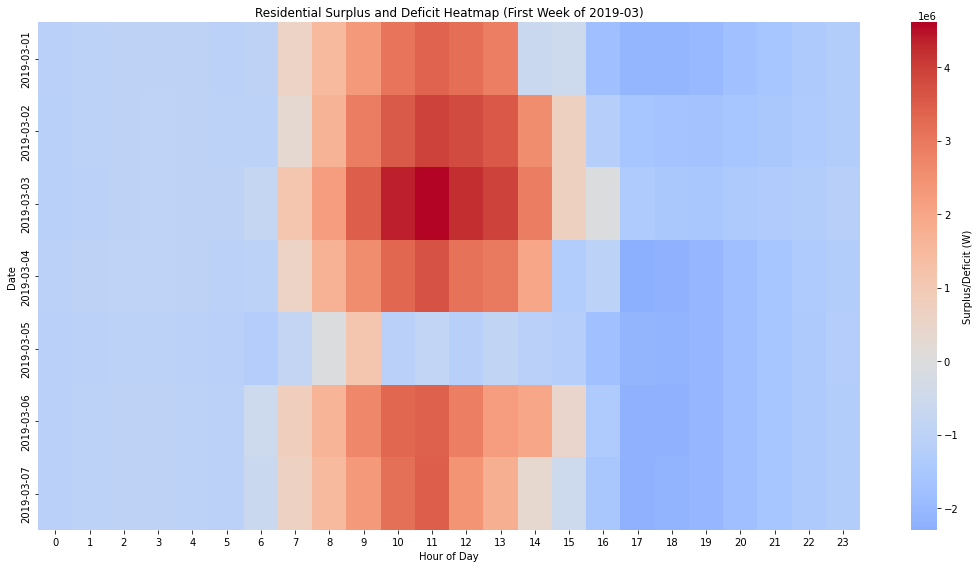

C:\Users\Nik\AppData\Local\Temp/ipykernel_10848/389416298.py:62: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = daily_surplus_deficit.pivot('Date', 'Hour', 0)


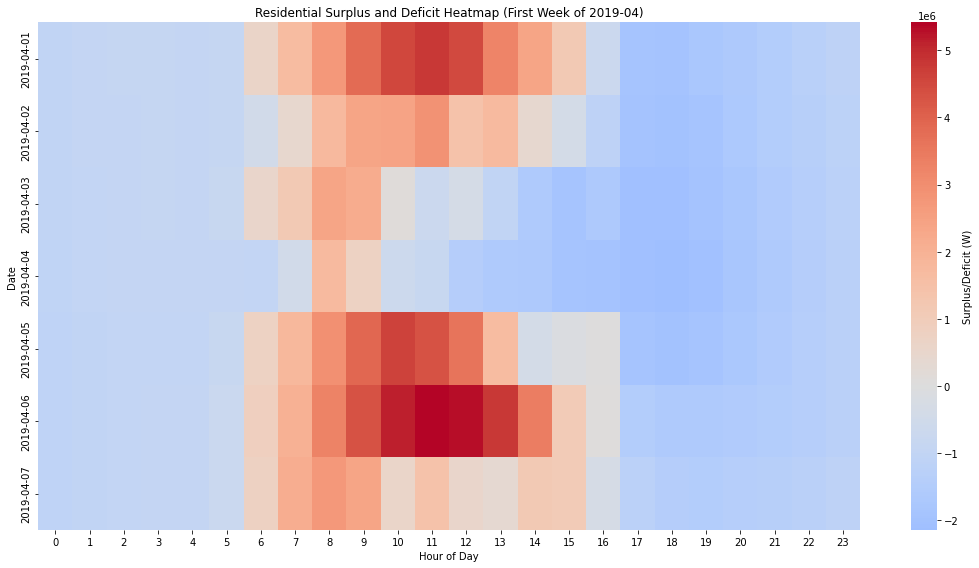

C:\Users\Nik\AppData\Local\Temp/ipykernel_10848/389416298.py:62: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = daily_surplus_deficit.pivot('Date', 'Hour', 0)


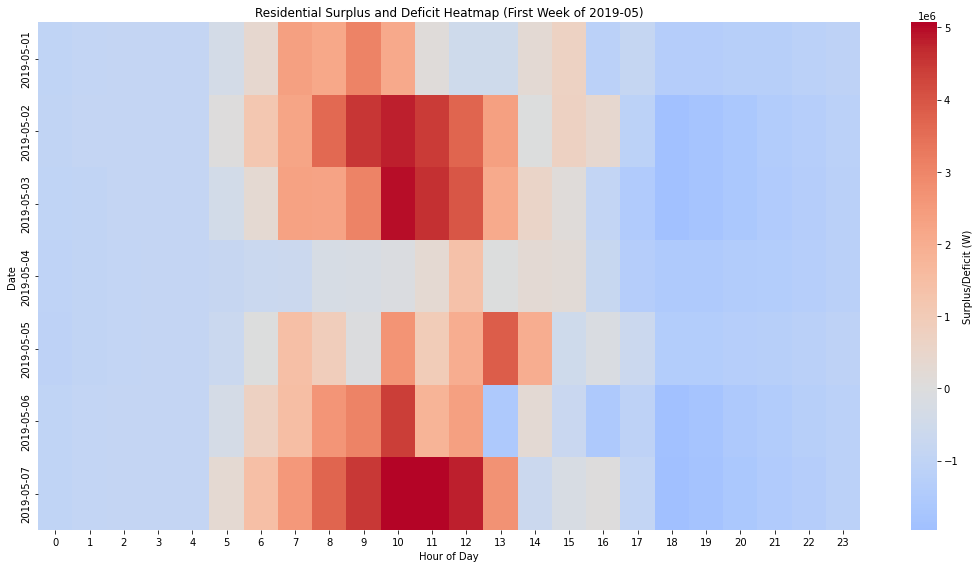

C:\Users\Nik\AppData\Local\Temp/ipykernel_10848/389416298.py:62: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = daily_surplus_deficit.pivot('Date', 'Hour', 0)


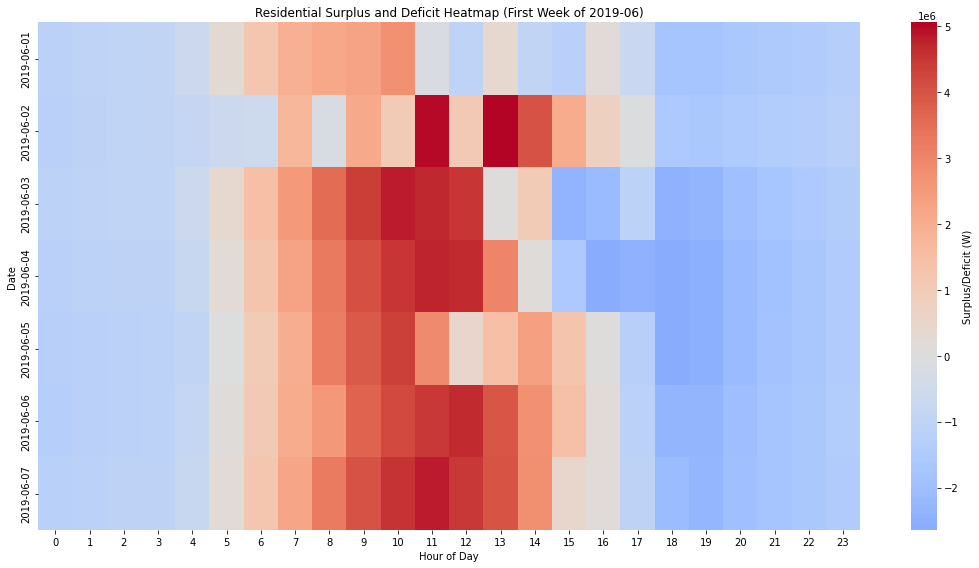

C:\Users\Nik\AppData\Local\Temp/ipykernel_10848/389416298.py:62: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = daily_surplus_deficit.pivot('Date', 'Hour', 0)


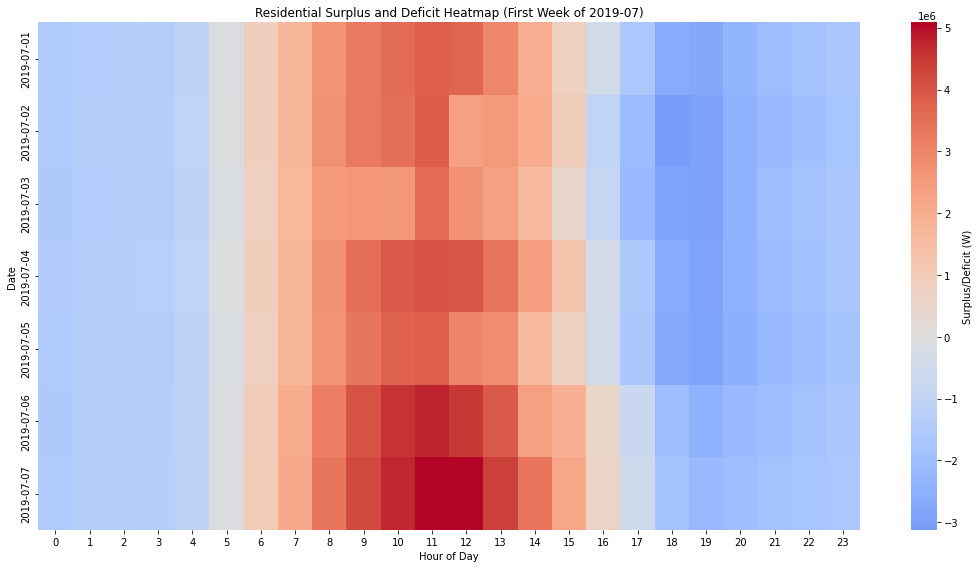

C:\Users\Nik\AppData\Local\Temp/ipykernel_10848/389416298.py:62: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = daily_surplus_deficit.pivot('Date', 'Hour', 0)


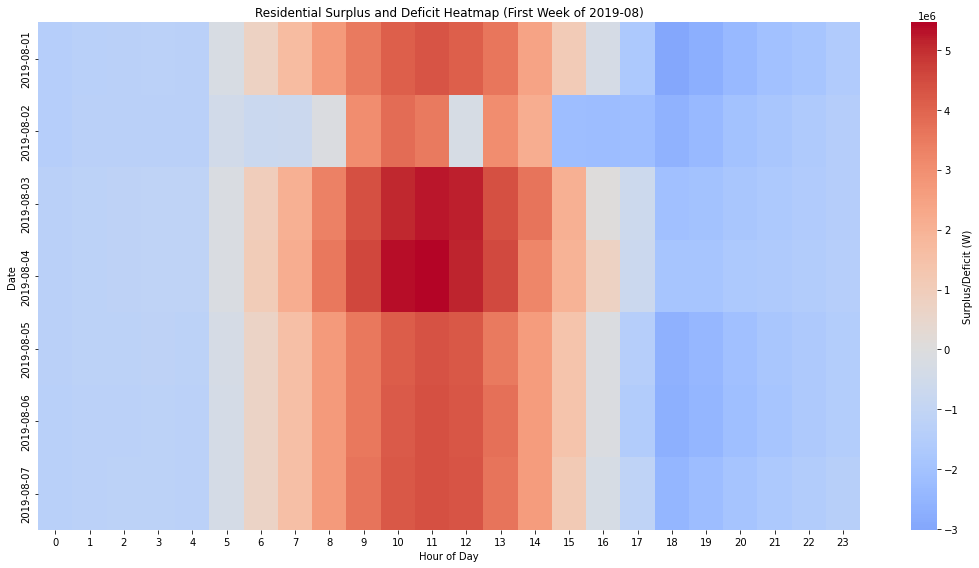

C:\Users\Nik\AppData\Local\Temp/ipykernel_10848/389416298.py:62: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = daily_surplus_deficit.pivot('Date', 'Hour', 0)


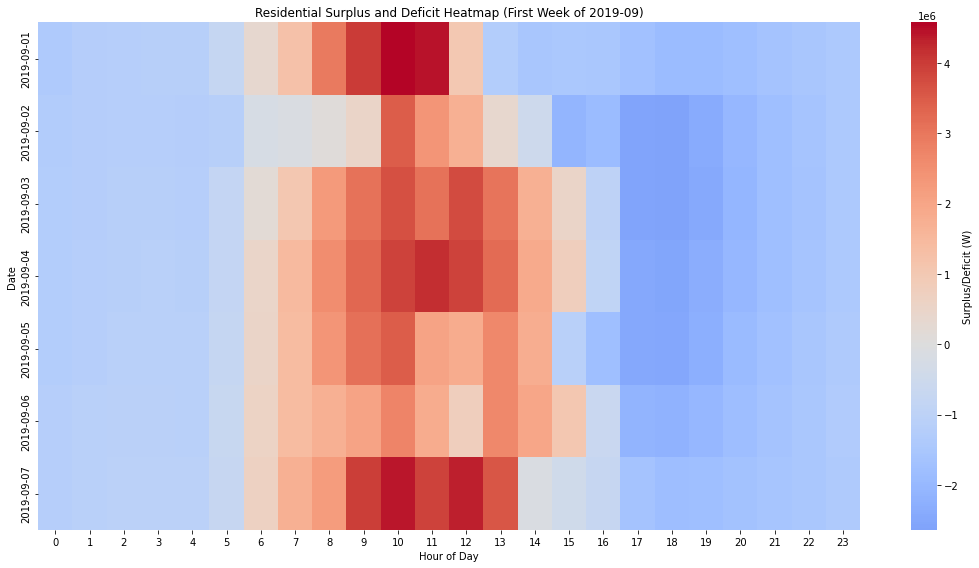

C:\Users\Nik\AppData\Local\Temp/ipykernel_10848/389416298.py:62: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = daily_surplus_deficit.pivot('Date', 'Hour', 0)


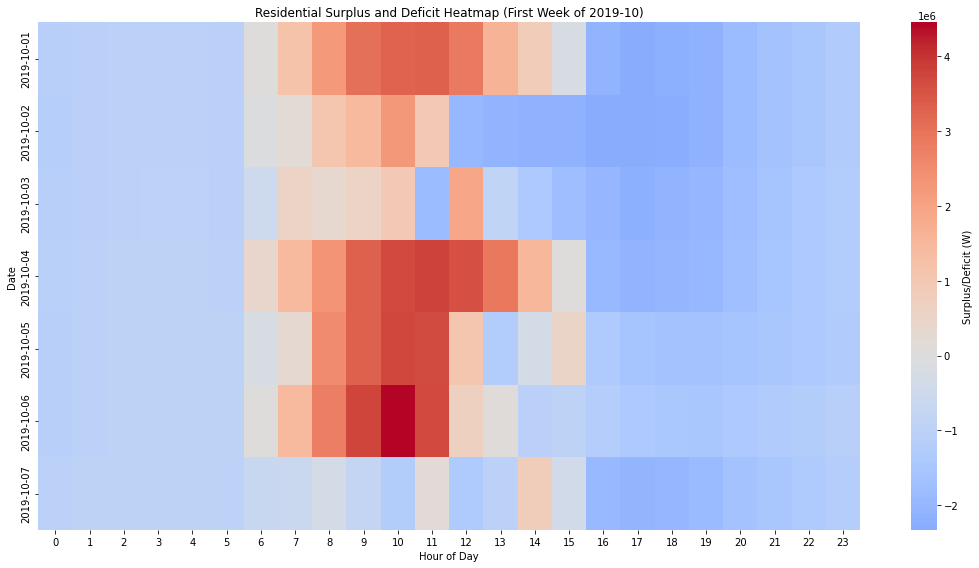

C:\Users\Nik\AppData\Local\Temp/ipykernel_10848/389416298.py:62: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = daily_surplus_deficit.pivot('Date', 'Hour', 0)


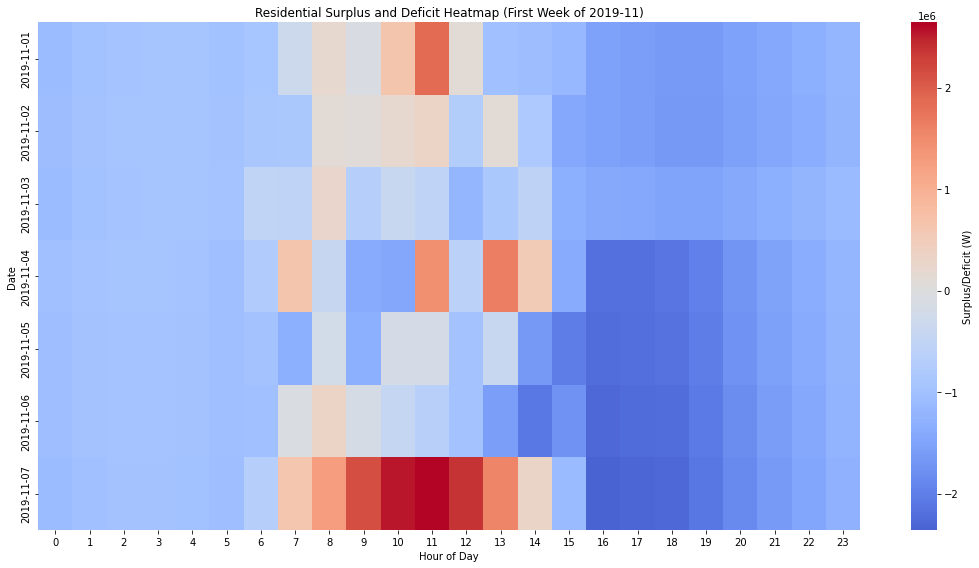

C:\Users\Nik\AppData\Local\Temp/ipykernel_10848/389416298.py:62: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = daily_surplus_deficit.pivot('Date', 'Hour', 0)


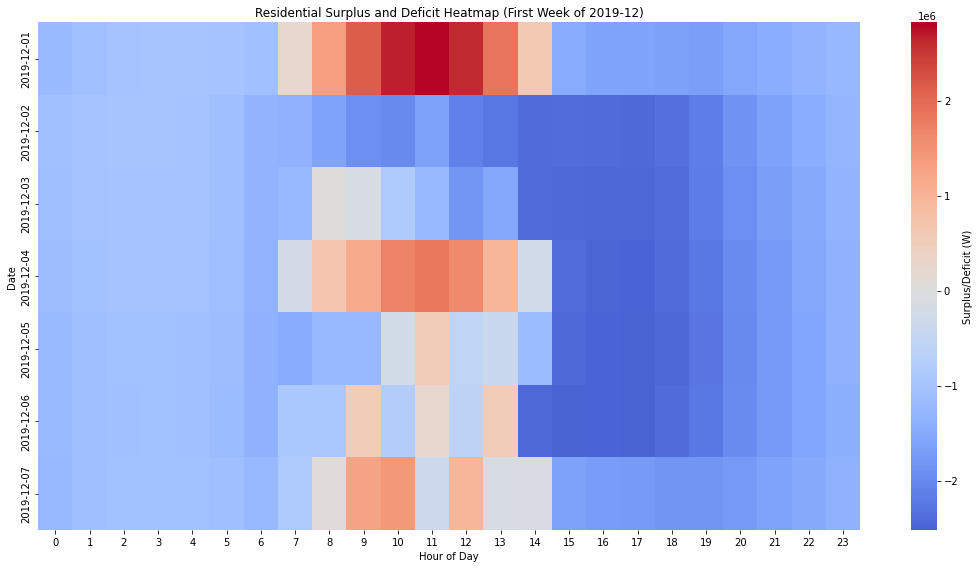

C:\Users\Nik\AppData\Local\Temp/ipykernel_10848/389416298.py:62: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = daily_surplus_deficit.pivot('Date', 'Hour', 0)


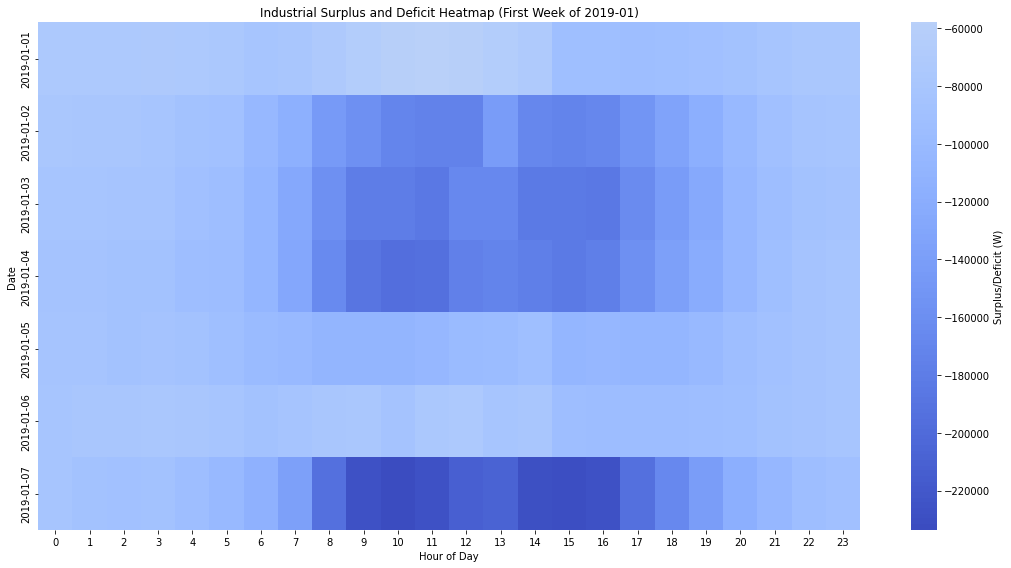

C:\Users\Nik\AppData\Local\Temp/ipykernel_10848/389416298.py:62: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = daily_surplus_deficit.pivot('Date', 'Hour', 0)


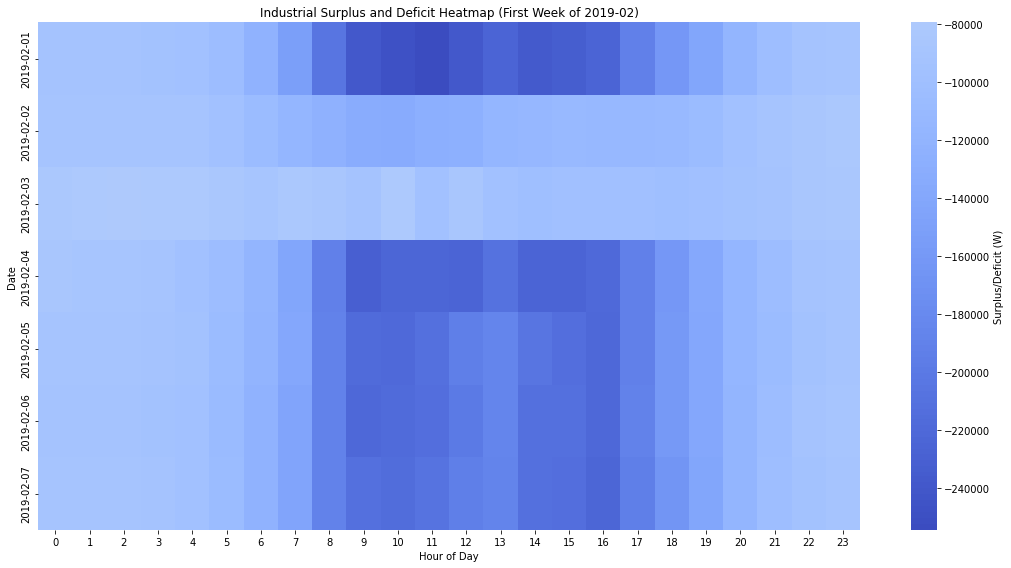

C:\Users\Nik\AppData\Local\Temp/ipykernel_10848/389416298.py:62: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = daily_surplus_deficit.pivot('Date', 'Hour', 0)


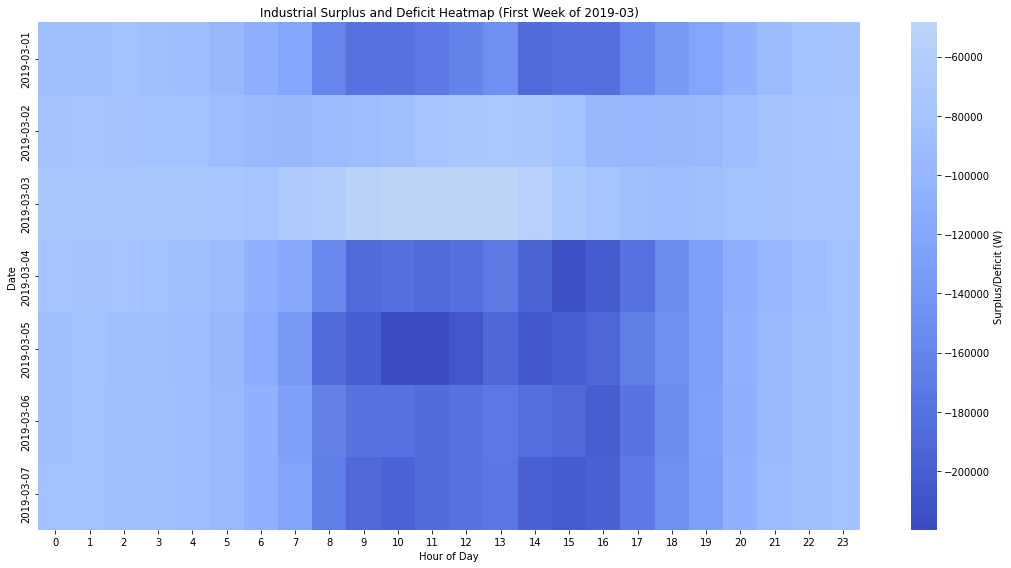

C:\Users\Nik\AppData\Local\Temp/ipykernel_10848/389416298.py:62: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = daily_surplus_deficit.pivot('Date', 'Hour', 0)


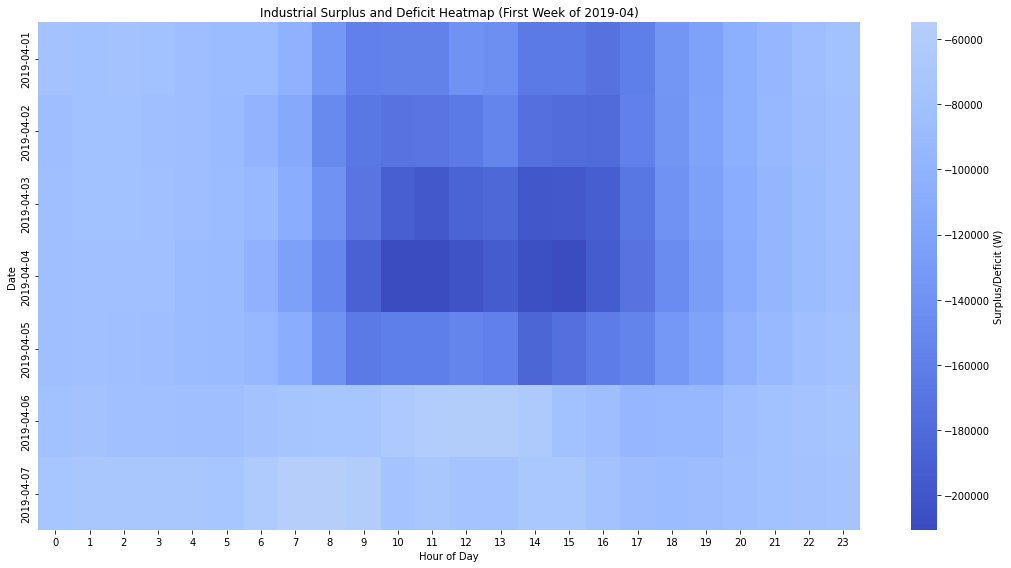

C:\Users\Nik\AppData\Local\Temp/ipykernel_10848/389416298.py:62: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = daily_surplus_deficit.pivot('Date', 'Hour', 0)


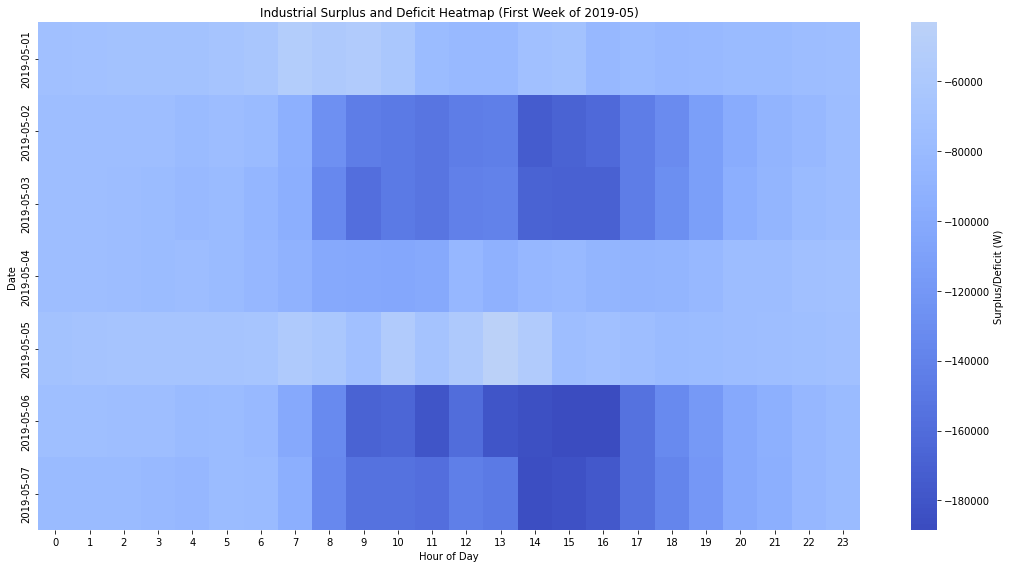

C:\Users\Nik\AppData\Local\Temp/ipykernel_10848/389416298.py:62: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = daily_surplus_deficit.pivot('Date', 'Hour', 0)


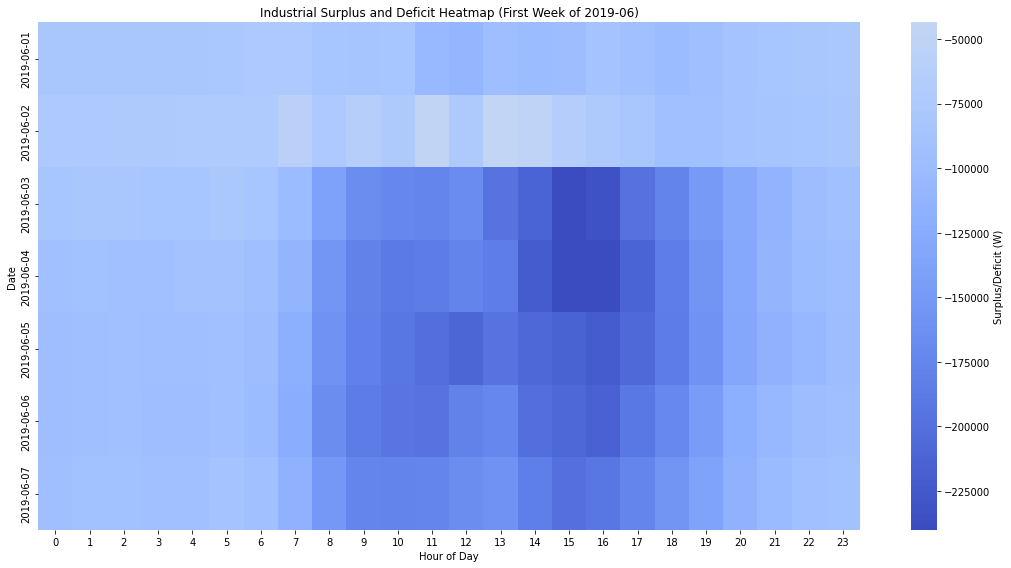

C:\Users\Nik\AppData\Local\Temp/ipykernel_10848/389416298.py:62: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = daily_surplus_deficit.pivot('Date', 'Hour', 0)


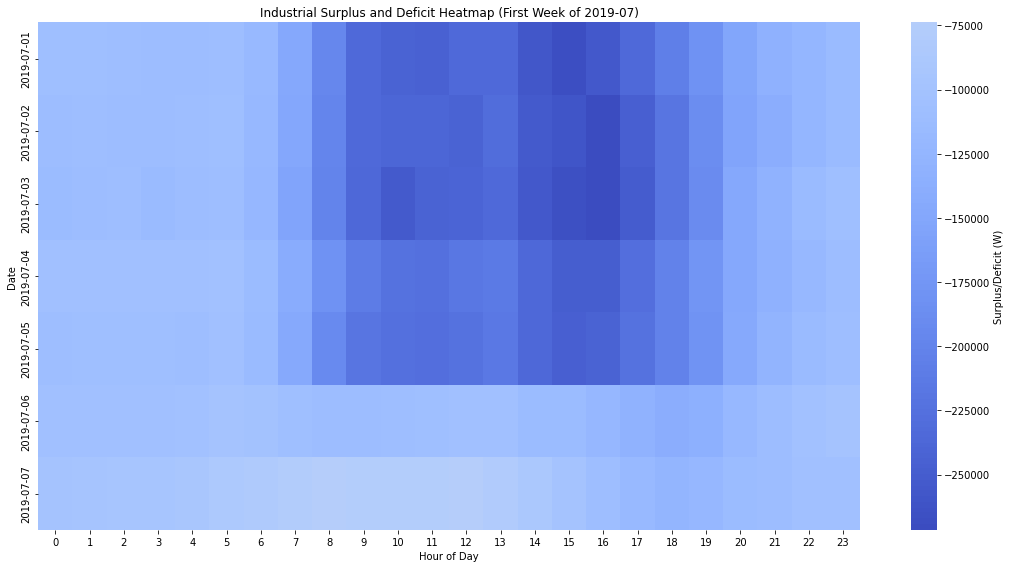

C:\Users\Nik\AppData\Local\Temp/ipykernel_10848/389416298.py:62: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = daily_surplus_deficit.pivot('Date', 'Hour', 0)


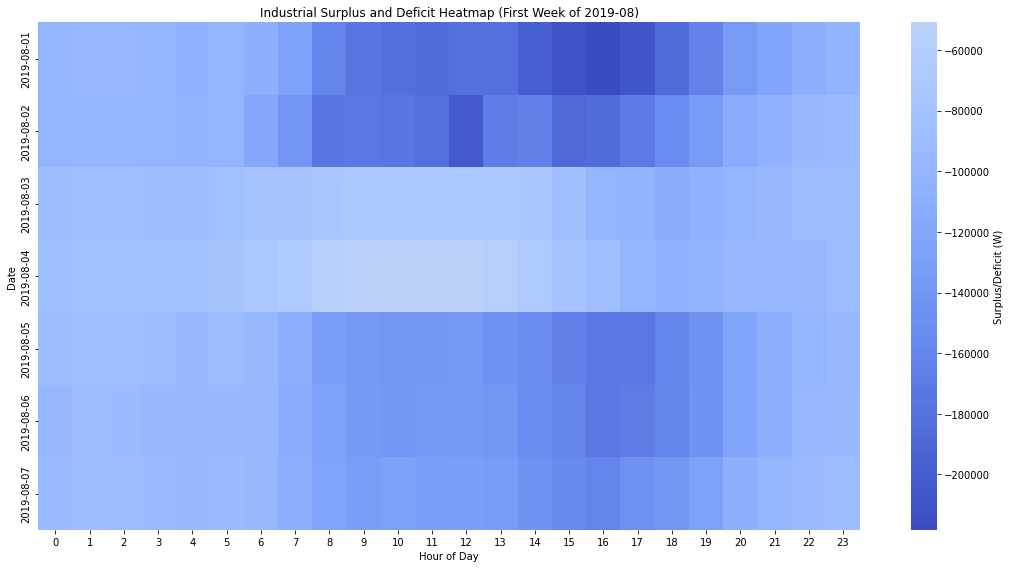

C:\Users\Nik\AppData\Local\Temp/ipykernel_10848/389416298.py:62: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = daily_surplus_deficit.pivot('Date', 'Hour', 0)


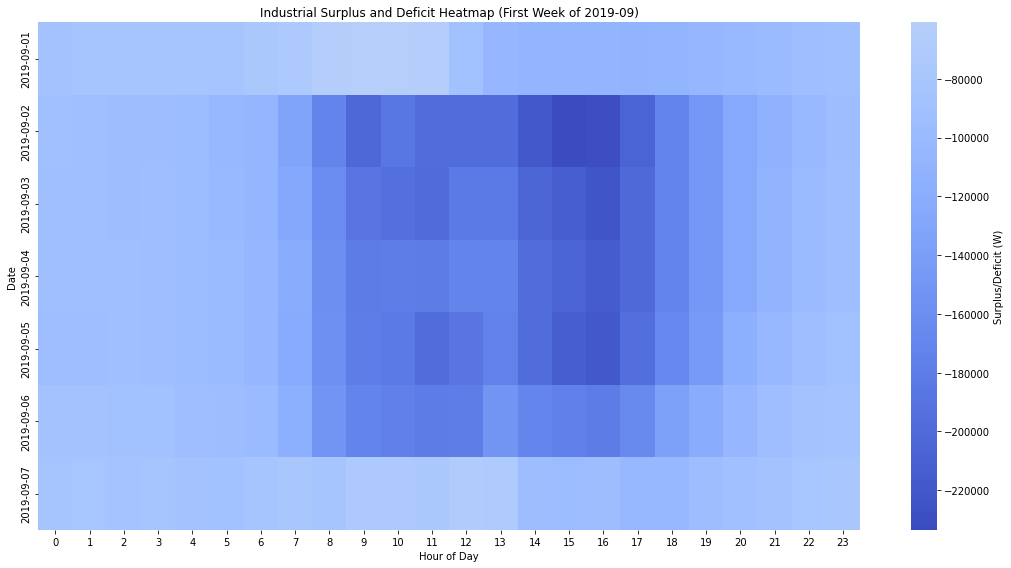

C:\Users\Nik\AppData\Local\Temp/ipykernel_10848/389416298.py:62: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = daily_surplus_deficit.pivot('Date', 'Hour', 0)


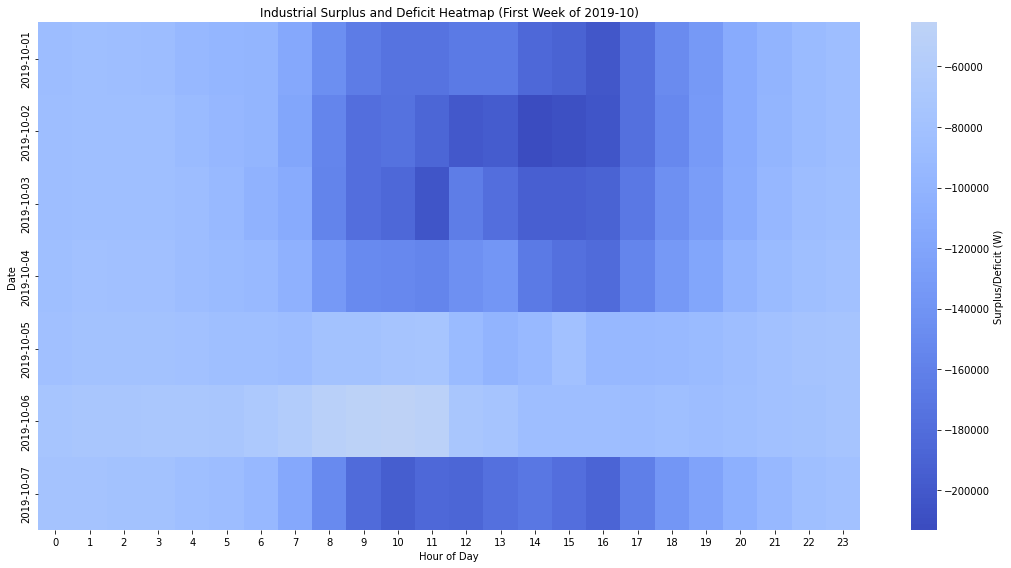

C:\Users\Nik\AppData\Local\Temp/ipykernel_10848/389416298.py:62: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = daily_surplus_deficit.pivot('Date', 'Hour', 0)


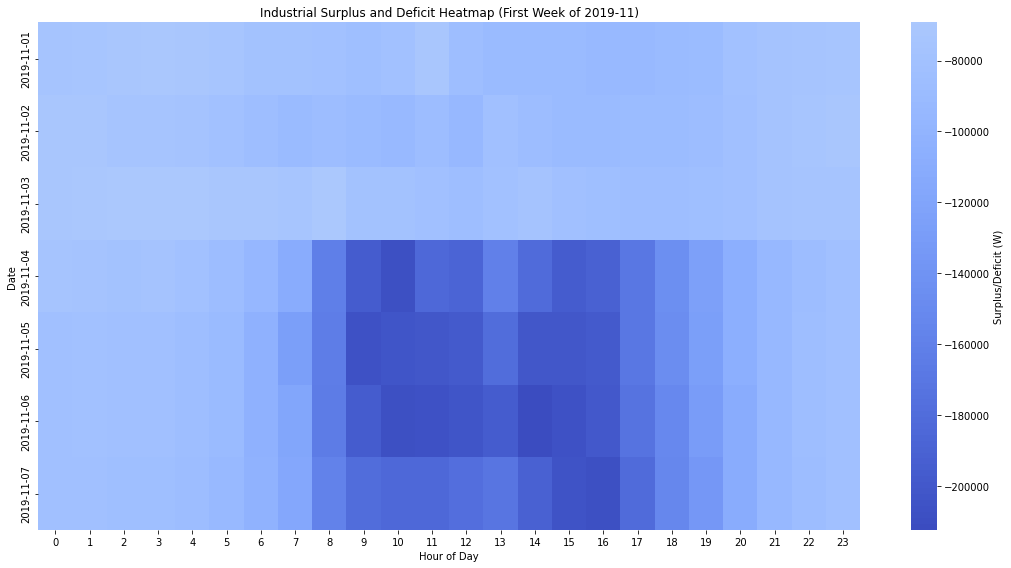

C:\Users\Nik\AppData\Local\Temp/ipykernel_10848/389416298.py:62: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = daily_surplus_deficit.pivot('Date', 'Hour', 0)


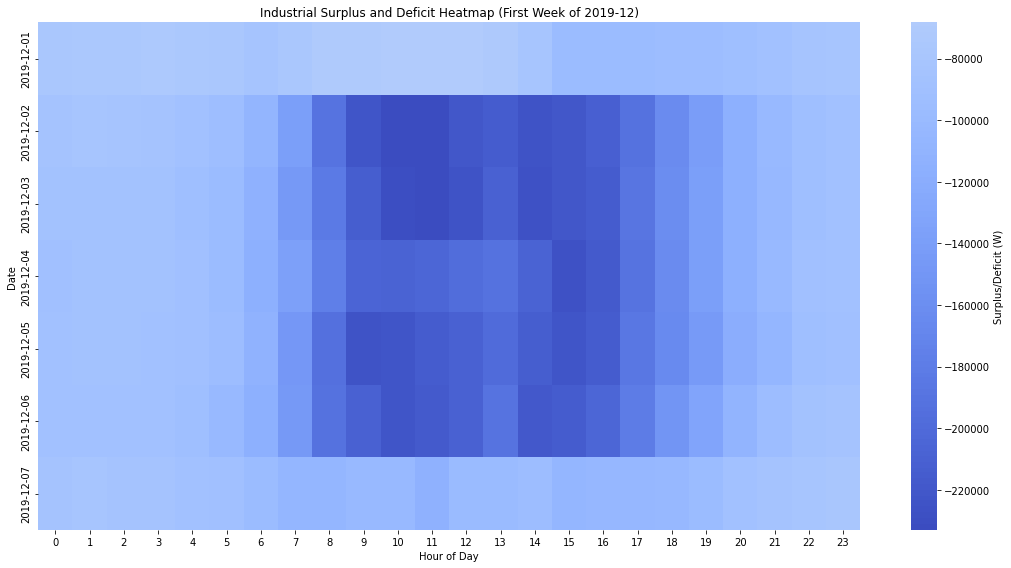

C:\Users\Nik\AppData\Local\Temp/ipykernel_10848/389416298.py:62: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = daily_surplus_deficit.pivot('Date', 'Hour', 0)


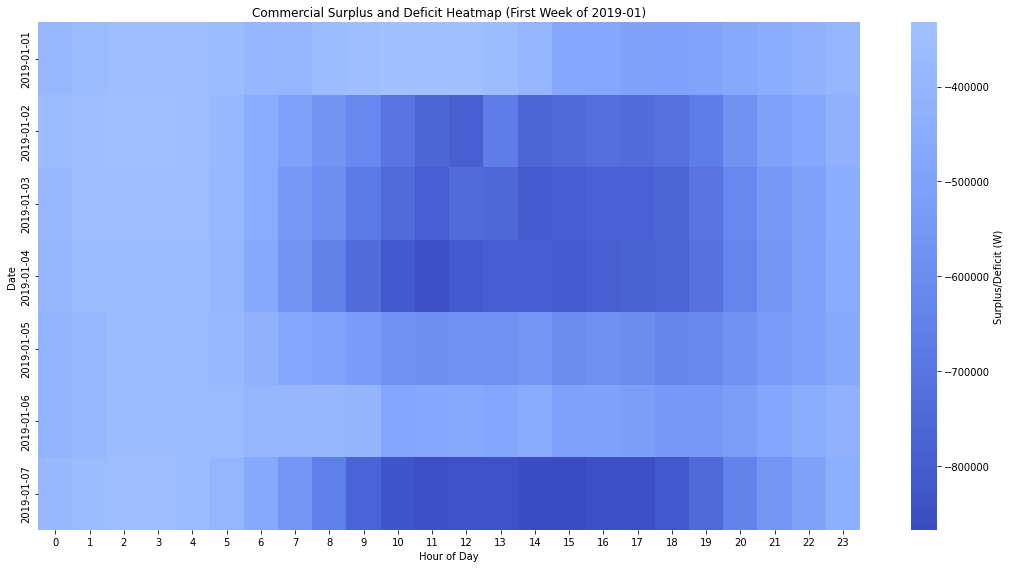

C:\Users\Nik\AppData\Local\Temp/ipykernel_10848/389416298.py:62: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = daily_surplus_deficit.pivot('Date', 'Hour', 0)


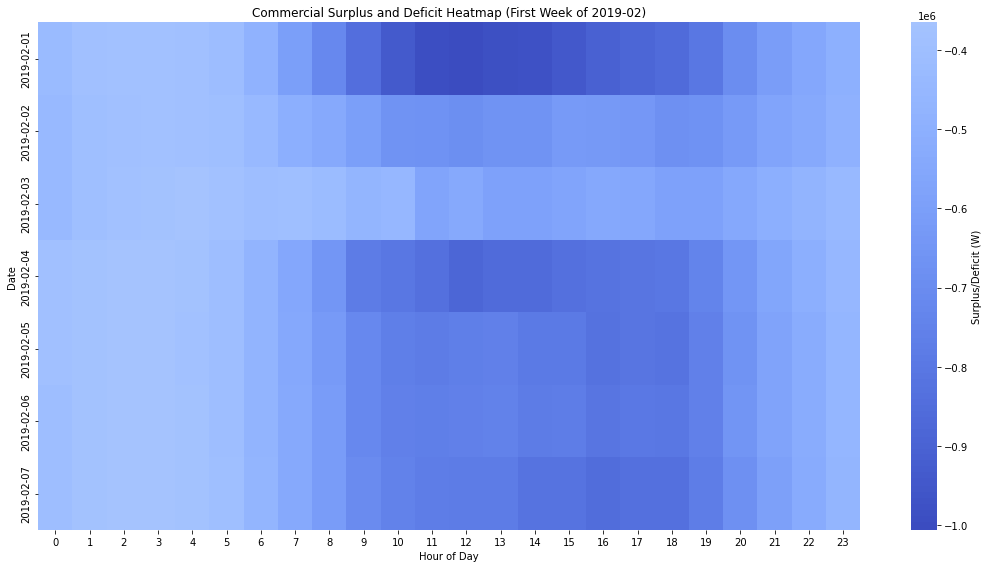

C:\Users\Nik\AppData\Local\Temp/ipykernel_10848/389416298.py:62: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = daily_surplus_deficit.pivot('Date', 'Hour', 0)


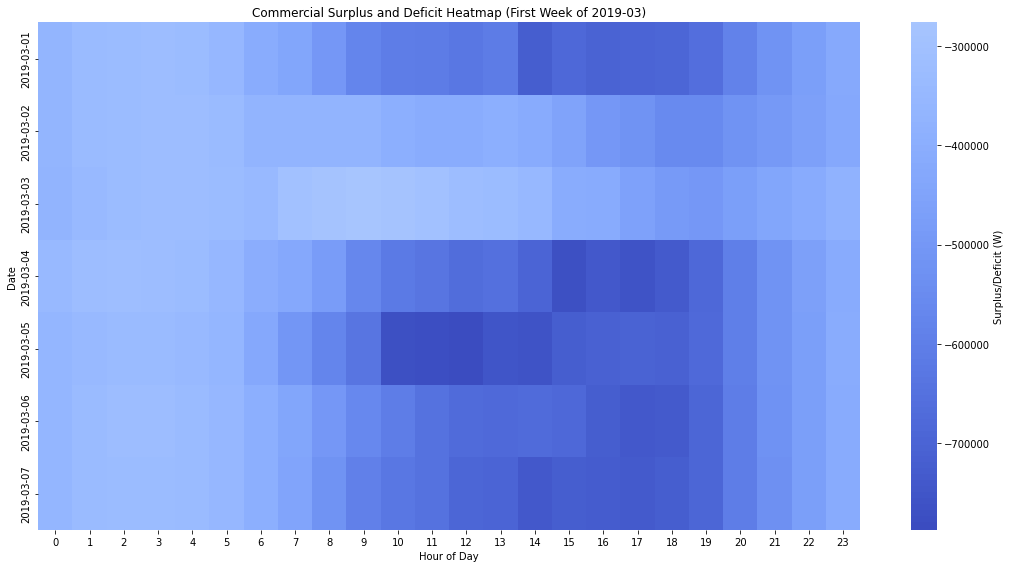

C:\Users\Nik\AppData\Local\Temp/ipykernel_10848/389416298.py:62: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = daily_surplus_deficit.pivot('Date', 'Hour', 0)


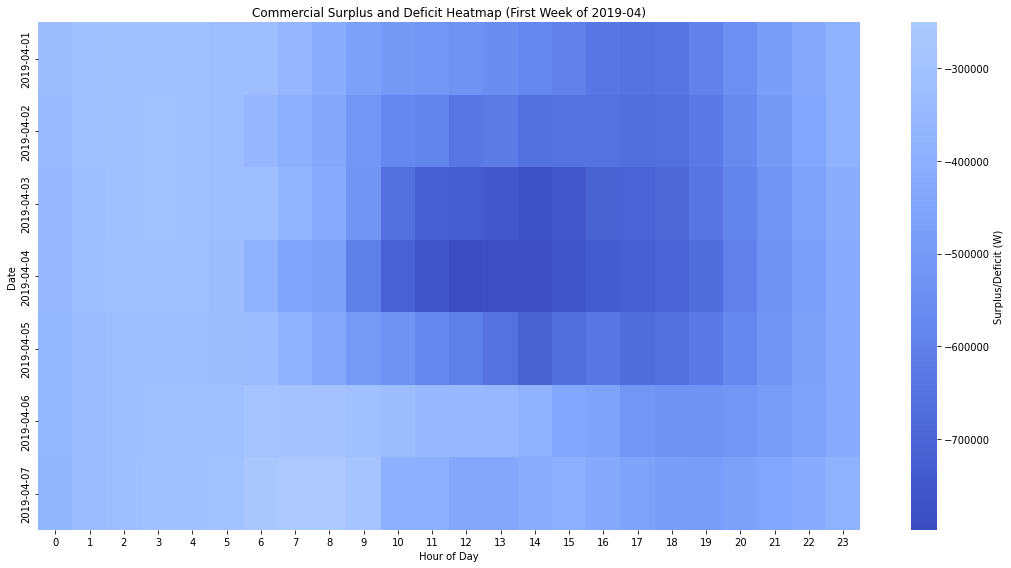

C:\Users\Nik\AppData\Local\Temp/ipykernel_10848/389416298.py:62: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = daily_surplus_deficit.pivot('Date', 'Hour', 0)


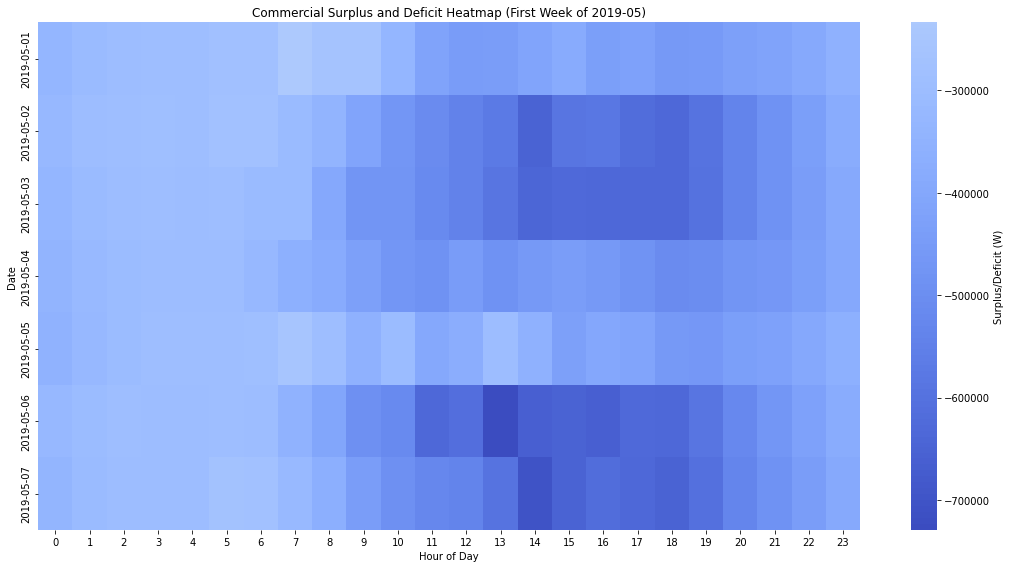

C:\Users\Nik\AppData\Local\Temp/ipykernel_10848/389416298.py:62: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = daily_surplus_deficit.pivot('Date', 'Hour', 0)


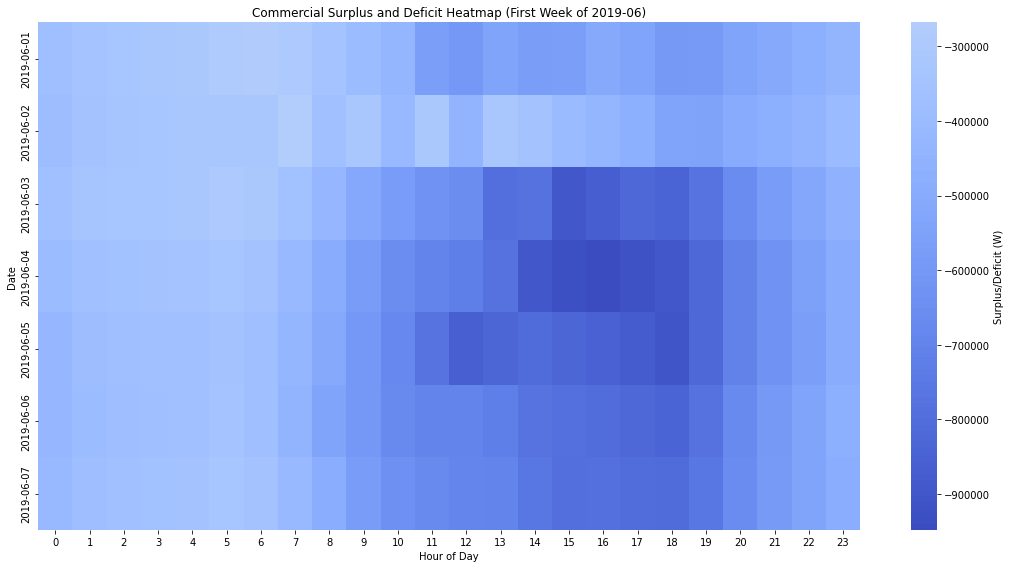

C:\Users\Nik\AppData\Local\Temp/ipykernel_10848/389416298.py:62: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = daily_surplus_deficit.pivot('Date', 'Hour', 0)


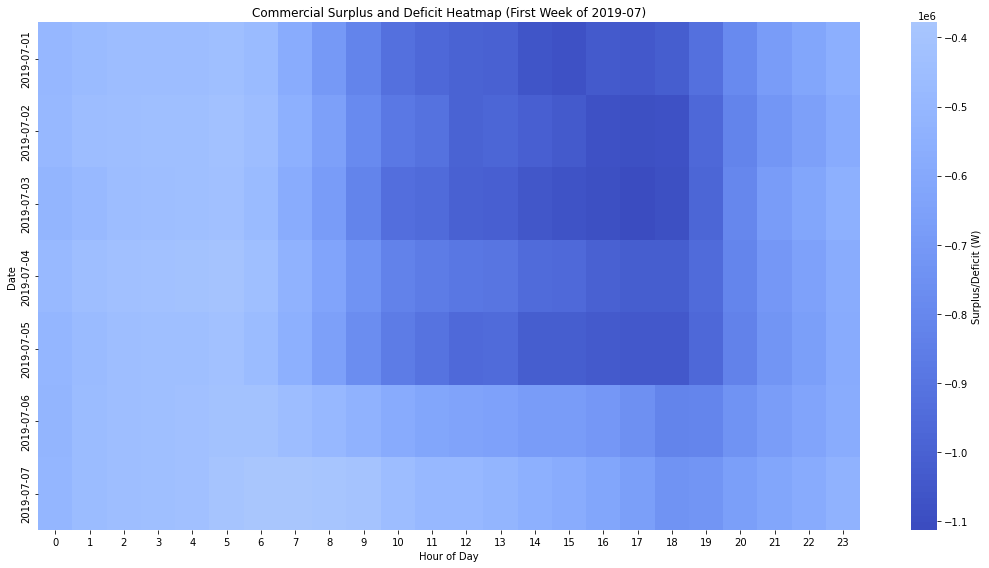

C:\Users\Nik\AppData\Local\Temp/ipykernel_10848/389416298.py:62: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = daily_surplus_deficit.pivot('Date', 'Hour', 0)


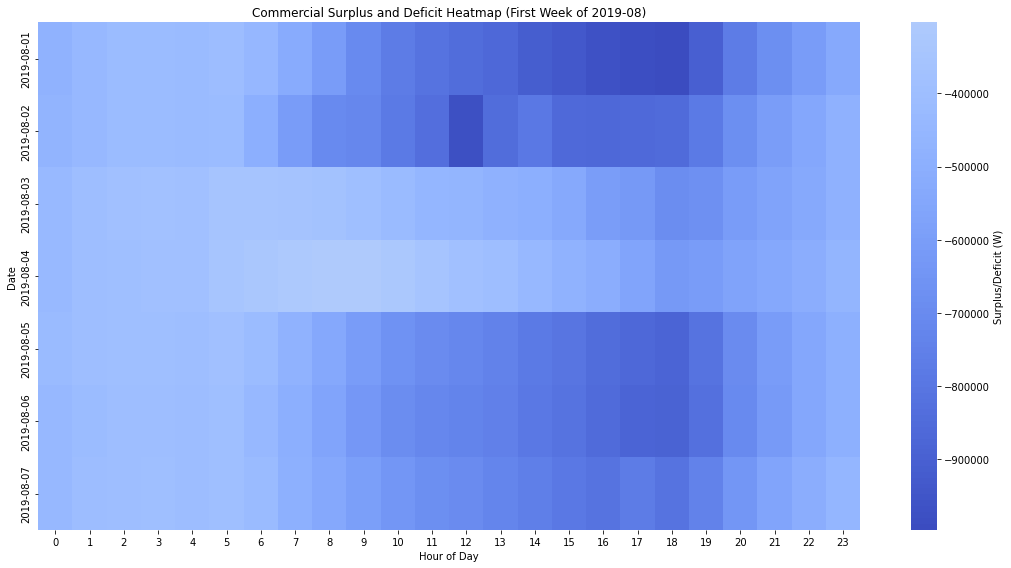

C:\Users\Nik\AppData\Local\Temp/ipykernel_10848/389416298.py:62: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = daily_surplus_deficit.pivot('Date', 'Hour', 0)


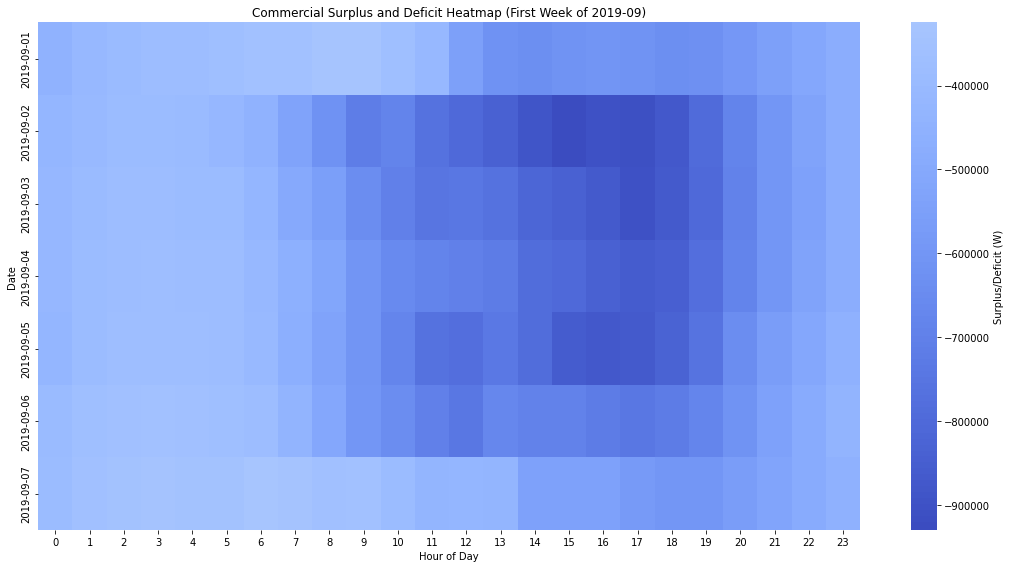

C:\Users\Nik\AppData\Local\Temp/ipykernel_10848/389416298.py:62: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = daily_surplus_deficit.pivot('Date', 'Hour', 0)


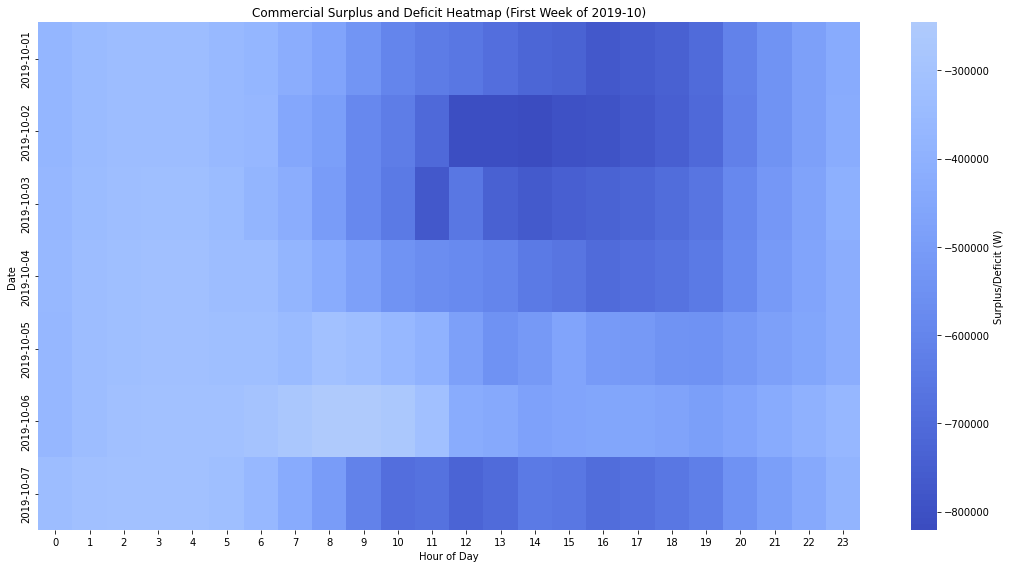

C:\Users\Nik\AppData\Local\Temp/ipykernel_10848/389416298.py:62: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = daily_surplus_deficit.pivot('Date', 'Hour', 0)


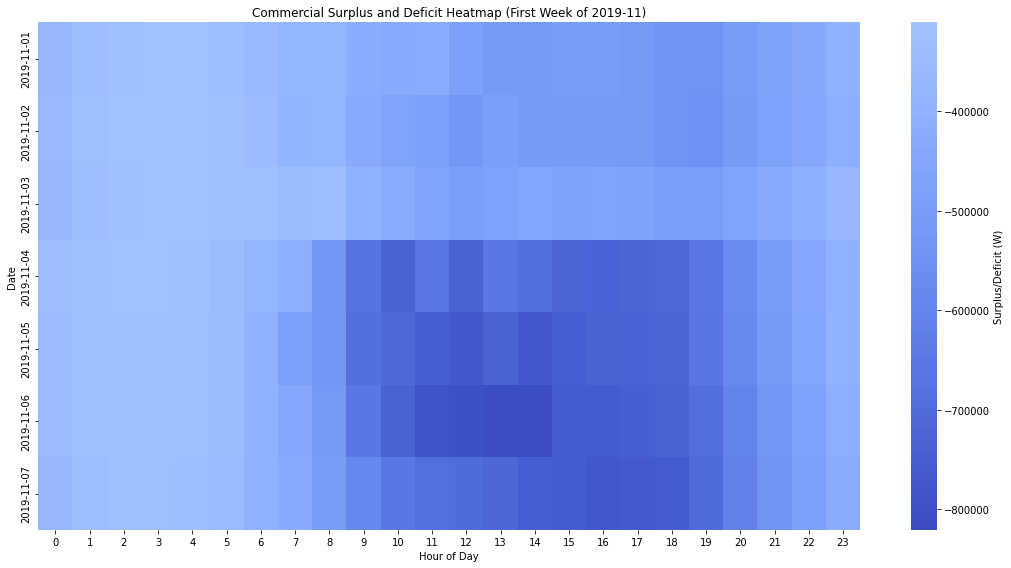

C:\Users\Nik\AppData\Local\Temp/ipykernel_10848/389416298.py:62: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = daily_surplus_deficit.pivot('Date', 'Hour', 0)


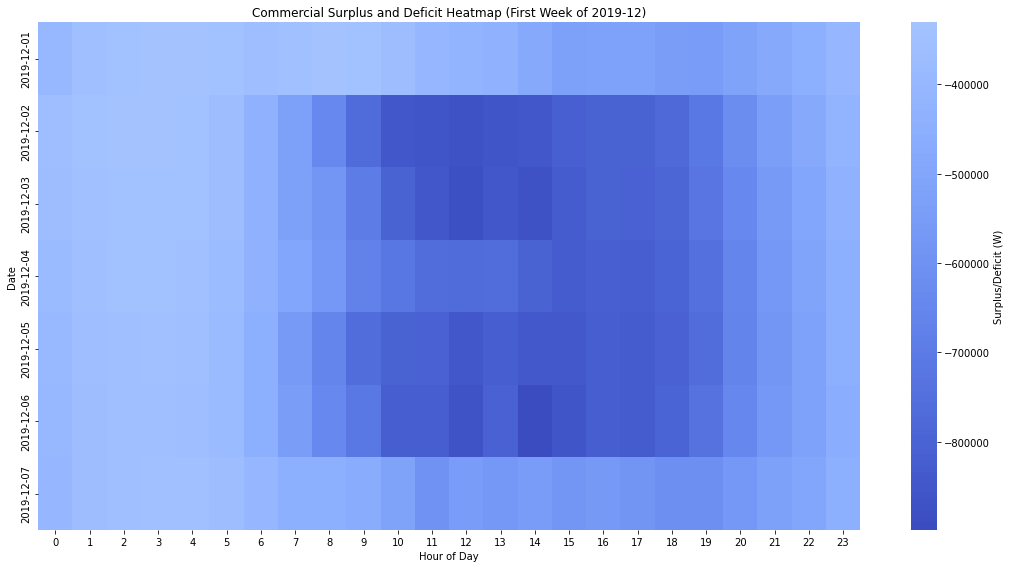

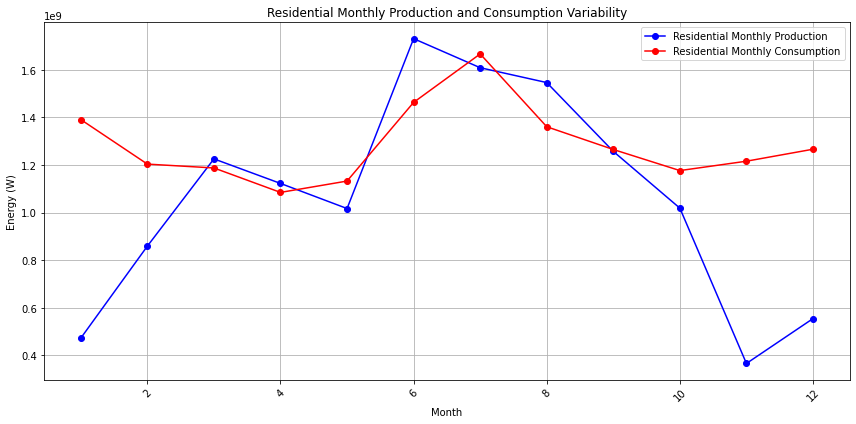

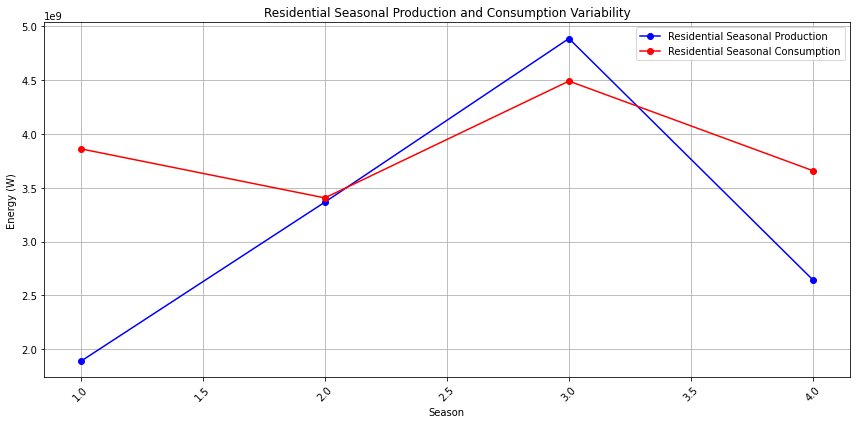

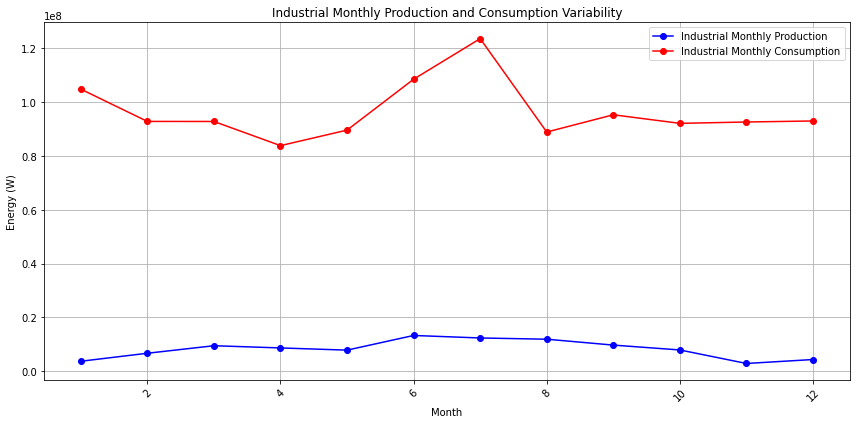

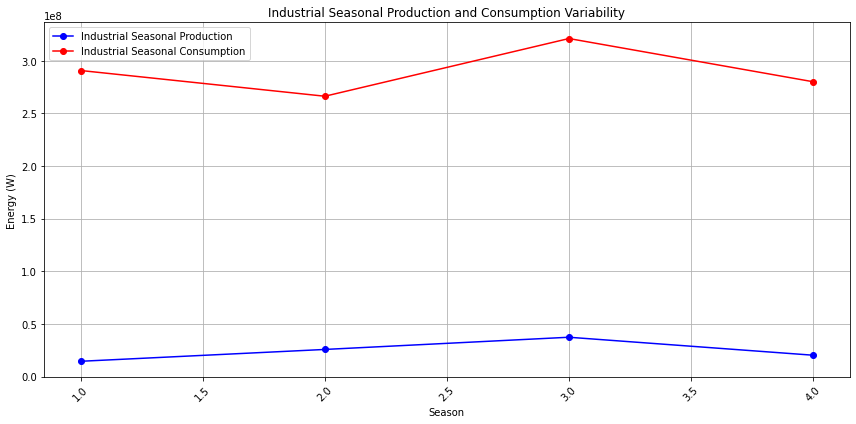

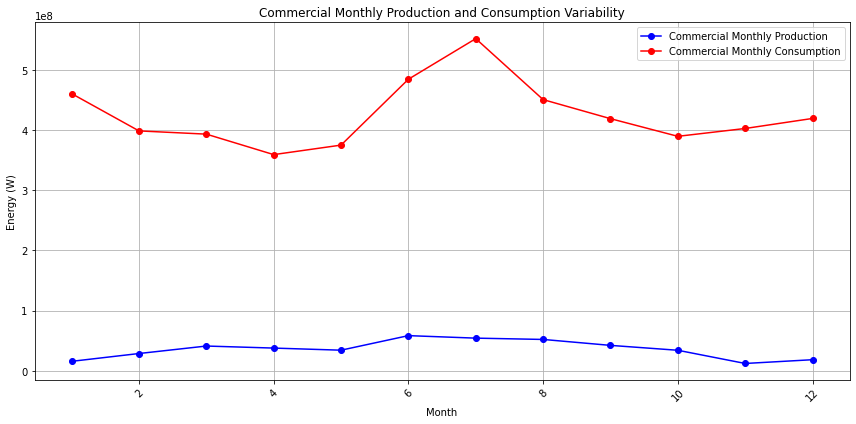

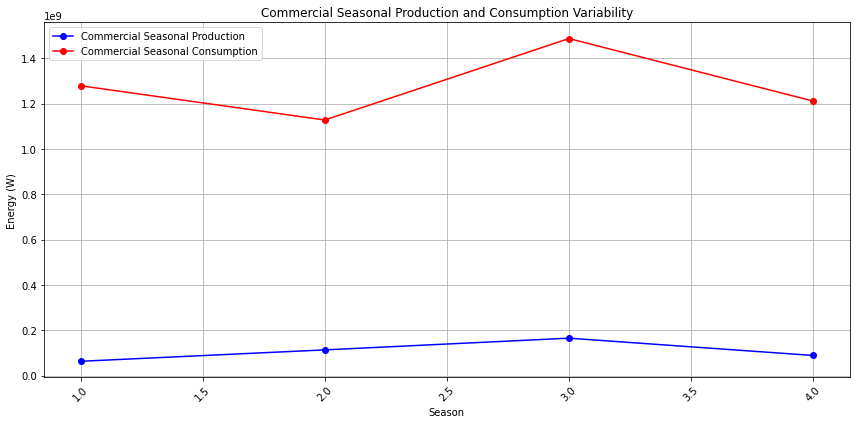

In [95]:
# 1. Peak Production and Consumption Analysis
def peak_analysis(production_df, consumption_df, category_name, area_max):
    # Calculate total production and consumption for each hour
    total_production = production_df.sum(axis=1)
    total_consumption = consumption_df[category_name] * area_max
    
    # Find peak production and consumption hours
    peak_production_hour = total_production.idxmax()
    peak_production_value = total_production.max()
    
    peak_consumption_hour = total_consumption.idxmax()
    peak_consumption_value = total_consumption.max()
    
    print(f"\nPeak Analysis for {category_name}:")
    print(f"Peak Production: {peak_production_value:.2f} W at {peak_production_hour}")
    print(f"Peak Consumption: {peak_consumption_value:.2f} W at {peak_consumption_hour}")
    
    # Plot peak production and consumption
    plt.figure(figsize=(12, 6))
    plt.plot(total_production.index, total_production, label=f'{category_name} Production', color='blue')
    plt.plot(total_consumption.index, total_consumption, label=f'{category_name} Consumption', color='red')
    plt.axvline(peak_production_hour, color='blue', linestyle='--', label='Peak Production')
    plt.axvline(peak_consumption_hour, color='red', linestyle='--', label='Peak Consumption')
    plt.xlabel('Time')
    plt.ylabel('Energy (W)')
    plt.title(f'{category_name} Peak Production and Consumption')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(os.path.join(yearly_plot_dir, f'{category_name}_Peak_Production_Consumption.pdf'))
    plt.show()

# Run peak analysis for each category
peak_analysis(Residential_user_production_df, DF_Consumption, 'Residential', Area_Res_Max)
peak_analysis(Industrial_user_production_df, DF_Consumption, 'Industrial', Area_Ind_Max)
peak_analysis(Commercial_user_production_df, DF_Consumption, 'Commercial', Area_Com_Max)

# 2. Energy Surplus and Deficit Analysis with Heatmap for Each First Week of the Month
def surplus_deficit_heatmap_first_week(production_df, consumption_df, category_name, area_max):
    # Loop through each month to filter the first week and plot
    for month in range(1, 13):
        start_date = f'2019-{month:02d}-01'
        end_date = f'2019-{month:02d}-07'

        # Filter data for the first week of the month
        week_production_df = production_df.loc[start_date:end_date]
        week_consumption_df = consumption_df.loc[start_date:end_date]

        # Calculate total production and consumption for each hour
        total_production = week_production_df.sum(axis=1)
        total_consumption = week_consumption_df[category_name] * area_max

        # Calculate surplus and deficit
        surplus_deficit = total_production - total_consumption

        # Prepare data for heatmap by pivoting the daily data into a matrix of days vs. hours
        daily_surplus_deficit = surplus_deficit.reset_index()
        daily_surplus_deficit.rename(columns={daily_surplus_deficit.columns[0]: 'Datetime'}, inplace=True)
        daily_surplus_deficit['Date'] = daily_surplus_deficit['Datetime'].dt.date
        daily_surplus_deficit['Hour'] = daily_surplus_deficit['Datetime'].dt.hour
        heatmap_data = daily_surplus_deficit.pivot('Date', 'Hour', 0)

        # Plot the heatmap
        plt.figure(figsize=(15, 8))
        sns.heatmap(heatmap_data, cmap='coolwarm', center=0, cbar_kws={'label': 'Surplus/Deficit (W)'})
        plt.title(f'{category_name} Surplus and Deficit Heatmap (First Week of {start_date[:7]})')
        plt.xlabel('Hour of Day')
        plt.ylabel('Date')
        plt.tight_layout()
        plt.savefig(os.path.join(weekly_plot_dir, f'{category_name}_Surplus_Deficit_Heatmap_Week_{month:02d}.pdf'))
        plt.show()

# Run surplus and deficit heatmap analysis for each category
surplus_deficit_heatmap_first_week(Residential_user_production_df, DF_Consumption, 'Residential', Area_Res_Max)
surplus_deficit_heatmap_first_week(Industrial_user_production_df, DF_Consumption, 'Industrial', Area_Ind_Max)
surplus_deficit_heatmap_first_week(Commercial_user_production_df, DF_Consumption, 'Commercial', Area_Com_Max)

# 4. Seasonal and Monthly Variability Analysis
def seasonal_monthly_variability(production_df, consumption_df, category_name, area_max):
    # Add 'Month' and 'Season' columns to DataFrames
    production_df['Month'] = production_df.index.month
    consumption_df['Month'] = consumption_df.index.month
    
    production_df['Season'] = production_df.index.to_series().dt.month % 12 // 3 + 1
    consumption_df['Season'] = consumption_df.index.to_series().dt.month % 12 // 3 + 1
    
    # Calculate monthly and seasonal total production and consumption
    monthly_production = production_df.groupby('Month').sum().sum(axis=1)
    monthly_consumption = consumption_df.groupby('Month')[category_name].sum() * area_max
    
    seasonal_production = production_df.groupby('Season').sum().sum(axis=1)
    seasonal_consumption = consumption_df.groupby('Season')[category_name].sum() * area_max
    
    # Plot monthly variability
    plt.figure(figsize=(12, 6))
    plt.plot(monthly_production.index, monthly_production, label=f'{category_name} Monthly Production', marker='o', color='blue')
    plt.plot(monthly_consumption.index, monthly_consumption, label=f'{category_name} Monthly Consumption', marker='o', color='red')
    plt.xlabel('Month')
    plt.ylabel('Energy (W)')
    plt.title(f'{category_name} Monthly Production and Consumption Variability')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(os.path.join(yearly_plot_dir, f'{category_name}_Monthly_Variability.pdf'))
    plt.show()
    
    # Plot seasonal variability
    plt.figure(figsize=(12, 6))
    plt.plot(seasonal_production.index, seasonal_production, label=f'{category_name} Seasonal Production', marker='o', color='blue')
    plt.plot(seasonal_consumption.index, seasonal_consumption, label=f'{category_name} Seasonal Consumption', marker='o', color='red')
    plt.xlabel('Season')
    plt.ylabel('Energy (W)')
    plt.title(f'{category_name} Seasonal Production and Consumption Variability')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(os.path.join(yearly_plot_dir, f'{category_name}_Seasonal_Variability.pdf'))
    plt.show()

# Run seasonal and monthly variability analysis for each category
seasonal_monthly_variability(Residential_user_production_df, DF_Consumption, 'Residential', Area_Res_Max)
seasonal_monthly_variability(Industrial_user_production_df, DF_Consumption, 'Industrial', Area_Ind_Max)
seasonal_monthly_variability(Commercial_user_production_df, DF_Consumption, 'Commercial', Area_Com_Max)


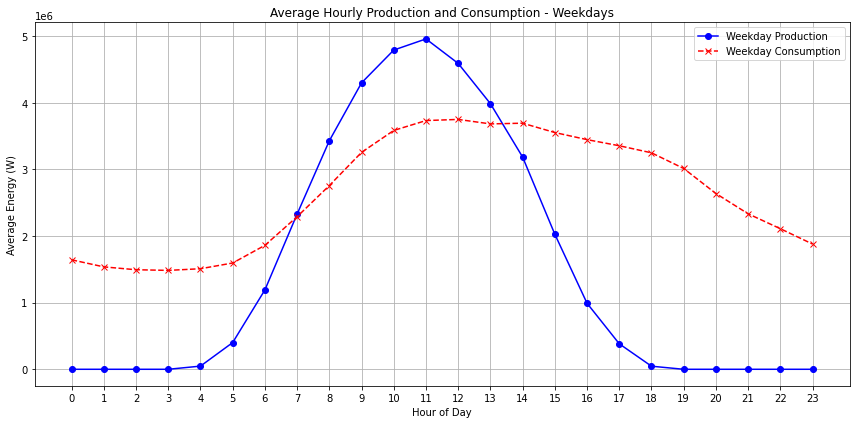

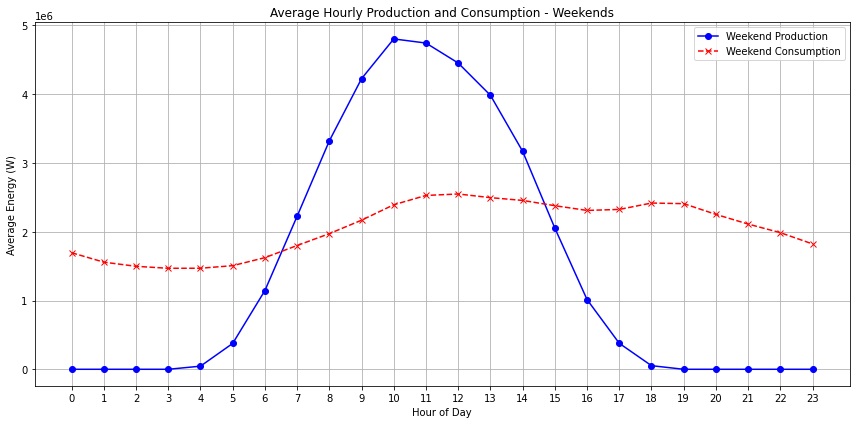

In [94]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Function to analyze weekday vs weekend production and consumption patterns
def weekday_weekend_analysis(production_dfs, consumption_df, area_maxes, category_names):
    # Combine production DataFrames for total production
    total_production_df = pd.concat(production_dfs, axis=1).sum(axis=1)  # Sum across all production DataFrames
    total_production_df = total_production_df.to_frame(name='Total Production')  # Convert to DataFrame

    # Add 'DayOfWeek', 'Hour' columns
    total_production_df['DayOfWeek'] = total_production_df.index.dayofweek  # Monday=0, Sunday=6
    total_production_df['Hour'] = total_production_df.index.hour

    # Add 'Weekday/Weekend' classification
    total_production_df['Type'] = total_production_df['DayOfWeek'].apply(lambda x: 'Weekday' if x < 5 else 'Weekend')

    # Ensure consumption DataFrame is indexed properly
    consumption_df['DayOfWeek'] = consumption_df.index.dayofweek
    consumption_df['Hour'] = consumption_df.index.hour
    consumption_df['Type'] = consumption_df['DayOfWeek'].apply(lambda x: 'Weekday' if x < 5 else 'Weekend')

    # Calculate average hourly production and consumption for weekdays and weekends
    avg_hourly_production = total_production_df.groupby(['Type', 'Hour'])['Total Production'].mean().reset_index()
    avg_hourly_consumption = consumption_df.groupby(['Type', 'Hour']).apply(
        lambda x: sum((x[category] * area_max).mean() for category, area_max in zip(category_names, area_maxes))
    ).reset_index(name='Total Consumption')

    # Plot average hourly production and consumption for weekdays
    plt.figure(figsize=(12, 6))
    weekday_production = avg_hourly_production[avg_hourly_production['Type'] == 'Weekday']
    weekday_consumption = avg_hourly_consumption[avg_hourly_consumption['Type'] == 'Weekday']
    plt.plot(weekday_production['Hour'], weekday_production['Total Production'], label='Weekday Production', linestyle='-', marker='o', color='blue')
    plt.plot(weekday_consumption['Hour'], weekday_consumption['Total Consumption'], label='Weekday Consumption', linestyle='--', marker='x', color='red')
    plt.xlabel('Hour of Day')
    plt.ylabel('Average Energy (W)')
    plt.title('Average Hourly Production and Consumption - Weekdays')
    plt.legend()
    plt.grid(True)
    plt.xticks(range(0, 24))
    plt.tight_layout()
    plt.savefig(os.path.join(yearly_plot_dir, 'Average_Hourly_Production_Consumption_Weekday.pdf'))
    plt.show()

    # Plot average hourly production and consumption for weekends
    plt.figure(figsize=(12, 6))
    weekend_production = avg_hourly_production[avg_hourly_production['Type'] == 'Weekend']
    weekend_consumption = avg_hourly_consumption[avg_hourly_consumption['Type'] == 'Weekend']
    plt.plot(weekend_production['Hour'], weekend_production['Total Production'], label='Weekend Production', linestyle='-', marker='o', color='blue')
    plt.plot(weekend_consumption['Hour'], weekend_consumption['Total Consumption'], label='Weekend Consumption', linestyle='--', marker='x', color='red')
    plt.xlabel('Hour of Day')
    plt.ylabel('Average Energy (W)')
    plt.title('Average Hourly Production and Consumption - Weekends')
    plt.legend()
    plt.grid(True)
    plt.xticks(range(0, 24))
    plt.tight_layout()
    plt.savefig(os.path.join(yearly_plot_dir, 'Average_Hourly_Production_Consumption_Weekend.pdf'))
    plt.show()

# Run weekday vs weekend analysis for total production and consumption
weekday_weekend_analysis(
    [Residential_user_production_df, Industrial_user_production_df, Commercial_user_production_df],
    DF_Consumption, 
    [Area_Res_Max, Area_Ind_Max, Area_Com_Max], 
    ['Residential', 'Industrial', 'Commercial']
)


# Extra